In [1]:
from fenics import *
from graphnics import *
from xii import *
import json
import networkx as nx
from utils import *
from tqdm import tqdm
import seaborn as sns
sns.set_style('whitegrid')

/usr/local/lib/python3.6/dist-packages/block/__init__.py:15: UserWarning: The cbc.block repository has moved to https://github.com/blocknics/cbc.block
  warnings.warn('The cbc.block repository has moved to https://github.com/blocknics/cbc.block', UserWarning)


Missing HsMG for fract norm computing


In [2]:
folder_name = 'results/interacting'

import argparse as arg
args = arg.ArgumentParser()
with open(f'{folder_name}/args.txt', 'r') as f:
    args.__dict__ = json.load(f)
    
radius0 = args.radius0
L = args.L
beta = 2
lamdas = args.lambdas
freqs = args.freq
n_cycles = args.n_cycles
tsteps_per_cycle = args.tsteps_per_cycle
eps = args.epsilon


G = nx.read_gpickle(folder_name + "/G.gpickle")
G = copy_from_nx_graph(G)
G.make_mesh(4)

freqs_str = '-'.join([f'{freq:g}' for freq in freqs])
lamdas_str = '-'.join([f'{l:1.2f}' for l in lamdas])
eps_str = '-'.join([f'{eps:1.2f}' for eps in eps])
vasomotion_desc = f'eps{eps_str}_freq{freqs_str}_lamda{lamdas_str}'

In [3]:
# Read in solution
V = FunctionSpace(G.mesh, 'DG', 1)
Q = FunctionSpace(G.mesh, 'CG', 2)

h5_q = HDF5File(G.mesh.mpi_comm(), f'{folder_name}/sols/q_{geom_desc}_{vasomotion_desc}.h5', 'r')
h5_p = HDF5File(G.mesh.mpi_comm(), f'{folder_name}/sols/p_{geom_desc}_{vasomotion_desc}.h5', 'r')

# read in the solutions over time
qps = []

attrs = h5_q.attributes('q')
print(f'timesteps: {attrs["count"]}')
for i in range(1,attrs['count']-1):
    q = Function(V)
    p = Function(Q)
    h5_q.read(q, f'q/vector_{i}')
    h5_p.read(p, f'p/vector_{i}')
    qps.append((q,p))
h5_p.close()
h5_q.close()

qs = [qp[0] for qp in qps]
ps = [qp[1] for qp in qps]

timesteps: 19999


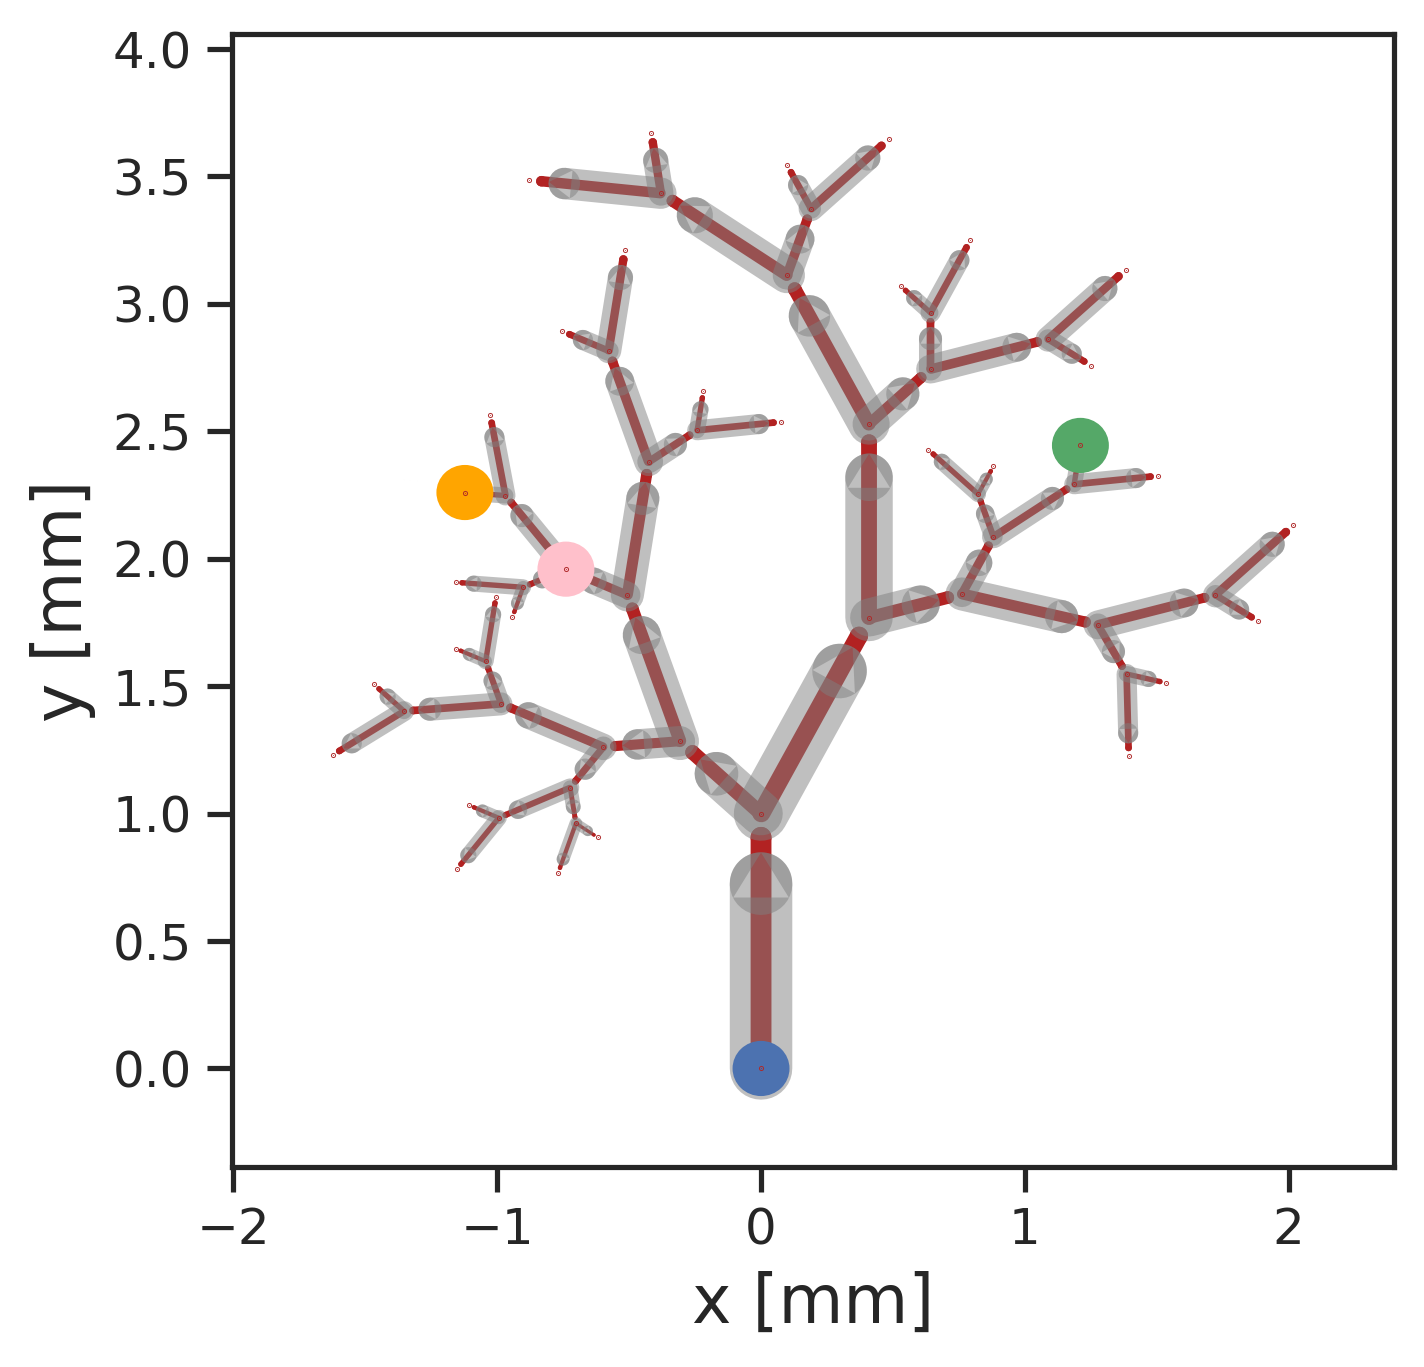

In [157]:
# Make mesh
sns.set_style('white')

def plot_tree(G, fname=None):
    pos = nx.get_node_attributes(G, 'pos')
    pos2d = [coord[0:2] for coord in list(pos.values())]

    radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    nx.draw_networkx(G, pos2d, width=radius*50, edge_color='firebrick', 
                    with_labels=False, node_size=0.05, node_color='firebrick', arrowsize=0.1, ax=ax)
    
    nx.draw_networkx(G, pos2d, width=radius*150, edge_color='gray', 
                    with_labels=False, node_size=0.001, node_color='gray', arrowsize=0.1, ax=ax, alpha=0.5)

    
    ax.set_xlabel('x [mm]', fontsize=16)
    ax.set_ylabel('y [mm]', fontsize=16)
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize=12)

    return fig, ax

fig, ax = plot_tree(G)

pos = nx.get_node_attributes(G, 'pos')
pos2d = [coord[0:2] for coord in list(pos.values())]

root_v = 0 #inlet is the first vertex in the network

# find other boundary points 
adj_matrix = nx.adj_matrix(G).todense()
bps = np.where(np.sum(adj_matrix, axis=1)==0)[0]

leaf1_v, leaf2_v = bps[10], bps[15]

inner_v = 10

root_pos = G.nodes()[root_v]['pos']
leaf_poss= [G.nodes()[bps[v]]['pos'] for v in [10,18]]
inner_pos = G.nodes()[inner_v]['pos']

poss = [root_pos] + leaf_poss + [inner_pos]

radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

colors = ['b', 'orange', 'g', 'pink']

for ix, pos in enumerate(poss):
    circle1 = plt.Circle((pos[0], pos[1]), 0.1, color=colors[ix])
    ax.add_patch(circle1)
    
plt.savefig('tree.png')

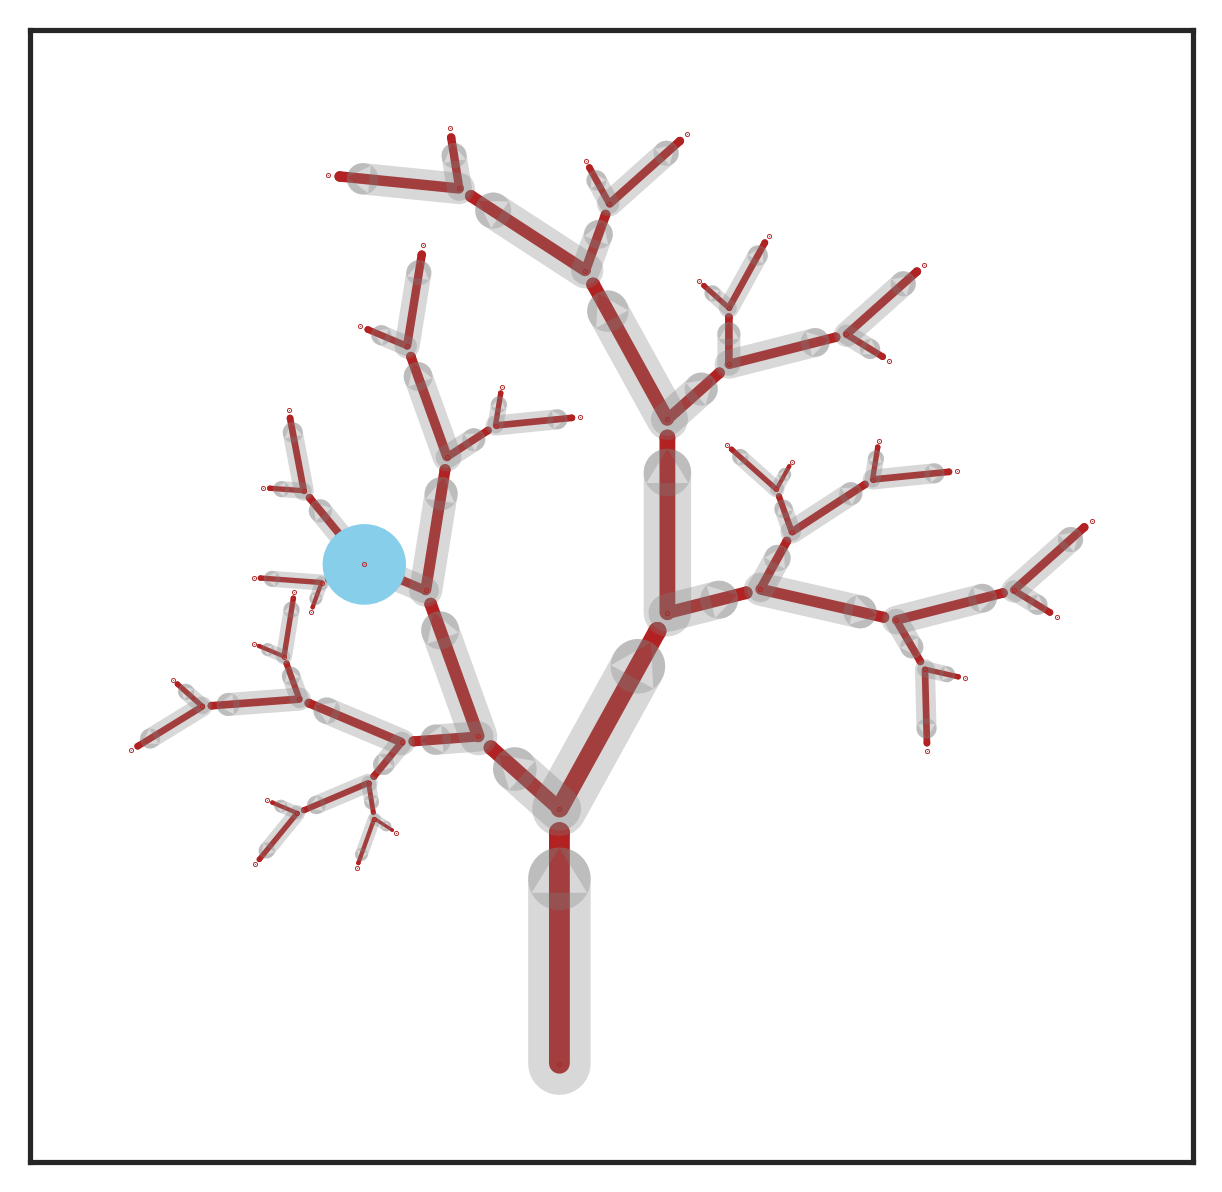

In [170]:
# Make mesh
sns.set_style('white')

def plot_tree(G, fname=None):
    pos = nx.get_node_attributes(G, 'pos')
    pos2d = [coord[0:2] for coord in list(pos.values())]

    radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

    fig, ax = plt.subplots(1,1, figsize=(5,5))
    nx.draw_networkx(G, pos2d, width=radius*50, edge_color='firebrick', 
                    with_labels=False, node_size=0.05, node_color='firebrick', arrowsize=0.1, ax=ax)
    
    nx.draw_networkx(G, pos2d, width=radius*150, edge_color='gray', 
                    with_labels=False, node_size=0.001, node_color='gray', arrowsize=0.1, ax=ax, alpha=0.3)

    return fig, ax

fig, ax = plot_tree(G)

pos = nx.get_node_attributes(G, 'pos')
pos2d = [coord[0:2] for coord in list(pos.values())]

inner_v = 10

inner_pos = G.nodes()[inner_v]['pos']

poss = [inner_pos]

radius = np.asarray(list(nx.get_edge_attributes(G, 'radius').values()))

colors = ['skyblue']

for ix, pos in enumerate(poss):
    circle1 = plt.Circle((pos[0], pos[1]), 0.15, color=colors[ix])
    ax.add_patch(circle1)
    
plt.savefig('tree_small.png')

In [134]:
T = n_cycles/min(freqs) # total simulation time
time_steps = len(qps)
dt = T/time_steps
ts = np.linspace(0, T, time_steps)

time_steps_per_cycle = int(len(qps)/n_cycles)



e = (0,1)
radius1 = G.edges()[e]['radius1']
radius2 = G.edges()[e]['radius2']
area = np.pi*(radius2**2-radius1**2)
area

0.25132741228718347

In [70]:
ffile_p = TubeFile(G, folder_name + '/plots/p.pvd')
ffile_q = File(folder_name + '/plots/q.pvd')
ffile_v = File(folder_name + '/plots/v.pvd')

for e in G.edges():
    radius1 = G.edges()[e]['radius1']
    radius2 = G.edges()[e]['radius2']
    G.edges()[e]['area'] = np.pi*(radius2**2-radius1**2)
    
area_dict = nx.get_edge_attributes(G, 'area')
mesh0, foo = G.get_mesh(0)
DG = FunctionSpace(mesh0, 'DG', 0)
area = Function(DG)
area.vector()[:] = list(area_dict.values())
area.set_allow_extrapolation(True)

tangent = TangentFunction(G, degree=1)

steps = 1
for i in tqdm(range(1000, 4000, steps)):
    
    t = i*dt
    
    ps[i].rename('p', '0')
    ffile_p << (ps[i], float(t))
    
    q = project(tangent*qs[i], VectorFunctionSpace(G.mesh, 'DG', 1))
    q.rename('q', '0')
    ffile_q << (q, float(t))
    
    v = project(tangent*qs[i]/area, VectorFunctionSpace(G.mesh, 'DG', 1))
    v.rename('v', '0')
    ffile_v << (v, float(t))


  0%|          | 0/3000 [00:00<?, ?it/s]


  0%|          | 1/3000 [00:00<13:43,  3.64it/s]


  0%|          | 2/3000 [00:00<13:19,  3.75it/s]


  0%|          | 3/3000 [00:00<12:47,  3.91it/s]


  0%|          | 4/3000 [00:01<12:42,  3.93it/s]


  0%|          | 5/3000 [00:01<13:02,  3.83it/s]


  0%|          | 6/3000 [00:01<12:55,  3.86it/s]


  0%|          | 7/3000 [00:01<12:53,  3.87it/s]


  0%|          | 8/3000 [00:02<12:46,  3.90it/s]


  0%|          | 9/3000 [00:02<12:51,  3.88it/s]


  0%|          | 10/3000 [00:02<12:39,  3.94it/s]


  0%|          | 11/3000 [00:02<12:34,  3.96it/s]


  0%|          | 12/3000 [00:03<12:55,  3.85it/s]


  0%|          | 13/3000 [00:03<13:07,  3.79it/s]


  0%|          | 14/3000 [00:03<13:21,  3.73it/s]


  0%|          | 15/3000 [00:03<13:09,  3.78it/s]


  1%|          | 16/3000 [00:04<12:59,  3.83it/s]


  1%|          | 17/3000 [00:04<12:41,  3.92it/s]


  1%|          | 18/3000 [00:04<12:37,  3.93it/s]


  1%|          | 19/3000 [00:04<12:32,  3.96it/s]


  1%|          | 20/3000 [00:05<12:58,  3.83it/s]


  1%|          | 21/3000 [00:05<12:51,  3.86it/s]


  1%|          | 22/3000 [00:05<13:05,  3.79it/s]


  1%|          | 23/3000 [00:05<12:52,  3.85it/s]


  1%|          | 24/3000 [00:06<12:59,  3.82it/s]


  1%|          | 25/3000 [00:06<12:45,  3.88it/s]


  1%|          | 26/3000 [00:06<12:42,  3.90it/s]


  1%|          | 27/3000 [00:06<12:36,  3.93it/s]


  1%|          | 28/3000 [00:07<12:31,  3.96it/s]


  1%|          | 29/3000 [00:07<12:20,  4.01it/s]


  1%|          | 30/3000 [00:07<12:14,  4.05it/s]


  1%|          | 31/3000 [00:08<13:45,  3.60it/s]


  1%|          | 32/3000 [00:08<13:08,  3.76it/s]


  1%|          | 33/3000 [00:08<12:49,  3.86it/s]


  1%|          | 34/3000 [00:08<12:36,  3.92it/s]


  1%|          | 35/3000 [00:09<12:42,  3.89it/s]


  1%|          | 36/3000 [00:09<12:50,  3.85it/s]


  1%|          | 37/3000 [00:09<12:53,  3.83it/s]


  1%|▏         | 38/3000 [00:09<12:48,  3.85it/s]


  1%|▏         | 39/3000 [00:10<12:56,  3.81it/s]


  1%|▏         | 40/3000 [00:10<12:47,  3.86it/s]


  1%|▏         | 41/3000 [00:10<12:42,  3.88it/s]


  1%|▏         | 42/3000 [00:10<13:23,  3.68it/s]


  1%|▏         | 43/3000 [00:11<13:06,  3.76it/s]


  1%|▏         | 44/3000 [00:11<12:42,  3.87it/s]


  2%|▏         | 45/3000 [00:11<12:45,  3.86it/s]

  2%|▏         | 47/3000 [00:12<12:21,  3.98it/s]


  2%|▏         | 48/3000 [00:12<12:24,  3.97it/s]


  2%|▏         | 49/3000 [00:12<12:20,  3.98it/s]


  2%|▏         | 50/3000 [00:12<12:14,  4.01it/s]


  2%|▏         | 51/3000 [00:13<12:08,  4.05it/s]


  2%|▏         | 52/3000 [00:13<11:58,  4.10it/s]


  2%|▏         | 53/3000 [00:13<11:48,  4.16it/s]


  2%|▏         | 54/3000 [00:13<11:45,  4.17it/s]


  2%|▏         | 55/3000 [00:14<12:22,  3.97it/s]


  2%|▏         | 56/3000 [00:14<14:10,  3.46it/s]


  2%|▏         | 57/3000 [00:14<14:54,  3.29it/s]


  2%|▏         | 58/3000 [00:15<16:12,  3.03it/s]


  2%|▏         | 59/3000 [00:15<17:08,  2.86it/s]


  2%|▏         | 60/3000 [00:16<17:48,  2.75it/s]


  2%|▏         | 61/3000 [00:16<17:15,  2.84it/s]


  2%|▏         | 62/3000 [00:16<17:01,  2.88it/s]


  2%|▏         | 63/3000 [00:17<17:02,  2.87it/s]


  2%|▏         | 64/3000 [00:17<17:50,  2.74it/s]


  2%|▏         | 65/3000 [00:17<18:16,  2.68it/s]


  2%|▏         | 66/3000 [00:18<18:06,  2.70it/s]


  2%|▏         | 67/3000 [00:18<18:20,  2.67it/s]


  2%|▏         | 68/3000 [00:18<17:30,  2.79it/s]


  2%|▏         | 69/3000 [00:19<18:17,  2.67it/s]


  2%|▏         | 70/3000 [00:19<17:48,  2.74it/s]


  2%|▏         | 71/3000 [00:19<17:20,  2.81it/s]


  2%|▏         | 72/3000 [00:20<18:57,  2.57it/s]


  2%|▏         | 73/3000 [00:21<21:52,  2.23it/s]


  2%|▏         | 74/3000 [00:21<23:09,  2.11it/s]


  2%|▎         | 75/3000 [00:21<22:11,  2.20it/s]


  3%|▎         | 76/3000 [00:22<21:09,  2.30it/s]


  3%|▎         | 77/3000 [00:22<18:55,  2.58it/s]


  3%|▎         | 78/3000 [00:22<16:55,  2.88it/s]


  3%|▎         | 79/3000 [00:23<15:25,  3.16it/s]

  3%|▎         | 81/3000 [00:23<13:22,  3.64it/s]

  3%|▎         | 83/3000 [00:24<12:12,  3.98it/s]

  3%|▎         | 85/3000 [00:24<11:37,  4.18it/s]


  3%|▎         | 86/3000 [00:24<11:25,  4.25it/s]

  3%|▎         | 88/3000 [00:25<11:19,  4.29it/s]


  3%|▎         | 89/3000 [00:25<11:13,  4.32it/s]


  3%|▎         | 90/3000 [00:25<11:14,  4.32it/s]


  3%|▎         | 91/3000 [00:25<11:35,  4.18it/s]


  3%|▎         | 92/3000 [00:26<11:39,  4.16it/s]


  3%|▎         | 93/3000 [00:26<11:38,  4.16it/s]


  3%|▎         | 94/3000 [00:26<11:29,  4.21it/s]

  3%|▎         | 96/3000 [00:27<11:26,  4.23it/s]


  3%|▎         | 97/3000 [00:27<11:22,  4.25it/s]


  3%|▎         | 98/3000 [00:27<11:30,  4.20it/s]

  3%|▎         | 100/3000 [00:28<11:25,  4.23it/s]


  3%|▎         | 101/3000 [00:28<11:22,  4.25it/s]

  3%|▎         | 103/3000 [00:28<11:12,  4.31it/s]


  3%|▎         | 104/3000 [00:29<11:11,  4.31it/s]

  4%|▎         | 106/3000 [00:29<11:03,  4.36it/s]


  4%|▎         | 107/3000 [00:29<11:02,  4.37it/s]


  4%|▎         | 108/3000 [00:29<11:06,  4.34it/s]

  4%|▎         | 110/3000 [00:30<15:07,  3.18it/s]

  4%|▎         | 112/3000 [00:31<12:32,  3.84it/s]


  4%|▍         | 113/3000 [00:31<11:53,  4.05it/s]


  4%|▍         | 114/3000 [00:31<11:27,  4.20it/s]


  4%|▍         | 115/3000 [00:31<11:17,  4.26it/s]


  4%|▍         | 116/3000 [00:32<11:09,  4.31it/s]

  4%|▍         | 118/3000 [00:32<11:00,  4.36it/s]

  4%|▍         | 120/3000 [00:33<11:02,  4.34it/s]

  4%|▍         | 122/3000 [00:33<10:59,  4.36it/s]

  4%|▍         | 124/3000 [00:33<10:58,  4.37it/s]

  4%|▍         | 126/3000 [00:34<10:56,  4.38it/s]

  4%|▍         | 128/3000 [00:34<10:57,  4.37it/s]

  4%|▍         | 130/3000 [00:35<10:53,  4.39it/s]

  4%|▍         | 132/3000 [00:35<12:28,  3.83it/s]


  4%|▍         | 133/3000 [00:36<11:44,  4.07it/s]

  4%|▍         | 135/3000 [00:36<11:09,  4.28it/s]


  5%|▍         | 136/3000 [00:36<11:01,  4.33it/s]

  5%|▍         | 138/3000 [00:37<10:52,  4.38it/s]

  5%|▍         | 140/3000 [00:37<10:51,  4.39it/s]


  5%|▍         | 141/3000 [00:37<10:53,  4.38it/s]

  5%|▍         | 143/3000 [00:38<10:52,  4.38it/s]


  5%|▍         | 144/3000 [00:38<10:52,  4.38it/s]

  5%|▍         | 146/3000 [00:39<10:50,  4.39it/s]


  5%|▍         | 147/3000 [00:39<10:51,  4.38it/s]


  5%|▍         | 148/3000 [00:39<10:51,  4.38it/s]


  5%|▍         | 149/3000 [00:39<10:52,  4.37it/s]


  5%|▌         | 150/3000 [00:39<10:54,  4.36it/s]


  5%|▌         | 151/3000 [00:40<10:55,  4.34it/s]

  5%|▌         | 153/3000 [00:40<10:54,  4.35it/s]


  5%|▌         | 154/3000 [00:40<10:55,  4.34it/s]


  5%|▌         | 155/3000 [00:41<10:54,  4.35it/s]


  5%|▌         | 156/3000 [00:41<10:57,  4.33it/s]

  5%|▌         | 158/3000 [00:41<10:57,  4.33it/s]

  5%|▌         | 160/3000 [00:42<10:50,  4.36it/s]


  5%|▌         | 161/3000 [00:42<10:51,  4.36it/s]


  5%|▌         | 162/3000 [00:42<10:52,  4.35it/s]

  5%|▌         | 164/3000 [00:43<10:55,  4.33it/s]


  6%|▌         | 165/3000 [00:43<10:51,  4.35it/s]


  6%|▌         | 166/3000 [00:43<10:48,  4.37it/s]


  6%|▌         | 167/3000 [00:43<10:48,  4.37it/s]


  6%|▌         | 168/3000 [00:44<10:50,  4.35it/s]


  6%|▌         | 169/3000 [00:44<10:51,  4.35it/s]


  6%|▌         | 170/3000 [00:44<10:50,  4.35it/s]

  6%|▌         | 172/3000 [00:45<10:53,  4.33it/s]

  6%|▌         | 174/3000 [00:45<10:47,  4.36it/s]

  6%|▌         | 176/3000 [00:45<10:50,  4.34it/s]


  6%|▌         | 177/3000 [00:46<10:51,  4.33it/s]

  6%|▌         | 179/3000 [00:46<10:46,  4.37it/s]

  6%|▌         | 181/3000 [00:47<10:47,  4.35it/s]

  6%|▌         | 183/3000 [00:47<10:45,  4.37it/s]


  6%|▌         | 184/3000 [00:47<10:45,  4.36it/s]


  6%|▌         | 185/3000 [00:48<10:44,  4.37it/s]

  6%|▌         | 187/3000 [00:48<10:47,  4.34it/s]


  6%|▋         | 188/3000 [00:48<10:47,  4.34it/s]


  6%|▋         | 189/3000 [00:48<10:50,  4.32it/s]

  6%|▋         | 191/3000 [00:49<10:47,  4.34it/s]


  6%|▋         | 192/3000 [00:49<10:46,  4.35it/s]

  6%|▋         | 194/3000 [00:50<10:45,  4.35it/s]


  6%|▋         | 195/3000 [00:50<10:46,  4.34it/s]


  7%|▋         | 196/3000 [00:50<10:43,  4.36it/s]


  7%|▋         | 197/3000 [00:50<10:44,  4.35it/s]


  7%|▋         | 198/3000 [00:51<10:49,  4.32it/s]


  7%|▋         | 199/3000 [00:51<10:50,  4.30it/s]

  7%|▋         | 201/3000 [00:51<10:49,  4.31it/s]


  7%|▋         | 202/3000 [00:51<11:01,  4.23it/s]


  7%|▋         | 203/3000 [00:52<11:12,  4.16it/s]


  7%|▋         | 204/3000 [00:52<11:12,  4.16it/s]

  7%|▋         | 206/3000 [00:52<11:05,  4.20it/s]

  7%|▋         | 208/3000 [00:53<10:56,  4.26it/s]

  7%|▋         | 210/3000 [00:53<10:49,  4.30it/s]


  7%|▋         | 211/3000 [00:54<10:48,  4.30it/s]

  7%|▋         | 213/3000 [00:54<10:43,  4.33it/s]


  7%|▋         | 214/3000 [00:54<10:43,  4.33it/s]


  7%|▋         | 215/3000 [00:55<10:53,  4.26it/s]


  7%|▋         | 216/3000 [00:55<10:55,  4.24it/s]


  7%|▋         | 217/3000 [00:55<10:52,  4.26it/s]


  7%|▋         | 218/3000 [00:55<10:52,  4.26it/s]


  7%|▋         | 219/3000 [00:55<10:50,  4.28it/s]


  7%|▋         | 220/3000 [00:56<10:47,  4.29it/s]

  7%|▋         | 222/3000 [00:56<10:44,  4.31it/s]

  7%|▋         | 224/3000 [00:57<10:38,  4.35it/s]


  8%|▊         | 225/3000 [00:57<10:39,  4.34it/s]

  8%|▊         | 227/3000 [00:57<10:36,  4.36it/s]

  8%|▊         | 229/3000 [00:58<10:33,  4.37it/s]

  8%|▊         | 231/3000 [00:58<10:32,  4.38it/s]


  8%|▊         | 232/3000 [00:58<10:38,  4.34it/s]


  8%|▊         | 233/3000 [00:59<10:47,  4.28it/s]


  8%|▊         | 234/3000 [00:59<10:48,  4.26it/s]


  8%|▊         | 235/3000 [00:59<10:46,  4.28it/s]


  8%|▊         | 236/3000 [00:59<10:47,  4.27it/s]

  8%|▊         | 238/3000 [01:00<10:48,  4.26it/s]


  8%|▊         | 239/3000 [01:00<10:47,  4.26it/s]

  8%|▊         | 241/3000 [01:01<10:43,  4.29it/s]

  8%|▊         | 243/3000 [01:01<10:39,  4.31it/s]

  8%|▊         | 245/3000 [01:02<10:34,  4.34it/s]

  8%|▊         | 247/3000 [01:02<10:32,  4.35it/s]


  8%|▊         | 248/3000 [01:02<10:31,  4.36it/s]


  8%|▊         | 249/3000 [01:02<10:29,  4.37it/s]

  8%|▊         | 251/3000 [01:03<10:32,  4.35it/s]

  8%|▊         | 253/3000 [01:03<10:27,  4.38it/s]


  8%|▊         | 254/3000 [01:04<10:29,  4.36it/s]

  9%|▊         | 256/3000 [01:04<10:32,  4.34it/s]

  9%|▊         | 258/3000 [01:04<10:29,  4.36it/s]

  9%|▊         | 260/3000 [01:05<10:10,  4.48it/s]

  9%|▊         | 262/3000 [01:05<09:29,  4.80it/s]

  9%|▉         | 264/3000 [01:06<09:05,  5.01it/s]

  9%|▉         | 266/3000 [01:06<08:48,  5.18it/s]

  9%|▉         | 268/3000 [01:06<08:41,  5.24it/s]

  9%|▉         | 270/3000 [01:07<08:35,  5.29it/s]

  9%|▉         | 272/3000 [01:07<08:28,  5.36it/s]

  9%|▉         | 274/3000 [01:08<08:25,  5.39it/s]

  9%|▉         | 276/3000 [01:08<08:23,  5.41it/s]

  9%|▉         | 278/3000 [01:08<08:25,  5.38it/s]

  9%|▉         | 280/3000 [01:09<08:26,  5.38it/s]

  9%|▉         | 282/3000 [01:09<08:28,  5.34it/s]

  9%|▉         | 284/3000 [01:09<08:29,  5.34it/s]

 10%|▉         | 286/3000 [01:10<08:26,  5.35it/s]

 10%|▉         | 288/3000 [01:10<08:22,  5.39it/s]

 10%|▉         | 290/3000 [01:11<08:23,  5.39it/s]

 10%|▉         | 292/3000 [01:11<08:24,  5.37it/s]

 10%|▉         | 294/3000 [01:11<08:25,  5.35it/s]

 10%|▉         | 296/3000 [01:12<08:33,  5.26it/s]

 10%|▉         | 298/3000 [01:12<08:38,  5.21it/s]

 10%|█         | 300/3000 [01:12<08:34,  5.24it/s]

 10%|█         | 302/3000 [01:13<08:30,  5.29it/s]

 10%|█         | 304/3000 [01:13<08:25,  5.34it/s]

 10%|█         | 306/3000 [01:14<08:24,  5.34it/s]

 10%|█         | 308/3000 [01:14<08:23,  5.35it/s]

 10%|█         | 310/3000 [01:14<08:24,  5.34it/s]

 10%|█         | 312/3000 [01:15<08:23,  5.33it/s]

 10%|█         | 314/3000 [01:15<08:24,  5.33it/s]

 11%|█         | 316/3000 [01:15<08:25,  5.31it/s]

 11%|█         | 318/3000 [01:16<08:25,  5.30it/s]

 11%|█         | 320/3000 [01:16<08:22,  5.33it/s]

 11%|█         | 322/3000 [01:17<08:21,  5.34it/s]

 11%|█         | 324/3000 [01:17<08:20,  5.35it/s]

 11%|█         | 326/3000 [01:17<08:21,  5.33it/s]

 11%|█         | 328/3000 [01:18<08:21,  5.32it/s]

 11%|█         | 330/3000 [01:18<08:21,  5.32it/s]

 11%|█         | 332/3000 [01:18<08:22,  5.31it/s]

 11%|█         | 334/3000 [01:19<08:21,  5.31it/s]

 11%|█         | 336/3000 [01:19<08:16,  5.37it/s]

 11%|█▏        | 338/3000 [01:20<08:13,  5.39it/s]

 11%|█▏        | 340/3000 [01:20<08:13,  5.39it/s]

 11%|█▏        | 342/3000 [01:20<08:12,  5.40it/s]

 11%|█▏        | 344/3000 [01:21<08:16,  5.35it/s]

 12%|█▏        | 346/3000 [01:21<08:18,  5.33it/s]

 12%|█▏        | 348/3000 [01:21<08:17,  5.33it/s]

 12%|█▏        | 350/3000 [01:22<08:15,  5.35it/s]

 12%|█▏        | 352/3000 [01:22<08:13,  5.37it/s]

 12%|█▏        | 354/3000 [01:23<08:12,  5.37it/s]

 12%|█▏        | 356/3000 [01:23<08:12,  5.37it/s]

 12%|█▏        | 358/3000 [01:23<08:19,  5.28it/s]

 12%|█▏        | 360/3000 [01:24<08:21,  5.27it/s]

 12%|█▏        | 362/3000 [01:24<08:17,  5.30it/s]

 12%|█▏        | 364/3000 [01:24<08:17,  5.30it/s]

 12%|█▏        | 366/3000 [01:25<08:15,  5.32it/s]

 12%|█▏        | 368/3000 [01:25<08:10,  5.37it/s]

 12%|█▏        | 370/3000 [01:26<08:07,  5.39it/s]

 12%|█▏        | 372/3000 [01:26<08:07,  5.39it/s]

 12%|█▏        | 374/3000 [01:26<08:06,  5.40it/s]

 13%|█▎        | 376/3000 [01:27<08:09,  5.36it/s]

 13%|█▎        | 378/3000 [01:27<08:09,  5.36it/s]

 13%|█▎        | 380/3000 [01:27<08:10,  5.34it/s]

 13%|█▎        | 382/3000 [01:28<08:11,  5.32it/s]

 13%|█▎        | 384/3000 [01:28<08:09,  5.34it/s]

 13%|█▎        | 386/3000 [01:29<08:08,  5.35it/s]

 13%|█▎        | 388/3000 [01:29<08:08,  5.35it/s]

 13%|█▎        | 390/3000 [01:29<08:08,  5.34it/s]

 13%|█▎        | 392/3000 [01:30<08:09,  5.32it/s]

 13%|█▎        | 394/3000 [01:30<08:10,  5.31it/s]

 13%|█▎        | 396/3000 [01:30<08:09,  5.32it/s]

 13%|█▎        | 398/3000 [01:31<08:08,  5.32it/s]

 13%|█▎        | 400/3000 [01:31<08:08,  5.32it/s]

 13%|█▎        | 402/3000 [01:32<08:06,  5.34it/s]

 13%|█▎        | 404/3000 [01:32<08:09,  5.31it/s]

 14%|█▎        | 406/3000 [01:32<08:10,  5.28it/s]

 14%|█▎        | 408/3000 [01:33<08:15,  5.23it/s]

 14%|█▎        | 410/3000 [01:33<08:15,  5.22it/s]

 14%|█▎        | 412/3000 [01:33<08:20,  5.17it/s]

 14%|█▍        | 414/3000 [01:34<08:22,  5.15it/s]

 14%|█▍        | 416/3000 [01:34<08:23,  5.13it/s]

 14%|█▍        | 418/3000 [01:35<08:22,  5.14it/s]

 14%|█▍        | 420/3000 [01:35<08:22,  5.13it/s]

 14%|█▍        | 422/3000 [01:35<08:18,  5.17it/s]

 14%|█▍        | 424/3000 [01:36<08:09,  5.26it/s]

 14%|█▍        | 426/3000 [01:36<08:05,  5.30it/s]

 14%|█▍        | 428/3000 [01:37<08:05,  5.30it/s]

 14%|█▍        | 430/3000 [01:37<08:05,  5.30it/s]

 14%|█▍        | 432/3000 [01:37<08:03,  5.31it/s]

 14%|█▍        | 434/3000 [01:38<08:05,  5.28it/s]

 15%|█▍        | 436/3000 [01:38<08:06,  5.27it/s]

 15%|█▍        | 438/3000 [01:38<08:04,  5.29it/s]

 15%|█▍        | 440/3000 [01:39<08:04,  5.29it/s]

 15%|█▍        | 442/3000 [01:39<08:00,  5.32it/s]

 15%|█▍        | 444/3000 [01:40<07:58,  5.34it/s]

 15%|█▍        | 446/3000 [01:40<07:57,  5.35it/s]

 15%|█▍        | 448/3000 [01:40<08:00,  5.31it/s]

 15%|█▌        | 450/3000 [01:41<08:10,  5.20it/s]

 15%|█▌        | 452/3000 [01:41<08:17,  5.12it/s]

 15%|█▌        | 454/3000 [01:42<08:17,  5.12it/s]

 15%|█▌        | 456/3000 [01:42<08:13,  5.15it/s]

 15%|█▌        | 458/3000 [01:42<08:14,  5.14it/s]

 15%|█▌        | 460/3000 [01:43<08:08,  5.20it/s]

 15%|█▌        | 462/3000 [01:43<08:01,  5.27it/s]

 15%|█▌        | 464/3000 [01:43<07:58,  5.30it/s]

 16%|█▌        | 466/3000 [01:44<07:58,  5.30it/s]

 16%|█▌        | 468/3000 [01:44<08:51,  4.76it/s]


 16%|█▌        | 469/3000 [01:44<08:56,  4.72it/s]

 16%|█▌        | 471/3000 [01:45<08:52,  4.75it/s]

 16%|█▌        | 473/3000 [01:45<09:05,  4.63it/s]

 16%|█▌        | 475/3000 [01:46<08:55,  4.72it/s]

 16%|█▌        | 477/3000 [01:46<08:32,  4.93it/s]

 16%|█▌        | 479/3000 [01:47<08:17,  5.07it/s]

 16%|█▌        | 481/3000 [01:47<08:16,  5.08it/s]

 16%|█▌        | 483/3000 [01:47<08:08,  5.15it/s]

 16%|█▌        | 485/3000 [01:48<08:13,  5.10it/s]

 16%|█▌        | 487/3000 [01:48<08:12,  5.11it/s]

 16%|█▋        | 489/3000 [01:49<08:18,  5.04it/s]

 16%|█▋        | 491/3000 [01:49<08:13,  5.08it/s]

 16%|█▋        | 493/3000 [01:49<08:00,  5.22it/s]

 16%|█▋        | 495/3000 [01:50<07:55,  5.27it/s]

 17%|█▋        | 497/3000 [01:50<08:03,  5.18it/s]

 17%|█▋        | 499/3000 [01:50<08:07,  5.14it/s]

 17%|█▋        | 501/3000 [01:51<08:19,  5.00it/s]

 17%|█▋        | 503/3000 [01:51<08:16,  5.03it/s]


 17%|█▋        | 504/3000 [01:51<08:16,  5.03it/s]

 17%|█▋        | 506/3000 [01:52<08:26,  4.92it/s]

 17%|█▋        | 508/3000 [01:52<08:27,  4.91it/s]

 17%|█▋        | 510/3000 [01:53<08:44,  4.75it/s]


 17%|█▋        | 511/3000 [01:53<08:56,  4.64it/s]

 17%|█▋        | 513/3000 [01:53<09:27,  4.39it/s]


 17%|█▋        | 514/3000 [01:54<09:44,  4.25it/s]


 17%|█▋        | 515/3000 [01:54<10:09,  4.07it/s]


 17%|█▋        | 516/3000 [01:54<10:27,  3.96it/s]


 17%|█▋        | 517/3000 [01:54<10:55,  3.79it/s]


 17%|█▋        | 518/3000 [01:55<12:33,  3.29it/s]


 17%|█▋        | 519/3000 [01:55<13:37,  3.04it/s]


 17%|█▋        | 520/3000 [01:56<14:22,  2.88it/s]


 17%|█▋        | 521/3000 [01:56<14:51,  2.78it/s]


 17%|█▋        | 522/3000 [01:56<15:12,  2.72it/s]


 17%|█▋        | 523/3000 [01:57<15:37,  2.64it/s]


 17%|█▋        | 524/3000 [01:57<16:14,  2.54it/s]


 18%|█▊        | 525/3000 [01:58<16:16,  2.54it/s]


 18%|█▊        | 526/3000 [01:58<16:14,  2.54it/s]


 18%|█▊        | 527/3000 [01:58<16:07,  2.55it/s]


 18%|█▊        | 528/3000 [01:59<16:08,  2.55it/s]


 18%|█▊        | 529/3000 [01:59<16:23,  2.51it/s]


 18%|█▊        | 530/3000 [02:00<16:50,  2.44it/s]


 18%|█▊        | 531/3000 [02:00<17:11,  2.39it/s]


 18%|█▊        | 532/3000 [02:01<17:00,  2.42it/s]


 18%|█▊        | 533/3000 [02:01<17:11,  2.39it/s]


 18%|█▊        | 534/3000 [02:02<19:34,  2.10it/s]


 18%|█▊        | 535/3000 [02:02<20:33,  2.00it/s]


 18%|█▊        | 536/3000 [02:03<19:16,  2.13it/s]


 18%|█▊        | 537/3000 [02:03<17:08,  2.40it/s]


 18%|█▊        | 538/3000 [02:03<15:25,  2.66it/s]


 18%|█▊        | 539/3000 [02:03<14:09,  2.90it/s]


 18%|█▊        | 540/3000 [02:04<13:22,  3.07it/s]


 18%|█▊        | 541/3000 [02:04<12:27,  3.29it/s]

 18%|█▊        | 543/3000 [02:04<11:08,  3.67it/s]


 18%|█▊        | 544/3000 [02:05<10:37,  3.85it/s]


 18%|█▊        | 545/3000 [02:05<10:17,  3.98it/s]


 18%|█▊        | 546/3000 [02:05<10:02,  4.07it/s]


 18%|█▊        | 547/3000 [02:05<10:03,  4.07it/s]


 18%|█▊        | 548/3000 [02:06<10:36,  3.85it/s]


 18%|█▊        | 549/3000 [02:06<10:58,  3.72it/s]


 18%|█▊        | 550/3000 [02:06<12:09,  3.36it/s]


 18%|█▊        | 551/3000 [02:07<12:33,  3.25it/s]


 18%|█▊        | 552/3000 [02:07<12:11,  3.35it/s]


 18%|█▊        | 553/3000 [02:07<11:42,  3.48it/s]


 18%|█▊        | 554/3000 [02:07<11:11,  3.64it/s]


 18%|█▊        | 555/3000 [02:08<10:46,  3.78it/s]


 19%|█▊        | 556/3000 [02:08<10:28,  3.89it/s]


 19%|█▊        | 557/3000 [02:08<10:12,  3.99it/s]

 19%|█▊        | 559/3000 [02:09<09:51,  4.13it/s]

 19%|█▊        | 561/3000 [02:09<09:39,  4.21it/s]


 19%|█▊        | 562/3000 [02:09<09:36,  4.23it/s]

 19%|█▉        | 564/3000 [02:10<09:29,  4.28it/s]


 19%|█▉        | 565/3000 [02:10<09:27,  4.29it/s]


 19%|█▉        | 566/3000 [02:10<09:22,  4.33it/s]

 19%|█▉        | 568/3000 [02:11<09:24,  4.31it/s]

 19%|█▉        | 570/3000 [02:11<09:23,  4.31it/s]


 19%|█▉        | 571/3000 [02:11<09:24,  4.30it/s]


 19%|█▉        | 572/3000 [02:12<09:25,  4.30it/s]


 19%|█▉        | 573/3000 [02:12<09:28,  4.27it/s]


 19%|█▉        | 574/3000 [02:12<13:24,  3.01it/s]

 19%|█▉        | 576/3000 [02:13<13:33,  2.98it/s]


 19%|█▉        | 577/3000 [02:13<12:00,  3.36it/s]

 19%|█▉        | 579/3000 [02:14<10:42,  3.77it/s]


 19%|█▉        | 580/3000 [02:14<10:29,  3.84it/s]


 19%|█▉        | 581/3000 [02:14<10:17,  3.92it/s]


 19%|█▉        | 582/3000 [02:15<10:11,  3.95it/s]


 19%|█▉        | 583/3000 [02:15<10:06,  3.98it/s]


 19%|█▉        | 584/3000 [02:15<10:06,  3.98it/s]


 20%|█▉        | 585/3000 [02:15<10:06,  3.98it/s]


 20%|█▉        | 586/3000 [02:16<10:19,  3.89it/s]


 20%|█▉        | 587/3000 [02:16<10:12,  3.94it/s]


 20%|█▉        | 588/3000 [02:16<10:02,  4.00it/s]

 20%|█▉        | 590/3000 [02:17<09:55,  4.05it/s]


 20%|█▉        | 591/3000 [02:17<10:08,  3.96it/s]


 20%|█▉        | 592/3000 [02:17<10:18,  3.89it/s]


 20%|█▉        | 593/3000 [02:17<10:11,  3.93it/s]


 20%|█▉        | 594/3000 [02:18<10:11,  3.93it/s]


 20%|█▉        | 595/3000 [02:18<10:06,  3.97it/s]


 20%|█▉        | 596/3000 [02:18<10:02,  3.99it/s]


 20%|█▉        | 597/3000 [02:18<10:05,  3.97it/s]


 20%|█▉        | 598/3000 [02:19<10:02,  3.98it/s]


 20%|█▉        | 599/3000 [02:19<10:02,  3.99it/s]


 20%|██        | 600/3000 [02:19<09:58,  4.01it/s]


 20%|██        | 601/3000 [02:19<09:57,  4.02it/s]


 20%|██        | 602/3000 [02:20<09:54,  4.04it/s]


 20%|██        | 603/3000 [02:20<09:57,  4.01it/s]


 20%|██        | 604/3000 [02:20<09:53,  4.04it/s]


 20%|██        | 605/3000 [02:20<09:47,  4.07it/s]


 20%|██        | 606/3000 [02:21<09:55,  4.02it/s]


 20%|██        | 607/3000 [02:21<10:32,  3.78it/s]


 20%|██        | 608/3000 [02:21<12:02,  3.31it/s]


 20%|██        | 609/3000 [02:22<13:16,  3.00it/s]


 20%|██        | 610/3000 [02:22<14:10,  2.81it/s]


 20%|██        | 611/3000 [02:22<14:40,  2.71it/s]


 20%|██        | 612/3000 [02:23<14:28,  2.75it/s]


 20%|██        | 613/3000 [02:23<14:58,  2.66it/s]


 20%|██        | 614/3000 [02:24<15:12,  2.61it/s]


 20%|██        | 615/3000 [02:24<15:26,  2.58it/s]


 21%|██        | 616/3000 [02:24<15:39,  2.54it/s]


 21%|██        | 617/3000 [02:25<16:08,  2.46it/s]


 21%|██        | 618/3000 [02:25<16:04,  2.47it/s]


 21%|██        | 619/3000 [02:26<16:26,  2.41it/s]


 21%|██        | 620/3000 [02:26<16:56,  2.34it/s]


 21%|██        | 621/3000 [02:27<16:53,  2.35it/s]


 21%|██        | 622/3000 [02:27<16:42,  2.37it/s]


 21%|██        | 623/3000 [02:27<17:31,  2.26it/s]


 21%|██        | 624/3000 [02:28<19:07,  2.07it/s]


 21%|██        | 625/3000 [02:29<19:50,  1.99it/s]


 21%|██        | 626/3000 [02:29<18:32,  2.13it/s]


 21%|██        | 627/3000 [02:29<17:09,  2.31it/s]


 21%|██        | 628/3000 [02:30<14:55,  2.65it/s]


 21%|██        | 629/3000 [02:30<13:21,  2.96it/s]


 21%|██        | 630/3000 [02:30<12:35,  3.14it/s]


 21%|██        | 631/3000 [02:30<12:16,  3.22it/s]


 21%|██        | 632/3000 [02:31<13:08,  3.00it/s]


 21%|██        | 633/3000 [02:31<14:13,  2.77it/s]


 21%|██        | 634/3000 [02:32<14:49,  2.66it/s]


 21%|██        | 635/3000 [02:32<15:09,  2.60it/s]


 21%|██        | 636/3000 [02:32<15:16,  2.58it/s]


 21%|██        | 637/3000 [02:33<15:25,  2.55it/s]


 21%|██▏       | 638/3000 [02:33<15:22,  2.56it/s]


 21%|██▏       | 639/3000 [02:34<15:25,  2.55it/s]


 21%|██▏       | 640/3000 [02:34<15:28,  2.54it/s]


 21%|██▏       | 641/3000 [02:34<15:26,  2.55it/s]


 21%|██▏       | 642/3000 [02:35<15:29,  2.54it/s]


 21%|██▏       | 643/3000 [02:35<15:30,  2.53it/s]


 21%|██▏       | 644/3000 [02:36<15:38,  2.51it/s]


 22%|██▏       | 645/3000 [02:36<15:31,  2.53it/s]


 22%|██▏       | 646/3000 [02:36<15:23,  2.55it/s]


 22%|██▏       | 647/3000 [02:37<15:49,  2.48it/s]


 22%|██▏       | 648/3000 [02:37<17:53,  2.19it/s]


 22%|██▏       | 649/3000 [02:38<18:40,  2.10it/s]


 22%|██▏       | 650/3000 [02:38<17:01,  2.30it/s]


 22%|██▏       | 651/3000 [02:39<16:12,  2.41it/s]


 22%|██▏       | 652/3000 [02:39<14:35,  2.68it/s]


 22%|██▏       | 653/3000 [02:39<13:07,  2.98it/s]


 22%|██▏       | 654/3000 [02:39<11:59,  3.26it/s]


 22%|██▏       | 655/3000 [02:40<11:12,  3.49it/s]


 22%|██▏       | 656/3000 [02:40<10:37,  3.68it/s]


 22%|██▏       | 657/3000 [02:40<10:15,  3.81it/s]


 22%|██▏       | 658/3000 [02:40<10:13,  3.82it/s]


 22%|██▏       | 659/3000 [02:41<10:21,  3.77it/s]


 22%|██▏       | 660/3000 [02:41<11:11,  3.49it/s]


 22%|██▏       | 661/3000 [02:41<10:28,  3.72it/s]


 22%|██▏       | 662/3000 [02:41<10:02,  3.88it/s]


 22%|██▏       | 663/3000 [02:42<09:49,  3.96it/s]


 22%|██▏       | 664/3000 [02:42<09:35,  4.06it/s]

 22%|██▏       | 666/3000 [02:42<09:16,  4.20it/s]


 22%|██▏       | 667/3000 [02:43<09:10,  4.24it/s]


 22%|██▏       | 668/3000 [02:43<09:06,  4.27it/s]


 22%|██▏       | 669/3000 [02:43<09:17,  4.18it/s]

 22%|██▏       | 671/3000 [02:44<09:14,  4.20it/s]


 22%|██▏       | 672/3000 [02:44<09:09,  4.24it/s]


 22%|██▏       | 673/3000 [02:44<09:01,  4.29it/s]

 22%|██▎       | 675/3000 [02:44<09:02,  4.28it/s]


 23%|██▎       | 676/3000 [02:45<09:03,  4.28it/s]

 23%|██▎       | 678/3000 [02:45<09:00,  4.30it/s]


 23%|██▎       | 679/3000 [02:45<09:00,  4.30it/s]


 23%|██▎       | 680/3000 [02:46<09:00,  4.29it/s]


 23%|██▎       | 681/3000 [02:46<09:06,  4.24it/s]


 23%|██▎       | 682/3000 [02:46<09:04,  4.25it/s]


 23%|██▎       | 683/3000 [02:46<09:06,  4.24it/s]


 23%|██▎       | 684/3000 [02:47<09:06,  4.24it/s]


 23%|██▎       | 685/3000 [02:47<09:06,  4.23it/s]

 23%|██▎       | 687/3000 [02:47<09:04,  4.25it/s]

 23%|██▎       | 689/3000 [02:48<09:03,  4.25it/s]


 23%|██▎       | 690/3000 [02:48<09:12,  4.18it/s]


 23%|██▎       | 691/3000 [02:48<09:11,  4.19it/s]


 23%|██▎       | 692/3000 [02:49<12:28,  3.08it/s]


 23%|██▎       | 693/3000 [02:49<11:14,  3.42it/s]


 23%|██▎       | 694/3000 [02:49<10:28,  3.67it/s]

 23%|██▎       | 696/3000 [02:50<09:57,  3.85it/s]


 23%|██▎       | 697/3000 [02:50<09:51,  3.89it/s]


 23%|██▎       | 698/3000 [02:50<09:47,  3.92it/s]


 23%|██▎       | 699/3000 [02:50<09:49,  3.91it/s]


 23%|██▎       | 700/3000 [02:51<10:09,  3.77it/s]


 23%|██▎       | 701/3000 [02:51<10:05,  3.80it/s]

 23%|██▎       | 703/3000 [02:52<09:46,  3.91it/s]


 23%|██▎       | 704/3000 [02:52<11:04,  3.46it/s]


 24%|██▎       | 705/3000 [02:52<10:40,  3.59it/s]


 24%|██▎       | 706/3000 [02:52<10:34,  3.62it/s]


 24%|██▎       | 707/3000 [02:53<11:45,  3.25it/s]


 24%|██▎       | 708/3000 [02:53<11:00,  3.47it/s]


 24%|██▎       | 709/3000 [02:53<10:33,  3.62it/s]


 24%|██▎       | 710/3000 [02:54<10:41,  3.57it/s]


 24%|██▎       | 711/3000 [02:54<10:35,  3.60it/s]


 24%|██▎       | 712/3000 [02:54<10:15,  3.72it/s]


 24%|██▍       | 713/3000 [02:54<09:55,  3.84it/s]


 24%|██▍       | 714/3000 [02:55<09:54,  3.85it/s]


 24%|██▍       | 715/3000 [02:55<09:53,  3.85it/s]


 24%|██▍       | 716/3000 [02:55<09:38,  3.95it/s]


 24%|██▍       | 717/3000 [02:55<09:54,  3.84it/s]


 24%|██▍       | 718/3000 [02:56<11:04,  3.43it/s]


 24%|██▍       | 719/3000 [02:56<10:34,  3.59it/s]


 24%|██▍       | 720/3000 [02:56<10:36,  3.58it/s]


 24%|██▍       | 721/3000 [02:57<10:35,  3.59it/s]


 24%|██▍       | 722/3000 [02:57<10:34,  3.59it/s]


 24%|██▍       | 723/3000 [02:57<11:16,  3.37it/s]


 24%|██▍       | 724/3000 [02:57<10:51,  3.49it/s]


 24%|██▍       | 725/3000 [02:58<10:52,  3.49it/s]


 24%|██▍       | 726/3000 [02:58<11:01,  3.44it/s]


 24%|██▍       | 727/3000 [02:58<10:47,  3.51it/s]


 24%|██▍       | 728/3000 [02:59<10:25,  3.63it/s]


 24%|██▍       | 729/3000 [02:59<10:04,  3.76it/s]


 24%|██▍       | 730/3000 [02:59<09:49,  3.85it/s]


 24%|██▍       | 731/3000 [02:59<09:49,  3.85it/s]


 24%|██▍       | 732/3000 [03:00<09:53,  3.82it/s]


 24%|██▍       | 733/3000 [03:00<09:43,  3.89it/s]


 24%|██▍       | 734/3000 [03:00<09:35,  3.93it/s]


 24%|██▍       | 735/3000 [03:00<09:27,  3.99it/s]


 25%|██▍       | 736/3000 [03:01<09:21,  4.03it/s]


 25%|██▍       | 737/3000 [03:01<09:22,  4.03it/s]


 25%|██▍       | 738/3000 [03:01<09:43,  3.88it/s]


 25%|██▍       | 739/3000 [03:01<09:41,  3.89it/s]


 25%|██▍       | 740/3000 [03:02<09:33,  3.94it/s]


 25%|██▍       | 741/3000 [03:02<09:26,  3.99it/s]

 25%|██▍       | 743/3000 [03:02<09:12,  4.08it/s]


 25%|██▍       | 744/3000 [03:02<09:07,  4.12it/s]


 25%|██▍       | 745/3000 [03:03<09:00,  4.17it/s]


 25%|██▍       | 746/3000 [03:03<09:03,  4.15it/s]


 25%|██▍       | 747/3000 [03:03<09:37,  3.90it/s]


 25%|██▍       | 748/3000 [03:04<09:43,  3.86it/s]


 25%|██▍       | 749/3000 [03:04<10:16,  3.65it/s]


 25%|██▌       | 750/3000 [03:04<10:18,  3.64it/s]


 25%|██▌       | 751/3000 [03:04<10:22,  3.61it/s]


 25%|██▌       | 752/3000 [03:05<11:22,  3.29it/s]


 25%|██▌       | 753/3000 [03:05<11:16,  3.32it/s]


 25%|██▌       | 754/3000 [03:05<10:56,  3.42it/s]


 25%|██▌       | 755/3000 [03:06<11:39,  3.21it/s]


 25%|██▌       | 756/3000 [03:06<11:05,  3.37it/s]


 25%|██▌       | 757/3000 [03:06<10:42,  3.49it/s]


 25%|██▌       | 758/3000 [03:06<10:18,  3.63it/s]


 25%|██▌       | 759/3000 [03:07<10:35,  3.53it/s]


 25%|██▌       | 760/3000 [03:07<10:28,  3.56it/s]


 25%|██▌       | 761/3000 [03:07<10:22,  3.60it/s]


 25%|██▌       | 762/3000 [03:08<11:19,  3.29it/s]


 25%|██▌       | 763/3000 [03:08<11:00,  3.39it/s]


 25%|██▌       | 764/3000 [03:08<10:50,  3.44it/s]


 26%|██▌       | 765/3000 [03:09<11:43,  3.18it/s]


 26%|██▌       | 766/3000 [03:09<11:27,  3.25it/s]


 26%|██▌       | 767/3000 [03:09<11:21,  3.28it/s]


 26%|██▌       | 768/3000 [03:10<12:18,  3.02it/s]


 26%|██▌       | 769/3000 [03:10<13:04,  2.85it/s]


 26%|██▌       | 770/3000 [03:10<13:33,  2.74it/s]


 26%|██▌       | 771/3000 [03:11<12:41,  2.93it/s]


 26%|██▌       | 772/3000 [03:11<11:48,  3.14it/s]


 26%|██▌       | 773/3000 [03:11<11:09,  3.32it/s]


 26%|██▌       | 774/3000 [03:11<10:51,  3.42it/s]


 26%|██▌       | 775/3000 [03:12<10:30,  3.53it/s]


 26%|██▌       | 776/3000 [03:12<10:45,  3.44it/s]


 26%|██▌       | 777/3000 [03:12<11:33,  3.21it/s]


 26%|██▌       | 778/3000 [03:13<12:02,  3.07it/s]


 26%|██▌       | 779/3000 [03:13<11:22,  3.25it/s]


 26%|██▌       | 780/3000 [03:13<11:08,  3.32it/s]


 26%|██▌       | 781/3000 [03:14<12:49,  2.88it/s]


 26%|██▌       | 782/3000 [03:14<13:51,  2.67it/s]


 26%|██▌       | 783/3000 [03:15<13:46,  2.68it/s]


 26%|██▌       | 784/3000 [03:15<15:15,  2.42it/s]


 26%|██▌       | 785/3000 [03:15<14:41,  2.51it/s]


 26%|██▌       | 786/3000 [03:16<14:17,  2.58it/s]


 26%|██▌       | 787/3000 [03:16<16:20,  2.26it/s]


 26%|██▋       | 788/3000 [03:17<16:49,  2.19it/s]


 26%|██▋       | 789/3000 [03:18<19:22,  1.90it/s]


 26%|██▋       | 790/3000 [03:18<20:19,  1.81it/s]


 26%|██▋       | 791/3000 [03:19<21:22,  1.72it/s]


 26%|██▋       | 792/3000 [03:19<21:52,  1.68it/s]


 26%|██▋       | 793/3000 [03:20<23:03,  1.59it/s]


 26%|██▋       | 794/3000 [03:21<23:52,  1.54it/s]


 26%|██▋       | 795/3000 [03:22<24:23,  1.51it/s]


 27%|██▋       | 796/3000 [03:22<23:34,  1.56it/s]


 27%|██▋       | 797/3000 [03:23<21:24,  1.71it/s]


 27%|██▋       | 798/3000 [03:23<22:01,  1.67it/s]


 27%|██▋       | 799/3000 [03:24<26:17,  1.39it/s]


 27%|██▋       | 800/3000 [03:25<24:47,  1.48it/s]


 27%|██▋       | 801/3000 [03:25<22:50,  1.60it/s]


 27%|██▋       | 802/3000 [03:26<22:28,  1.63it/s]


 27%|██▋       | 803/3000 [03:27<22:36,  1.62it/s]


 27%|██▋       | 804/3000 [03:27<22:36,  1.62it/s]


 27%|██▋       | 805/3000 [03:28<24:05,  1.52it/s]


 27%|██▋       | 806/3000 [03:29<24:00,  1.52it/s]


 27%|██▋       | 807/3000 [03:30<32:29,  1.12it/s]


 27%|██▋       | 808/3000 [03:30<27:23,  1.33it/s]


 27%|██▋       | 809/3000 [03:31<23:39,  1.54it/s]


 27%|██▋       | 810/3000 [03:31<21:41,  1.68it/s]


 27%|██▋       | 811/3000 [03:32<20:39,  1.77it/s]


 27%|██▋       | 812/3000 [03:32<19:14,  1.90it/s]


 27%|██▋       | 813/3000 [03:33<18:57,  1.92it/s]


 27%|██▋       | 814/3000 [03:33<18:38,  1.95it/s]


 27%|██▋       | 815/3000 [03:34<25:39,  1.42it/s]


 27%|██▋       | 816/3000 [03:35<24:33,  1.48it/s]


 27%|██▋       | 817/3000 [03:36<25:28,  1.43it/s]


 27%|██▋       | 818/3000 [03:36<25:41,  1.42it/s]


 27%|██▋       | 819/3000 [03:37<25:40,  1.42it/s]


 27%|██▋       | 820/3000 [03:38<26:08,  1.39it/s]


 27%|██▋       | 821/3000 [03:39<24:57,  1.45it/s]


 27%|██▋       | 822/3000 [03:39<23:51,  1.52it/s]


 27%|██▋       | 823/3000 [03:40<21:59,  1.65it/s]


 27%|██▋       | 824/3000 [03:40<20:44,  1.75it/s]


 28%|██▊       | 825/3000 [03:40<18:27,  1.96it/s]


 28%|██▊       | 826/3000 [03:41<19:29,  1.86it/s]


 28%|██▊       | 827/3000 [03:42<20:51,  1.74it/s]


 28%|██▊       | 828/3000 [03:42<21:36,  1.68it/s]


 28%|██▊       | 829/3000 [03:43<22:45,  1.59it/s]


 28%|██▊       | 830/3000 [03:44<22:24,  1.61it/s]


 28%|██▊       | 831/3000 [03:44<22:54,  1.58it/s]


 28%|██▊       | 832/3000 [03:45<21:46,  1.66it/s]


 28%|██▊       | 833/3000 [03:45<21:04,  1.71it/s]


 28%|██▊       | 834/3000 [03:46<22:25,  1.61it/s]


 28%|██▊       | 835/3000 [03:47<23:29,  1.54it/s]


 28%|██▊       | 836/3000 [03:48<23:52,  1.51it/s]


 28%|██▊       | 837/3000 [03:48<24:00,  1.50it/s]


 28%|██▊       | 838/3000 [03:49<23:06,  1.56it/s]


 28%|██▊       | 839/3000 [03:49<20:23,  1.77it/s]


 28%|██▊       | 840/3000 [03:50<18:20,  1.96it/s]


 28%|██▊       | 841/3000 [03:50<16:09,  2.23it/s]


 28%|██▊       | 842/3000 [03:50<15:28,  2.32it/s]


 28%|██▊       | 843/3000 [03:51<14:25,  2.49it/s]


 28%|██▊       | 844/3000 [03:51<14:18,  2.51it/s]


 28%|██▊       | 845/3000 [03:51<14:48,  2.43it/s]


 28%|██▊       | 846/3000 [03:52<16:06,  2.23it/s]


 28%|██▊       | 847/3000 [03:53<17:51,  2.01it/s]


 28%|██▊       | 848/3000 [03:53<19:28,  1.84it/s]


 28%|██▊       | 849/3000 [03:54<21:13,  1.69it/s]


 28%|██▊       | 850/3000 [03:54<20:19,  1.76it/s]


 28%|██▊       | 851/3000 [03:55<20:26,  1.75it/s]


 28%|██▊       | 852/3000 [03:56<20:52,  1.71it/s]


 28%|██▊       | 853/3000 [03:56<22:30,  1.59it/s]


 28%|██▊       | 854/3000 [03:57<19:34,  1.83it/s]


 28%|██▊       | 855/3000 [03:57<18:09,  1.97it/s]


 29%|██▊       | 856/3000 [03:58<17:06,  2.09it/s]


 29%|██▊       | 857/3000 [03:58<15:52,  2.25it/s]


 29%|██▊       | 858/3000 [03:58<16:40,  2.14it/s]


 29%|██▊       | 859/3000 [03:59<15:50,  2.25it/s]


 29%|██▊       | 860/3000 [03:59<15:19,  2.33it/s]


 29%|██▊       | 861/3000 [04:00<15:42,  2.27it/s]


 29%|██▊       | 862/3000 [04:00<18:20,  1.94it/s]


 29%|██▉       | 863/3000 [04:01<19:46,  1.80it/s]


 29%|██▉       | 864/3000 [04:02<21:13,  1.68it/s]


 29%|██▉       | 865/3000 [04:02<21:53,  1.63it/s]


 29%|██▉       | 866/3000 [04:03<23:43,  1.50it/s]


 29%|██▉       | 867/3000 [04:04<23:58,  1.48it/s]


 29%|██▉       | 868/3000 [04:05<24:26,  1.45it/s]


 29%|██▉       | 869/3000 [04:05<24:26,  1.45it/s]


 29%|██▉       | 870/3000 [04:06<23:57,  1.48it/s]


 29%|██▉       | 871/3000 [04:07<24:00,  1.48it/s]


 29%|██▉       | 872/3000 [04:07<23:36,  1.50it/s]


 29%|██▉       | 873/3000 [04:08<23:35,  1.50it/s]


 29%|██▉       | 874/3000 [04:08<22:09,  1.60it/s]


 29%|██▉       | 875/3000 [04:09<22:51,  1.55it/s]


 29%|██▉       | 876/3000 [04:10<23:46,  1.49it/s]


 29%|██▉       | 877/3000 [04:11<25:17,  1.40it/s]


 29%|██▉       | 878/3000 [04:11<24:58,  1.42it/s]


 29%|██▉       | 879/3000 [04:12<25:36,  1.38it/s]


 29%|██▉       | 880/3000 [04:13<24:15,  1.46it/s]


 29%|██▉       | 881/3000 [04:13<24:16,  1.46it/s]


 29%|██▉       | 882/3000 [04:14<24:52,  1.42it/s]


 29%|██▉       | 883/3000 [04:15<25:14,  1.40it/s]


 29%|██▉       | 884/3000 [04:16<24:52,  1.42it/s]


 30%|██▉       | 885/3000 [04:16<24:40,  1.43it/s]


 30%|██▉       | 886/3000 [04:17<25:14,  1.40it/s]


 30%|██▉       | 887/3000 [04:18<23:23,  1.51it/s]


 30%|██▉       | 888/3000 [04:18<24:15,  1.45it/s]


 30%|██▉       | 889/3000 [04:19<24:52,  1.41it/s]


 30%|██▉       | 890/3000 [04:20<28:08,  1.25it/s]


 30%|██▉       | 891/3000 [04:21<34:07,  1.03it/s]


 30%|██▉       | 892/3000 [04:22<33:53,  1.04it/s]


 30%|██▉       | 893/3000 [04:23<30:21,  1.16it/s]


 30%|██▉       | 894/3000 [04:24<28:02,  1.25it/s]


 30%|██▉       | 895/3000 [04:24<26:30,  1.32it/s]


 30%|██▉       | 896/3000 [04:25<23:41,  1.48it/s]


 30%|██▉       | 897/3000 [04:25<23:42,  1.48it/s]


 30%|██▉       | 898/3000 [04:27<30:33,  1.15it/s]


 30%|██▉       | 899/3000 [04:27<28:04,  1.25it/s]


 30%|███       | 900/3000 [04:28<27:35,  1.27it/s]


 30%|███       | 901/3000 [04:29<27:22,  1.28it/s]


 30%|███       | 902/3000 [04:29<24:55,  1.40it/s]


 30%|███       | 903/3000 [04:30<22:40,  1.54it/s]


 30%|███       | 904/3000 [04:31<21:16,  1.64it/s]


 30%|███       | 905/3000 [04:31<19:44,  1.77it/s]


 30%|███       | 906/3000 [04:31<18:37,  1.87it/s]


 30%|███       | 907/3000 [04:32<19:06,  1.83it/s]


 30%|███       | 908/3000 [04:33<21:51,  1.59it/s]


 30%|███       | 909/3000 [04:34<23:06,  1.51it/s]


 30%|███       | 910/3000 [04:34<23:05,  1.51it/s]


 30%|███       | 911/3000 [04:36<30:50,  1.13it/s]


 30%|███       | 912/3000 [04:36<24:54,  1.40it/s]


 30%|███       | 913/3000 [04:36<21:35,  1.61it/s]


 30%|███       | 914/3000 [04:37<19:15,  1.81it/s]


 30%|███       | 915/3000 [04:37<18:17,  1.90it/s]


 31%|███       | 916/3000 [04:38<17:18,  2.01it/s]


 31%|███       | 917/3000 [04:38<16:48,  2.07it/s]


 31%|███       | 918/3000 [04:39<16:31,  2.10it/s]


 31%|███       | 919/3000 [04:39<15:00,  2.31it/s]


 31%|███       | 920/3000 [04:39<14:28,  2.39it/s]


 31%|███       | 921/3000 [04:40<12:59,  2.67it/s]


 31%|███       | 922/3000 [04:40<11:57,  2.90it/s]


 31%|███       | 923/3000 [04:40<11:11,  3.09it/s]


 31%|███       | 924/3000 [04:40<10:51,  3.19it/s]


 31%|███       | 925/3000 [04:41<10:20,  3.34it/s]


 31%|███       | 926/3000 [04:41<10:06,  3.42it/s]


 31%|███       | 927/3000 [04:41<09:45,  3.54it/s]


 31%|███       | 928/3000 [04:41<09:32,  3.62it/s]


 31%|███       | 929/3000 [04:42<09:21,  3.69it/s]


 31%|███       | 930/3000 [04:42<09:22,  3.68it/s]


 31%|███       | 931/3000 [04:42<09:22,  3.68it/s]


 31%|███       | 932/3000 [04:43<09:24,  3.66it/s]


 31%|███       | 933/3000 [04:43<09:23,  3.67it/s]


 31%|███       | 934/3000 [04:43<09:30,  3.62it/s]


 31%|███       | 935/3000 [04:43<09:14,  3.72it/s]


 31%|███       | 936/3000 [04:44<09:17,  3.70it/s]


 31%|███       | 937/3000 [04:44<09:07,  3.77it/s]


 31%|███▏      | 938/3000 [04:44<09:13,  3.73it/s]


 31%|███▏      | 939/3000 [04:44<09:08,  3.76it/s]


 31%|███▏      | 940/3000 [04:45<09:08,  3.76it/s]


 31%|███▏      | 941/3000 [04:45<09:04,  3.78it/s]


 31%|███▏      | 942/3000 [04:45<09:14,  3.71it/s]


 31%|███▏      | 943/3000 [04:45<09:16,  3.70it/s]


 31%|███▏      | 944/3000 [04:46<09:04,  3.78it/s]


 32%|███▏      | 945/3000 [04:46<08:54,  3.84it/s]


 32%|███▏      | 946/3000 [04:46<08:44,  3.91it/s]


 32%|███▏      | 947/3000 [04:46<08:36,  3.98it/s]


 32%|███▏      | 948/3000 [04:47<08:31,  4.01it/s]


 32%|███▏      | 949/3000 [04:47<08:28,  4.03it/s]


 32%|███▏      | 950/3000 [04:47<08:31,  4.01it/s]


 32%|███▏      | 951/3000 [04:47<08:45,  3.90it/s]


 32%|███▏      | 952/3000 [04:48<08:43,  3.91it/s]


 32%|███▏      | 953/3000 [04:48<08:43,  3.91it/s]


 32%|███▏      | 954/3000 [04:48<08:34,  3.97it/s]


 32%|███▏      | 955/3000 [04:48<08:29,  4.01it/s]


 32%|███▏      | 956/3000 [04:49<08:28,  4.02it/s]


 32%|███▏      | 957/3000 [04:49<08:25,  4.04it/s]


 32%|███▏      | 958/3000 [04:49<08:22,  4.06it/s]

 32%|███▏      | 960/3000 [04:50<08:18,  4.09it/s]


 32%|███▏      | 961/3000 [04:50<08:16,  4.11it/s]


 32%|███▏      | 962/3000 [04:50<08:17,  4.10it/s]


 32%|███▏      | 963/3000 [04:50<08:19,  4.08it/s]


 32%|███▏      | 964/3000 [04:51<08:18,  4.08it/s]


 32%|███▏      | 965/3000 [04:51<08:15,  4.11it/s]


 32%|███▏      | 966/3000 [04:51<08:15,  4.10it/s]


 32%|███▏      | 967/3000 [04:51<08:17,  4.09it/s]

 32%|███▏      | 969/3000 [04:52<08:13,  4.11it/s]

 32%|███▏      | 971/3000 [04:52<08:07,  4.16it/s]

 32%|███▏      | 973/3000 [04:53<08:18,  4.07it/s]


 32%|███▏      | 974/3000 [04:53<08:13,  4.10it/s]


 32%|███▎      | 975/3000 [04:53<08:38,  3.90it/s]


 33%|███▎      | 976/3000 [04:54<08:59,  3.75it/s]


 33%|███▎      | 977/3000 [04:54<08:47,  3.83it/s]


 33%|███▎      | 978/3000 [04:54<08:54,  3.78it/s]


 33%|███▎      | 979/3000 [04:54<08:47,  3.83it/s]


 33%|███▎      | 980/3000 [04:55<08:41,  3.87it/s]


 33%|███▎      | 981/3000 [04:55<10:09,  3.31it/s]

 33%|███▎      | 983/3000 [04:56<08:48,  3.82it/s]

 33%|███▎      | 985/3000 [04:56<08:25,  3.99it/s]


 33%|███▎      | 986/3000 [04:56<08:26,  3.98it/s]


 33%|███▎      | 987/3000 [04:57<08:25,  3.98it/s]


 33%|███▎      | 988/3000 [04:57<08:22,  4.01it/s]


 33%|███▎      | 989/3000 [04:57<08:18,  4.03it/s]


 33%|███▎      | 990/3000 [04:57<08:17,  4.04it/s]


 33%|███▎      | 991/3000 [04:58<10:14,  3.27it/s]


 33%|███▎      | 992/3000 [04:58<10:52,  3.08it/s]


 33%|███▎      | 993/3000 [04:59<11:53,  2.81it/s]


 33%|███▎      | 994/3000 [04:59<12:59,  2.57it/s]


 33%|███▎      | 995/3000 [04:59<11:41,  2.86it/s]


 33%|███▎      | 996/3000 [05:00<10:40,  3.13it/s]


 33%|███▎      | 997/3000 [05:00<09:56,  3.36it/s]


 33%|███▎      | 998/3000 [05:00<09:22,  3.56it/s]


 33%|███▎      | 999/3000 [05:00<09:00,  3.70it/s]


 33%|███▎      | 1000/3000 [05:00<08:46,  3.80it/s]


 33%|███▎      | 1001/3000 [05:01<08:36,  3.87it/s]


 33%|███▎      | 1002/3000 [05:01<08:24,  3.96it/s]


 33%|███▎      | 1003/3000 [05:01<08:16,  4.02it/s]


 33%|███▎      | 1004/3000 [05:01<08:12,  4.06it/s]


 34%|███▎      | 1005/3000 [05:02<08:09,  4.07it/s]


 34%|███▎      | 1006/3000 [05:02<08:10,  4.07it/s]


 34%|███▎      | 1007/3000 [05:02<08:08,  4.08it/s]


 34%|███▎      | 1008/3000 [05:02<08:07,  4.09it/s]


 34%|███▎      | 1009/3000 [05:03<08:07,  4.09it/s]


 34%|███▎      | 1010/3000 [05:03<08:07,  4.08it/s]

 34%|███▎      | 1012/3000 [05:03<08:18,  3.99it/s]


 34%|███▍      | 1013/3000 [05:04<08:28,  3.91it/s]


 34%|███▍      | 1014/3000 [05:04<08:22,  3.95it/s]


 34%|███▍      | 1015/3000 [05:04<08:15,  4.00it/s]


 34%|███▍      | 1016/3000 [05:04<08:23,  3.94it/s]


 34%|███▍      | 1017/3000 [05:05<08:39,  3.82it/s]


 34%|███▍      | 1018/3000 [05:05<08:39,  3.82it/s]


 34%|███▍      | 1019/3000 [05:05<08:31,  3.87it/s]


 34%|███▍      | 1020/3000 [05:06<08:37,  3.83it/s]


 34%|███▍      | 1021/3000 [05:06<08:48,  3.74it/s]


 34%|███▍      | 1022/3000 [05:06<08:44,  3.77it/s]


 34%|███▍      | 1023/3000 [05:06<09:10,  3.59it/s]


 34%|███▍      | 1024/3000 [05:07<09:10,  3.59it/s]


 34%|███▍      | 1025/3000 [05:07<09:17,  3.54it/s]


 34%|███▍      | 1026/3000 [05:07<10:19,  3.19it/s]


 34%|███▍      | 1027/3000 [05:08<10:00,  3.29it/s]


 34%|███▍      | 1028/3000 [05:08<09:56,  3.31it/s]


 34%|███▍      | 1029/3000 [05:08<09:40,  3.40it/s]


 34%|███▍      | 1030/3000 [05:08<09:20,  3.51it/s]


 34%|███▍      | 1031/3000 [05:09<09:02,  3.63it/s]


 34%|███▍      | 1032/3000 [05:09<08:45,  3.74it/s]


 34%|███▍      | 1033/3000 [05:09<08:32,  3.84it/s]


 34%|███▍      | 1034/3000 [05:09<08:45,  3.74it/s]


 34%|███▍      | 1035/3000 [05:10<08:49,  3.71it/s]


 35%|███▍      | 1036/3000 [05:10<08:50,  3.70it/s]


 35%|███▍      | 1037/3000 [05:10<08:46,  3.73it/s]


 35%|███▍      | 1038/3000 [05:11<08:45,  3.74it/s]


 35%|███▍      | 1039/3000 [05:11<08:34,  3.81it/s]


 35%|███▍      | 1040/3000 [05:11<08:26,  3.87it/s]


 35%|███▍      | 1041/3000 [05:11<08:21,  3.90it/s]


 35%|███▍      | 1042/3000 [05:12<08:19,  3.92it/s]


 35%|███▍      | 1043/3000 [05:12<08:17,  3.93it/s]


 35%|███▍      | 1044/3000 [05:12<08:18,  3.92it/s]


 35%|███▍      | 1045/3000 [05:12<08:32,  3.81it/s]


 35%|███▍      | 1046/3000 [05:13<08:36,  3.78it/s]


 35%|███▍      | 1047/3000 [05:13<08:43,  3.73it/s]


 35%|███▍      | 1048/3000 [05:13<08:41,  3.75it/s]


 35%|███▍      | 1049/3000 [05:13<08:34,  3.79it/s]


 35%|███▌      | 1050/3000 [05:14<08:37,  3.77it/s]


 35%|███▌      | 1051/3000 [05:14<09:00,  3.61it/s]


 35%|███▌      | 1052/3000 [05:14<10:02,  3.23it/s]


 35%|███▌      | 1053/3000 [05:15<09:32,  3.40it/s]


 35%|███▌      | 1054/3000 [05:15<09:12,  3.52it/s]


 35%|███▌      | 1055/3000 [05:15<08:53,  3.64it/s]


 35%|███▌      | 1056/3000 [05:15<08:56,  3.62it/s]


 35%|███▌      | 1057/3000 [05:16<08:47,  3.69it/s]


 35%|███▌      | 1058/3000 [05:16<08:36,  3.76it/s]


 35%|███▌      | 1059/3000 [05:16<08:29,  3.81it/s]


 35%|███▌      | 1060/3000 [05:16<08:25,  3.84it/s]


 35%|███▌      | 1061/3000 [05:17<08:30,  3.80it/s]


 35%|███▌      | 1062/3000 [05:17<08:59,  3.59it/s]


 35%|███▌      | 1063/3000 [05:17<10:05,  3.20it/s]


 35%|███▌      | 1064/3000 [05:18<09:47,  3.30it/s]


 36%|███▌      | 1065/3000 [05:18<09:20,  3.45it/s]


 36%|███▌      | 1066/3000 [05:18<09:01,  3.57it/s]


 36%|███▌      | 1067/3000 [05:18<08:42,  3.70it/s]


 36%|███▌      | 1068/3000 [05:19<08:32,  3.77it/s]


 36%|███▌      | 1069/3000 [05:19<08:48,  3.66it/s]


 36%|███▌      | 1070/3000 [05:19<08:51,  3.63it/s]


 36%|███▌      | 1071/3000 [05:20<08:59,  3.57it/s]


 36%|███▌      | 1072/3000 [05:20<08:58,  3.58it/s]


 36%|███▌      | 1073/3000 [05:20<09:07,  3.52it/s]


 36%|███▌      | 1074/3000 [05:21<10:00,  3.21it/s]


 36%|███▌      | 1075/3000 [05:21<09:54,  3.24it/s]


 36%|███▌      | 1076/3000 [05:21<10:52,  2.95it/s]


 36%|███▌      | 1077/3000 [05:22<11:25,  2.80it/s]


 36%|███▌      | 1078/3000 [05:22<11:30,  2.78it/s]


 36%|███▌      | 1079/3000 [05:22<12:01,  2.66it/s]


 36%|███▌      | 1080/3000 [05:23<12:35,  2.54it/s]


 36%|███▌      | 1081/3000 [05:23<12:32,  2.55it/s]


 36%|███▌      | 1082/3000 [05:24<12:43,  2.51it/s]


 36%|███▌      | 1083/3000 [05:24<13:13,  2.42it/s]


 36%|███▌      | 1084/3000 [05:25<13:25,  2.38it/s]


 36%|███▌      | 1085/3000 [05:25<13:07,  2.43it/s]


 36%|███▌      | 1086/3000 [05:25<12:52,  2.48it/s]


 36%|███▌      | 1087/3000 [05:26<12:26,  2.56it/s]


 36%|███▋      | 1088/3000 [05:26<12:15,  2.60it/s]


 36%|███▋      | 1089/3000 [05:26<12:01,  2.65it/s]


 36%|███▋      | 1090/3000 [05:27<12:43,  2.50it/s]


 36%|███▋      | 1091/3000 [05:27<11:54,  2.67it/s]


 36%|███▋      | 1092/3000 [05:27<11:24,  2.79it/s]


 36%|███▋      | 1093/3000 [05:28<11:09,  2.85it/s]


 36%|███▋      | 1094/3000 [05:28<10:59,  2.89it/s]


 36%|███▋      | 1095/3000 [05:29<11:44,  2.70it/s]


 37%|███▋      | 1096/3000 [05:29<11:40,  2.72it/s]


 37%|███▋      | 1097/3000 [05:29<11:19,  2.80it/s]


 37%|███▋      | 1098/3000 [05:30<11:08,  2.84it/s]


 37%|███▋      | 1099/3000 [05:30<11:29,  2.76it/s]


 37%|███▋      | 1100/3000 [05:30<11:25,  2.77it/s]


 37%|███▋      | 1101/3000 [05:31<11:31,  2.75it/s]


 37%|███▋      | 1102/3000 [05:31<12:20,  2.56it/s]


 37%|███▋      | 1103/3000 [05:32<12:00,  2.63it/s]


 37%|███▋      | 1104/3000 [05:32<12:05,  2.61it/s]


 37%|███▋      | 1105/3000 [05:32<11:07,  2.84it/s]


 37%|███▋      | 1106/3000 [05:32<10:32,  2.99it/s]


 37%|███▋      | 1107/3000 [05:33<10:05,  3.13it/s]


 37%|███▋      | 1108/3000 [05:33<09:44,  3.24it/s]


 37%|███▋      | 1109/3000 [05:33<10:25,  3.02it/s]


 37%|███▋      | 1110/3000 [05:34<10:01,  3.14it/s]


 37%|███▋      | 1111/3000 [05:34<09:42,  3.24it/s]


 37%|███▋      | 1112/3000 [05:34<09:16,  3.39it/s]


 37%|███▋      | 1113/3000 [05:35<08:53,  3.54it/s]


 37%|███▋      | 1114/3000 [05:35<08:46,  3.58it/s]


 37%|███▋      | 1115/3000 [05:35<09:42,  3.24it/s]


 37%|███▋      | 1116/3000 [05:36<11:37,  2.70it/s]


 37%|███▋      | 1117/3000 [05:36<12:13,  2.57it/s]


 37%|███▋      | 1118/3000 [05:37<13:13,  2.37it/s]


 37%|███▋      | 1119/3000 [05:37<13:11,  2.38it/s]


 37%|███▋      | 1120/3000 [05:38<13:29,  2.32it/s]


 37%|███▋      | 1121/3000 [05:38<13:31,  2.32it/s]


 37%|███▋      | 1122/3000 [05:38<13:01,  2.40it/s]


 37%|███▋      | 1123/3000 [05:39<11:32,  2.71it/s]


 37%|███▋      | 1124/3000 [05:39<11:03,  2.83it/s]


 38%|███▊      | 1125/3000 [05:39<11:51,  2.64it/s]


 38%|███▊      | 1126/3000 [05:40<12:13,  2.55it/s]


 38%|███▊      | 1127/3000 [05:40<12:31,  2.49it/s]


 38%|███▊      | 1128/3000 [05:41<12:48,  2.44it/s]


 38%|███▊      | 1129/3000 [05:41<13:13,  2.36it/s]


 38%|███▊      | 1130/3000 [05:42<13:21,  2.33it/s]


 38%|███▊      | 1131/3000 [05:42<12:47,  2.43it/s]


 38%|███▊      | 1132/3000 [05:42<13:27,  2.31it/s]


 38%|███▊      | 1133/3000 [05:43<13:37,  2.29it/s]


 38%|███▊      | 1134/3000 [05:43<13:41,  2.27it/s]


 38%|███▊      | 1135/3000 [05:44<15:50,  1.96it/s]


 38%|███▊      | 1136/3000 [05:45<16:28,  1.89it/s]


 38%|███▊      | 1137/3000 [05:45<17:41,  1.75it/s]


 38%|███▊      | 1138/3000 [05:46<17:42,  1.75it/s]


 38%|███▊      | 1139/3000 [05:46<19:24,  1.60it/s]


 38%|███▊      | 1140/3000 [05:47<19:31,  1.59it/s]


 38%|███▊      | 1141/3000 [05:48<19:01,  1.63it/s]


 38%|███▊      | 1142/3000 [05:48<17:52,  1.73it/s]


 38%|███▊      | 1143/3000 [05:49<16:44,  1.85it/s]


 38%|███▊      | 1144/3000 [05:49<17:16,  1.79it/s]


 38%|███▊      | 1145/3000 [05:50<16:46,  1.84it/s]


 38%|███▊      | 1146/3000 [05:50<15:34,  1.98it/s]


 38%|███▊      | 1147/3000 [05:51<15:56,  1.94it/s]


 38%|███▊      | 1148/3000 [05:51<17:27,  1.77it/s]


 38%|███▊      | 1149/3000 [05:52<18:16,  1.69it/s]


 38%|███▊      | 1150/3000 [05:53<17:45,  1.74it/s]


 38%|███▊      | 1151/3000 [05:53<17:07,  1.80it/s]


 38%|███▊      | 1152/3000 [05:54<16:37,  1.85it/s]


 38%|███▊      | 1153/3000 [05:54<16:31,  1.86it/s]


 38%|███▊      | 1154/3000 [05:55<16:47,  1.83it/s]


 38%|███▊      | 1155/3000 [05:55<16:04,  1.91it/s]


 39%|███▊      | 1156/3000 [05:56<16:17,  1.89it/s]


 39%|███▊      | 1157/3000 [05:56<15:58,  1.92it/s]


 39%|███▊      | 1158/3000 [05:57<16:13,  1.89it/s]


 39%|███▊      | 1159/3000 [05:57<15:57,  1.92it/s]


 39%|███▊      | 1160/3000 [05:58<15:27,  1.98it/s]


 39%|███▊      | 1161/3000 [05:58<15:28,  1.98it/s]


 39%|███▊      | 1162/3000 [05:59<15:08,  2.02it/s]


 39%|███▉      | 1163/3000 [05:59<15:31,  1.97it/s]


 39%|███▉      | 1164/3000 [06:00<14:44,  2.08it/s]


 39%|███▉      | 1165/3000 [06:00<15:01,  2.03it/s]


 39%|███▉      | 1166/3000 [06:01<15:04,  2.03it/s]


 39%|███▉      | 1167/3000 [06:01<15:38,  1.95it/s]


 39%|███▉      | 1168/3000 [06:02<16:19,  1.87it/s]


 39%|███▉      | 1169/3000 [06:02<16:03,  1.90it/s]


 39%|███▉      | 1170/3000 [06:03<16:00,  1.90it/s]


 39%|███▉      | 1171/3000 [06:03<15:22,  1.98it/s]


 39%|███▉      | 1172/3000 [06:04<14:55,  2.04it/s]


 39%|███▉      | 1173/3000 [06:04<14:45,  2.06it/s]


 39%|███▉      | 1174/3000 [06:05<14:50,  2.05it/s]


 39%|███▉      | 1175/3000 [06:05<15:35,  1.95it/s]


 39%|███▉      | 1176/3000 [06:06<15:21,  1.98it/s]


 39%|███▉      | 1177/3000 [06:06<15:29,  1.96it/s]


 39%|███▉      | 1178/3000 [06:07<15:04,  2.01it/s]


 39%|███▉      | 1179/3000 [06:07<14:48,  2.05it/s]


 39%|███▉      | 1180/3000 [06:08<14:28,  2.10it/s]


 39%|███▉      | 1181/3000 [06:08<14:18,  2.12it/s]


 39%|███▉      | 1182/3000 [06:09<14:43,  2.06it/s]


 39%|███▉      | 1183/3000 [06:09<13:54,  2.18it/s]


 39%|███▉      | 1184/3000 [06:09<12:18,  2.46it/s]


 40%|███▉      | 1185/3000 [06:10<11:07,  2.72it/s]


 40%|███▉      | 1186/3000 [06:10<10:23,  2.91it/s]


 40%|███▉      | 1187/3000 [06:10<09:46,  3.09it/s]


 40%|███▉      | 1188/3000 [06:10<09:10,  3.29it/s]


 40%|███▉      | 1189/3000 [06:11<09:34,  3.15it/s]


 40%|███▉      | 1190/3000 [06:11<09:04,  3.32it/s]


 40%|███▉      | 1191/3000 [06:11<08:46,  3.43it/s]


 40%|███▉      | 1192/3000 [06:12<08:30,  3.54it/s]


 40%|███▉      | 1193/3000 [06:12<08:12,  3.67it/s]


 40%|███▉      | 1194/3000 [06:12<07:58,  3.78it/s]


 40%|███▉      | 1195/3000 [06:12<07:48,  3.86it/s]


 40%|███▉      | 1196/3000 [06:13<07:42,  3.90it/s]


 40%|███▉      | 1197/3000 [06:13<07:57,  3.77it/s]


 40%|███▉      | 1198/3000 [06:13<10:27,  2.87it/s]


 40%|███▉      | 1199/3000 [06:14<09:28,  3.17it/s]


 40%|████      | 1200/3000 [06:14<10:19,  2.91it/s]


 40%|████      | 1201/3000 [06:14<10:14,  2.93it/s]


 40%|████      | 1202/3000 [06:15<09:39,  3.10it/s]


 40%|████      | 1203/3000 [06:15<10:04,  2.97it/s]


 40%|████      | 1204/3000 [06:15<10:25,  2.87it/s]


 40%|████      | 1205/3000 [06:16<10:17,  2.91it/s]


 40%|████      | 1206/3000 [06:16<09:55,  3.01it/s]


 40%|████      | 1207/3000 [06:16<09:49,  3.04it/s]


 40%|████      | 1208/3000 [06:17<10:56,  2.73it/s]


 40%|████      | 1209/3000 [06:17<10:24,  2.87it/s]


 40%|████      | 1210/3000 [06:18<10:39,  2.80it/s]


 40%|████      | 1211/3000 [06:18<14:31,  2.05it/s]


 40%|████      | 1212/3000 [06:19<14:49,  2.01it/s]


 40%|████      | 1213/3000 [06:19<13:44,  2.17it/s]


 40%|████      | 1214/3000 [06:20<13:13,  2.25it/s]


 40%|████      | 1215/3000 [06:20<13:56,  2.13it/s]


 41%|████      | 1216/3000 [06:21<13:46,  2.16it/s]


 41%|████      | 1217/3000 [06:21<13:47,  2.15it/s]


 41%|████      | 1218/3000 [06:22<13:47,  2.15it/s]


 41%|████      | 1219/3000 [06:22<14:20,  2.07it/s]


 41%|████      | 1220/3000 [06:23<14:09,  2.09it/s]


 41%|████      | 1221/3000 [06:23<13:20,  2.22it/s]


 41%|████      | 1222/3000 [06:23<14:01,  2.11it/s]


 41%|████      | 1223/3000 [06:24<14:03,  2.11it/s]


 41%|████      | 1224/3000 [06:24<14:54,  1.99it/s]


 41%|████      | 1225/3000 [06:25<15:13,  1.94it/s]


 41%|████      | 1226/3000 [06:25<14:42,  2.01it/s]


 41%|████      | 1227/3000 [06:26<15:00,  1.97it/s]


 41%|████      | 1228/3000 [06:27<15:53,  1.86it/s]


 41%|████      | 1229/3000 [06:27<16:29,  1.79it/s]


 41%|████      | 1230/3000 [06:28<16:07,  1.83it/s]


 41%|████      | 1231/3000 [06:28<16:28,  1.79it/s]


 41%|████      | 1232/3000 [06:29<15:48,  1.86it/s]


 41%|████      | 1233/3000 [06:29<14:02,  2.10it/s]


 41%|████      | 1234/3000 [06:30<12:59,  2.27it/s]


 41%|████      | 1235/3000 [06:30<12:25,  2.37it/s]


 41%|████      | 1236/3000 [06:30<11:12,  2.62it/s]


 41%|████      | 1237/3000 [06:30<10:03,  2.92it/s]


 41%|████▏     | 1238/3000 [06:31<09:12,  3.19it/s]


 41%|████▏     | 1239/3000 [06:31<08:35,  3.42it/s]


 41%|████▏     | 1240/3000 [06:31<08:28,  3.46it/s]


 41%|████▏     | 1241/3000 [06:31<08:20,  3.51it/s]


 41%|████▏     | 1242/3000 [06:32<08:15,  3.55it/s]


 41%|████▏     | 1243/3000 [06:32<07:59,  3.66it/s]


 41%|████▏     | 1244/3000 [06:32<07:52,  3.72it/s]


 42%|████▏     | 1245/3000 [06:33<08:49,  3.31it/s]


 42%|████▏     | 1246/3000 [06:33<08:40,  3.37it/s]


 42%|████▏     | 1247/3000 [06:33<08:28,  3.45it/s]


 42%|████▏     | 1248/3000 [06:34<09:04,  3.22it/s]


 42%|████▏     | 1249/3000 [06:34<09:41,  3.01it/s]


 42%|████▏     | 1250/3000 [06:34<09:11,  3.17it/s]


 42%|████▏     | 1251/3000 [06:34<08:53,  3.28it/s]


 42%|████▏     | 1252/3000 [06:35<08:35,  3.39it/s]


 42%|████▏     | 1253/3000 [06:35<08:12,  3.55it/s]


 42%|████▏     | 1254/3000 [06:35<08:00,  3.64it/s]


 42%|████▏     | 1255/3000 [06:36<07:42,  3.77it/s]


 42%|████▏     | 1256/3000 [06:36<07:39,  3.80it/s]


 42%|████▏     | 1257/3000 [06:36<07:35,  3.83it/s]


 42%|████▏     | 1258/3000 [06:36<07:36,  3.81it/s]


 42%|████▏     | 1259/3000 [06:37<07:42,  3.76it/s]


 42%|████▏     | 1260/3000 [06:37<07:50,  3.70it/s]


 42%|████▏     | 1261/3000 [06:37<07:55,  3.66it/s]


 42%|████▏     | 1262/3000 [06:37<08:08,  3.56it/s]


 42%|████▏     | 1263/3000 [06:38<08:57,  3.23it/s]


 42%|████▏     | 1264/3000 [06:38<09:23,  3.08it/s]


 42%|████▏     | 1265/3000 [06:38<09:29,  3.04it/s]


 42%|████▏     | 1266/3000 [06:39<10:05,  2.86it/s]


 42%|████▏     | 1267/3000 [06:39<09:29,  3.04it/s]


 42%|████▏     | 1268/3000 [06:39<09:04,  3.18it/s]


 42%|████▏     | 1269/3000 [06:40<08:37,  3.34it/s]


 42%|████▏     | 1270/3000 [06:40<08:40,  3.32it/s]


 42%|████▏     | 1271/3000 [06:40<09:53,  2.91it/s]


 42%|████▏     | 1272/3000 [06:41<09:32,  3.02it/s]


 42%|████▏     | 1273/3000 [06:41<09:10,  3.14it/s]


 42%|████▏     | 1274/3000 [06:41<09:43,  2.96it/s]


 42%|████▎     | 1275/3000 [06:42<10:09,  2.83it/s]


 43%|████▎     | 1276/3000 [06:42<09:30,  3.02it/s]


 43%|████▎     | 1277/3000 [06:42<09:28,  3.03it/s]


 43%|████▎     | 1278/3000 [06:43<09:45,  2.94it/s]


 43%|████▎     | 1279/3000 [06:43<09:26,  3.04it/s]


 43%|████▎     | 1280/3000 [06:44<10:10,  2.82it/s]


 43%|████▎     | 1281/3000 [06:44<10:40,  2.68it/s]


 43%|████▎     | 1282/3000 [06:44<09:50,  2.91it/s]


 43%|████▎     | 1283/3000 [06:44<09:14,  3.10it/s]


 43%|████▎     | 1284/3000 [06:45<09:00,  3.17it/s]


 43%|████▎     | 1285/3000 [06:45<08:37,  3.31it/s]


 43%|████▎     | 1286/3000 [06:45<08:16,  3.45it/s]


 43%|████▎     | 1287/3000 [06:46<07:59,  3.57it/s]


 43%|████▎     | 1288/3000 [06:46<07:57,  3.59it/s]


 43%|████▎     | 1289/3000 [06:46<07:48,  3.66it/s]


 43%|████▎     | 1290/3000 [06:46<07:49,  3.64it/s]


 43%|████▎     | 1291/3000 [06:47<08:14,  3.46it/s]


 43%|████▎     | 1292/3000 [06:47<08:57,  3.18it/s]


 43%|████▎     | 1293/3000 [06:47<08:27,  3.36it/s]


 43%|████▎     | 1294/3000 [06:48<08:05,  3.51it/s]


 43%|████▎     | 1295/3000 [06:48<07:52,  3.61it/s]


 43%|████▎     | 1296/3000 [06:48<07:44,  3.67it/s]


 43%|████▎     | 1297/3000 [06:48<07:55,  3.58it/s]


 43%|████▎     | 1298/3000 [06:49<07:48,  3.63it/s]


 43%|████▎     | 1299/3000 [06:49<08:01,  3.54it/s]


 43%|████▎     | 1300/3000 [06:49<08:37,  3.29it/s]


 43%|████▎     | 1301/3000 [06:50<08:33,  3.31it/s]


 43%|████▎     | 1302/3000 [06:50<09:12,  3.08it/s]


 43%|████▎     | 1303/3000 [06:50<09:58,  2.84it/s]


 43%|████▎     | 1304/3000 [06:51<10:13,  2.77it/s]


 44%|████▎     | 1305/3000 [06:51<10:25,  2.71it/s]


 44%|████▎     | 1306/3000 [06:52<10:35,  2.67it/s]


 44%|████▎     | 1307/3000 [06:52<10:44,  2.63it/s]


 44%|████▎     | 1308/3000 [06:52<11:12,  2.52it/s]


 44%|████▎     | 1309/3000 [06:53<11:21,  2.48it/s]


 44%|████▎     | 1310/3000 [06:53<11:20,  2.48it/s]


 44%|████▎     | 1311/3000 [06:54<11:50,  2.38it/s]


 44%|████▎     | 1312/3000 [06:54<11:30,  2.45it/s]


 44%|████▍     | 1313/3000 [06:54<11:29,  2.45it/s]


 44%|████▍     | 1314/3000 [06:55<11:40,  2.41it/s]


 44%|████▍     | 1315/3000 [06:55<11:34,  2.43it/s]


 44%|████▍     | 1316/3000 [06:56<11:22,  2.47it/s]


 44%|████▍     | 1317/3000 [06:56<11:19,  2.48it/s]


 44%|████▍     | 1318/3000 [06:57<11:20,  2.47it/s]


 44%|████▍     | 1319/3000 [06:57<11:29,  2.44it/s]


 44%|████▍     | 1320/3000 [06:57<11:22,  2.46it/s]


 44%|████▍     | 1321/3000 [06:58<11:24,  2.45it/s]


 44%|████▍     | 1322/3000 [06:58<11:30,  2.43it/s]


 44%|████▍     | 1323/3000 [06:59<11:36,  2.41it/s]


 44%|████▍     | 1324/3000 [06:59<11:30,  2.43it/s]


 44%|████▍     | 1325/3000 [06:59<11:14,  2.48it/s]


 44%|████▍     | 1326/3000 [07:00<10:08,  2.75it/s]


 44%|████▍     | 1327/3000 [07:00<10:41,  2.61it/s]


 44%|████▍     | 1328/3000 [07:00<09:21,  2.98it/s]


 44%|████▍     | 1329/3000 [07:01<08:30,  3.27it/s]


 44%|████▍     | 1330/3000 [07:01<09:26,  2.95it/s]


 44%|████▍     | 1331/3000 [07:01<08:48,  3.16it/s]


 44%|████▍     | 1332/3000 [07:02<09:18,  2.98it/s]


 44%|████▍     | 1333/3000 [07:02<08:40,  3.20it/s]


 44%|████▍     | 1334/3000 [07:02<08:20,  3.33it/s]


 44%|████▍     | 1335/3000 [07:02<08:45,  3.17it/s]


 45%|████▍     | 1336/3000 [07:03<08:17,  3.35it/s]


 45%|████▍     | 1337/3000 [07:03<08:06,  3.41it/s]


 45%|████▍     | 1338/3000 [07:03<08:09,  3.40it/s]


 45%|████▍     | 1339/3000 [07:04<07:55,  3.50it/s]


 45%|████▍     | 1340/3000 [07:04<07:40,  3.61it/s]


 45%|████▍     | 1341/3000 [07:04<07:35,  3.64it/s]


 45%|████▍     | 1342/3000 [07:04<07:34,  3.64it/s]


 45%|████▍     | 1343/3000 [07:05<08:23,  3.29it/s]


 45%|████▍     | 1344/3000 [07:05<07:56,  3.47it/s]


 45%|████▍     | 1345/3000 [07:05<07:38,  3.61it/s]


 45%|████▍     | 1346/3000 [07:06<07:28,  3.68it/s]


 45%|████▍     | 1347/3000 [07:06<07:28,  3.68it/s]


 45%|████▍     | 1348/3000 [07:06<07:35,  3.63it/s]


 45%|████▍     | 1349/3000 [07:06<07:37,  3.61it/s]


 45%|████▌     | 1350/3000 [07:07<07:40,  3.58it/s]


 45%|████▌     | 1351/3000 [07:07<08:34,  3.20it/s]


 45%|████▌     | 1352/3000 [07:07<08:07,  3.38it/s]


 45%|████▌     | 1353/3000 [07:08<07:51,  3.49it/s]


 45%|████▌     | 1354/3000 [07:08<07:35,  3.62it/s]


 45%|████▌     | 1355/3000 [07:08<08:19,  3.29it/s]


 45%|████▌     | 1356/3000 [07:08<08:10,  3.35it/s]


 45%|████▌     | 1357/3000 [07:09<08:50,  3.09it/s]


 45%|████▌     | 1358/3000 [07:09<09:11,  2.98it/s]


 45%|████▌     | 1359/3000 [07:09<08:49,  3.10it/s]


 45%|████▌     | 1360/3000 [07:10<08:46,  3.11it/s]


 45%|████▌     | 1361/3000 [07:10<08:34,  3.18it/s]


 45%|████▌     | 1362/3000 [07:10<08:17,  3.29it/s]


 45%|████▌     | 1363/3000 [07:11<08:00,  3.40it/s]


 45%|████▌     | 1364/3000 [07:11<08:04,  3.37it/s]


 46%|████▌     | 1365/3000 [07:11<08:52,  3.07it/s]


 46%|████▌     | 1366/3000 [07:12<08:32,  3.19it/s]


 46%|████▌     | 1367/3000 [07:12<08:14,  3.30it/s]


 46%|████▌     | 1368/3000 [07:12<07:50,  3.47it/s]


 46%|████▌     | 1369/3000 [07:12<07:38,  3.56it/s]


 46%|████▌     | 1370/3000 [07:13<07:25,  3.66it/s]


 46%|████▌     | 1371/3000 [07:13<07:27,  3.64it/s]


 46%|████▌     | 1372/3000 [07:13<07:17,  3.73it/s]


 46%|████▌     | 1373/3000 [07:13<07:19,  3.70it/s]


 46%|████▌     | 1374/3000 [07:14<07:48,  3.47it/s]


 46%|████▌     | 1375/3000 [07:14<07:27,  3.63it/s]


 46%|████▌     | 1376/3000 [07:14<07:17,  3.71it/s]


 46%|████▌     | 1377/3000 [07:15<07:12,  3.75it/s]


 46%|████▌     | 1378/3000 [07:15<07:15,  3.73it/s]


 46%|████▌     | 1379/3000 [07:15<07:11,  3.76it/s]


 46%|████▌     | 1380/3000 [07:15<07:08,  3.78it/s]


 46%|████▌     | 1381/3000 [07:16<07:13,  3.73it/s]


 46%|████▌     | 1382/3000 [07:16<07:08,  3.78it/s]


 46%|████▌     | 1383/3000 [07:16<07:11,  3.75it/s]


 46%|████▌     | 1384/3000 [07:16<07:13,  3.73it/s]


 46%|████▌     | 1385/3000 [07:17<07:10,  3.75it/s]


 46%|████▌     | 1386/3000 [07:17<07:02,  3.82it/s]


 46%|████▌     | 1387/3000 [07:17<07:00,  3.84it/s]


 46%|████▋     | 1388/3000 [07:18<07:12,  3.73it/s]


 46%|████▋     | 1389/3000 [07:18<08:06,  3.31it/s]


 46%|████▋     | 1390/3000 [07:18<07:52,  3.41it/s]


 46%|████▋     | 1391/3000 [07:18<07:36,  3.52it/s]


 46%|████▋     | 1392/3000 [07:19<07:25,  3.61it/s]


 46%|████▋     | 1393/3000 [07:19<07:28,  3.58it/s]


 46%|████▋     | 1394/3000 [07:19<07:31,  3.55it/s]


 46%|████▋     | 1395/3000 [07:20<07:34,  3.53it/s]


 47%|████▋     | 1396/3000 [07:20<07:58,  3.35it/s]


 47%|████▋     | 1397/3000 [07:20<08:32,  3.13it/s]


 47%|████▋     | 1398/3000 [07:21<08:16,  3.22it/s]


 47%|████▋     | 1399/3000 [07:21<08:10,  3.26it/s]


 47%|████▋     | 1400/3000 [07:21<08:53,  3.00it/s]


 47%|████▋     | 1401/3000 [07:22<09:39,  2.76it/s]


 47%|████▋     | 1402/3000 [07:22<10:03,  2.65it/s]


 47%|████▋     | 1403/3000 [07:22<10:12,  2.61it/s]


 47%|████▋     | 1404/3000 [07:23<10:20,  2.57it/s]


 47%|████▋     | 1405/3000 [07:23<10:21,  2.57it/s]


 47%|████▋     | 1406/3000 [07:24<10:24,  2.55it/s]


 47%|████▋     | 1407/3000 [07:24<10:26,  2.54it/s]


 47%|████▋     | 1408/3000 [07:24<10:24,  2.55it/s]


 47%|████▋     | 1409/3000 [07:25<10:38,  2.49it/s]


 47%|████▋     | 1410/3000 [07:25<10:47,  2.46it/s]


 47%|████▋     | 1411/3000 [07:26<10:53,  2.43it/s]


 47%|████▋     | 1412/3000 [07:26<10:24,  2.54it/s]


 47%|████▋     | 1413/3000 [07:26<10:33,  2.50it/s]


 47%|████▋     | 1414/3000 [07:27<10:38,  2.48it/s]


 47%|████▋     | 1415/3000 [07:27<10:37,  2.49it/s]


 47%|████▋     | 1416/3000 [07:28<10:59,  2.40it/s]


 47%|████▋     | 1417/3000 [07:28<10:57,  2.41it/s]


 47%|████▋     | 1418/3000 [07:29<10:57,  2.41it/s]


 47%|████▋     | 1419/3000 [07:29<10:53,  2.42it/s]


 47%|████▋     | 1420/3000 [07:29<10:42,  2.46it/s]


 47%|████▋     | 1421/3000 [07:30<10:52,  2.42it/s]


 47%|████▋     | 1422/3000 [07:30<10:43,  2.45it/s]


 47%|████▋     | 1423/3000 [07:31<10:04,  2.61it/s]


 47%|████▋     | 1424/3000 [07:31<10:20,  2.54it/s]


 48%|████▊     | 1425/3000 [07:31<09:40,  2.71it/s]


 48%|████▊     | 1426/3000 [07:32<09:26,  2.78it/s]


 48%|████▊     | 1427/3000 [07:32<09:45,  2.69it/s]


 48%|████▊     | 1428/3000 [07:32<09:38,  2.72it/s]


 48%|████▊     | 1429/3000 [07:33<09:55,  2.64it/s]


 48%|████▊     | 1430/3000 [07:33<09:24,  2.78it/s]


 48%|████▊     | 1431/3000 [07:33<09:40,  2.70it/s]


 48%|████▊     | 1432/3000 [07:34<08:59,  2.90it/s]


 48%|████▊     | 1433/3000 [07:34<09:13,  2.83it/s]


 48%|████▊     | 1434/3000 [07:34<08:37,  3.03it/s]


 48%|████▊     | 1435/3000 [07:35<08:16,  3.15it/s]


 48%|████▊     | 1436/3000 [07:35<08:54,  2.93it/s]


 48%|████▊     | 1437/3000 [07:35<08:36,  3.03it/s]


 48%|████▊     | 1438/3000 [07:36<08:44,  2.98it/s]


 48%|████▊     | 1439/3000 [07:36<09:33,  2.72it/s]


 48%|████▊     | 1440/3000 [07:37<09:37,  2.70it/s]


 48%|████▊     | 1441/3000 [07:37<08:46,  2.96it/s]


 48%|████▊     | 1442/3000 [07:37<08:46,  2.96it/s]


 48%|████▊     | 1443/3000 [07:38<11:05,  2.34it/s]


 48%|████▊     | 1444/3000 [07:38<12:10,  2.13it/s]


 48%|████▊     | 1445/3000 [07:39<11:50,  2.19it/s]


 48%|████▊     | 1446/3000 [07:39<10:29,  2.47it/s]


 48%|████▊     | 1447/3000 [07:39<10:32,  2.45it/s]


 48%|████▊     | 1448/3000 [07:40<10:37,  2.44it/s]


 48%|████▊     | 1449/3000 [07:40<09:40,  2.67it/s]


 48%|████▊     | 1450/3000 [07:40<08:59,  2.88it/s]


 48%|████▊     | 1451/3000 [07:41<08:29,  3.04it/s]


 48%|████▊     | 1452/3000 [07:41<08:57,  2.88it/s]


 48%|████▊     | 1453/3000 [07:42<09:24,  2.74it/s]


 48%|████▊     | 1454/3000 [07:42<09:46,  2.64it/s]


 48%|████▊     | 1455/3000 [07:42<09:46,  2.63it/s]


 49%|████▊     | 1456/3000 [07:43<08:47,  2.93it/s]


 49%|████▊     | 1457/3000 [07:43<08:04,  3.19it/s]

 49%|████▊     | 1459/3000 [07:43<07:06,  3.61it/s]

 49%|████▊     | 1461/3000 [07:44<06:32,  3.92it/s]


 49%|████▊     | 1462/3000 [07:44<06:23,  4.01it/s]


 49%|████▉     | 1463/3000 [07:44<06:19,  4.05it/s]


 49%|████▉     | 1464/3000 [07:45<06:14,  4.10it/s]


 49%|████▉     | 1465/3000 [07:45<06:10,  4.15it/s]


 49%|████▉     | 1466/3000 [07:45<06:06,  4.19it/s]


 49%|████▉     | 1467/3000 [07:45<06:09,  4.15it/s]


 49%|████▉     | 1468/3000 [07:45<06:15,  4.08it/s]


 49%|████▉     | 1469/3000 [07:46<06:15,  4.08it/s]


 49%|████▉     | 1470/3000 [07:46<06:14,  4.09it/s]


 49%|████▉     | 1471/3000 [07:46<06:18,  4.04it/s]


 49%|████▉     | 1472/3000 [07:46<06:14,  4.08it/s]


 49%|████▉     | 1473/3000 [07:47<06:12,  4.10it/s]

 49%|████▉     | 1475/3000 [07:47<06:04,  4.18it/s]


 49%|████▉     | 1476/3000 [07:47<06:01,  4.22it/s]


 49%|████▉     | 1477/3000 [07:48<06:00,  4.23it/s]


 49%|████▉     | 1478/3000 [07:48<06:00,  4.22it/s]


 49%|████▉     | 1479/3000 [07:48<05:59,  4.23it/s]


 49%|████▉     | 1480/3000 [07:48<06:07,  4.13it/s]


 49%|████▉     | 1481/3000 [07:49<06:19,  4.00it/s]


 49%|████▉     | 1482/3000 [07:49<06:15,  4.04it/s]


 49%|████▉     | 1483/3000 [07:49<06:10,  4.09it/s]


 49%|████▉     | 1484/3000 [07:49<06:06,  4.14it/s]


 50%|████▉     | 1485/3000 [07:50<06:02,  4.18it/s]


 50%|████▉     | 1486/3000 [07:50<06:05,  4.14it/s]


 50%|████▉     | 1487/3000 [07:50<06:09,  4.10it/s]


 50%|████▉     | 1488/3000 [07:50<06:09,  4.10it/s]


 50%|████▉     | 1489/3000 [07:51<06:10,  4.08it/s]


 50%|████▉     | 1490/3000 [07:51<06:25,  3.91it/s]


 50%|████▉     | 1491/3000 [07:51<07:53,  3.19it/s]


 50%|████▉     | 1492/3000 [07:52<08:36,  2.92it/s]


 50%|████▉     | 1493/3000 [07:52<08:52,  2.83it/s]


 50%|████▉     | 1494/3000 [07:52<08:04,  3.11it/s]


 50%|████▉     | 1495/3000 [07:53<07:33,  3.32it/s]

 50%|████▉     | 1497/3000 [07:53<06:48,  3.68it/s]


 50%|████▉     | 1498/3000 [07:53<07:20,  3.41it/s]

 50%|█████     | 1500/3000 [07:54<06:42,  3.73it/s]


 50%|█████     | 1501/3000 [07:54<06:37,  3.77it/s]


 50%|█████     | 1502/3000 [07:54<06:35,  3.78it/s]


 50%|█████     | 1503/3000 [07:55<06:42,  3.72it/s]


 50%|█████     | 1504/3000 [07:55<06:37,  3.76it/s]


 50%|█████     | 1505/3000 [07:55<06:27,  3.86it/s]


 50%|█████     | 1506/3000 [07:55<06:23,  3.90it/s]


 50%|█████     | 1507/3000 [07:56<06:19,  3.93it/s]


 50%|█████     | 1508/3000 [07:56<06:17,  3.95it/s]


 50%|█████     | 1509/3000 [07:56<06:12,  4.00it/s]


 50%|█████     | 1510/3000 [07:56<06:08,  4.04it/s]


 50%|█████     | 1511/3000 [07:57<06:31,  3.80it/s]


 50%|█████     | 1512/3000 [07:57<06:28,  3.83it/s]


 50%|█████     | 1513/3000 [07:57<06:21,  3.90it/s]


 50%|█████     | 1514/3000 [07:57<06:14,  3.96it/s]


 50%|█████     | 1515/3000 [07:58<06:11,  3.99it/s]


 51%|█████     | 1516/3000 [07:58<06:06,  4.05it/s]


 51%|█████     | 1517/3000 [07:58<06:02,  4.10it/s]


 51%|█████     | 1518/3000 [07:58<06:17,  3.92it/s]


 51%|█████     | 1519/3000 [07:59<06:16,  3.93it/s]


 51%|█████     | 1520/3000 [07:59<06:11,  3.99it/s]


 51%|█████     | 1521/3000 [07:59<06:19,  3.90it/s]


 51%|█████     | 1522/3000 [08:00<06:20,  3.88it/s]


 51%|█████     | 1523/3000 [08:00<06:16,  3.93it/s]


 51%|█████     | 1524/3000 [08:00<06:12,  3.96it/s]


 51%|█████     | 1525/3000 [08:00<06:19,  3.88it/s]


 51%|█████     | 1526/3000 [08:01<06:22,  3.85it/s]


 51%|█████     | 1527/3000 [08:01<06:17,  3.90it/s]


 51%|█████     | 1528/3000 [08:01<06:24,  3.83it/s]


 51%|█████     | 1529/3000 [08:01<06:47,  3.61it/s]


 51%|█████     | 1530/3000 [08:02<06:51,  3.57it/s]


 51%|█████     | 1531/3000 [08:02<06:43,  3.64it/s]


 51%|█████     | 1532/3000 [08:02<06:33,  3.73it/s]


 51%|█████     | 1533/3000 [08:02<06:36,  3.70it/s]


 51%|█████     | 1534/3000 [08:03<06:30,  3.75it/s]


 51%|█████     | 1535/3000 [08:03<06:41,  3.65it/s]


 51%|█████     | 1536/3000 [08:03<06:35,  3.70it/s]


 51%|█████     | 1537/3000 [08:04<06:35,  3.70it/s]


 51%|█████▏    | 1538/3000 [08:04<06:30,  3.74it/s]


 51%|█████▏    | 1539/3000 [08:04<06:45,  3.60it/s]


 51%|█████▏    | 1540/3000 [08:04<06:45,  3.60it/s]


 51%|█████▏    | 1541/3000 [08:05<07:00,  3.47it/s]


 51%|█████▏    | 1542/3000 [08:05<07:38,  3.18it/s]


 51%|█████▏    | 1543/3000 [08:05<07:21,  3.30it/s]


 51%|█████▏    | 1544/3000 [08:06<07:06,  3.42it/s]


 52%|█████▏    | 1545/3000 [08:06<06:45,  3.59it/s]


 52%|█████▏    | 1546/3000 [08:06<06:28,  3.74it/s]


 52%|█████▏    | 1547/3000 [08:06<06:17,  3.85it/s]


 52%|█████▏    | 1548/3000 [08:07<06:11,  3.91it/s]


 52%|█████▏    | 1549/3000 [08:07<06:18,  3.83it/s]


 52%|█████▏    | 1550/3000 [08:07<06:32,  3.70it/s]


 52%|█████▏    | 1551/3000 [08:08<07:20,  3.29it/s]


 52%|█████▏    | 1552/3000 [08:08<07:58,  3.03it/s]


 52%|█████▏    | 1553/3000 [08:08<08:12,  2.94it/s]


 52%|█████▏    | 1554/3000 [08:09<08:38,  2.79it/s]


 52%|█████▏    | 1555/3000 [08:09<09:06,  2.65it/s]


 52%|█████▏    | 1556/3000 [08:10<09:11,  2.62it/s]


 52%|█████▏    | 1557/3000 [08:10<09:32,  2.52it/s]


 52%|█████▏    | 1558/3000 [08:10<09:49,  2.44it/s]


 52%|█████▏    | 1559/3000 [08:11<10:17,  2.33it/s]


 52%|█████▏    | 1560/3000 [08:11<10:31,  2.28it/s]


 52%|█████▏    | 1561/3000 [08:12<10:47,  2.22it/s]


 52%|█████▏    | 1562/3000 [08:12<11:05,  2.16it/s]


 52%|█████▏    | 1563/3000 [08:13<10:58,  2.18it/s]


 52%|█████▏    | 1564/3000 [08:13<11:05,  2.16it/s]


 52%|█████▏    | 1565/3000 [08:14<11:03,  2.16it/s]


 52%|█████▏    | 1566/3000 [08:14<10:55,  2.19it/s]


 52%|█████▏    | 1567/3000 [08:15<10:54,  2.19it/s]


 52%|█████▏    | 1568/3000 [08:15<10:57,  2.18it/s]


 52%|█████▏    | 1569/3000 [08:16<10:58,  2.17it/s]


 52%|█████▏    | 1570/3000 [08:16<11:13,  2.12it/s]


 52%|█████▏    | 1571/3000 [08:16<11:04,  2.15it/s]


 52%|█████▏    | 1572/3000 [08:17<11:06,  2.14it/s]


 52%|█████▏    | 1573/3000 [08:17<11:04,  2.15it/s]


 52%|█████▏    | 1574/3000 [08:18<11:10,  2.13it/s]


 52%|█████▎    | 1575/3000 [08:18<11:01,  2.15it/s]


 53%|█████▎    | 1576/3000 [08:19<10:50,  2.19it/s]


 53%|█████▎    | 1577/3000 [08:19<10:32,  2.25it/s]


 53%|█████▎    | 1578/3000 [08:20<10:40,  2.22it/s]


 53%|█████▎    | 1579/3000 [08:20<10:17,  2.30it/s]


 53%|█████▎    | 1580/3000 [08:20<10:02,  2.36it/s]


 53%|█████▎    | 1581/3000 [08:21<09:47,  2.41it/s]


 53%|█████▎    | 1582/3000 [08:21<09:40,  2.44it/s]


 53%|█████▎    | 1583/3000 [08:22<09:35,  2.46it/s]


 53%|█████▎    | 1584/3000 [08:22<09:31,  2.48it/s]


 53%|█████▎    | 1585/3000 [08:22<09:29,  2.48it/s]


 53%|█████▎    | 1586/3000 [08:23<09:27,  2.49it/s]


 53%|█████▎    | 1587/3000 [08:23<08:47,  2.68it/s]


 53%|█████▎    | 1588/3000 [08:23<08:27,  2.78it/s]


 53%|█████▎    | 1589/3000 [08:24<08:57,  2.63it/s]


 53%|█████▎    | 1590/3000 [08:24<08:58,  2.62it/s]


 53%|█████▎    | 1591/3000 [08:25<09:30,  2.47it/s]


 53%|█████▎    | 1592/3000 [08:25<09:52,  2.38it/s]


 53%|█████▎    | 1593/3000 [08:26<09:41,  2.42it/s]


 53%|█████▎    | 1594/3000 [08:26<09:39,  2.43it/s]


 53%|█████▎    | 1595/3000 [08:26<09:32,  2.45it/s]


 53%|█████▎    | 1596/3000 [08:27<09:25,  2.48it/s]


 53%|█████▎    | 1597/3000 [08:27<09:41,  2.41it/s]


 53%|█████▎    | 1598/3000 [08:28<10:04,  2.32it/s]


 53%|█████▎    | 1599/3000 [08:28<10:51,  2.15it/s]


 53%|█████▎    | 1600/3000 [08:29<10:56,  2.13it/s]


 53%|█████▎    | 1601/3000 [08:29<11:00,  2.12it/s]


 53%|█████▎    | 1602/3000 [08:30<10:41,  2.18it/s]


 53%|█████▎    | 1603/3000 [08:30<10:09,  2.29it/s]


 53%|█████▎    | 1604/3000 [08:30<09:18,  2.50it/s]


 54%|█████▎    | 1605/3000 [08:31<08:51,  2.63it/s]


 54%|█████▎    | 1606/3000 [08:31<08:39,  2.69it/s]


 54%|█████▎    | 1607/3000 [08:31<08:48,  2.64it/s]


 54%|█████▎    | 1608/3000 [08:32<08:34,  2.70it/s]


 54%|█████▎    | 1609/3000 [08:32<08:17,  2.80it/s]


 54%|█████▎    | 1610/3000 [08:32<08:38,  2.68it/s]


 54%|█████▎    | 1611/3000 [08:33<08:57,  2.58it/s]


 54%|█████▎    | 1612/3000 [08:33<08:19,  2.78it/s]


 54%|█████▍    | 1613/3000 [08:34<08:08,  2.84it/s]


 54%|█████▍    | 1614/3000 [08:34<08:00,  2.89it/s]


 54%|█████▍    | 1615/3000 [08:34<08:24,  2.75it/s]


 54%|█████▍    | 1616/3000 [08:35<08:03,  2.86it/s]


 54%|█████▍    | 1617/3000 [08:35<08:00,  2.88it/s]


 54%|█████▍    | 1618/3000 [08:35<08:25,  2.74it/s]


 54%|█████▍    | 1619/3000 [08:36<08:06,  2.84it/s]


 54%|█████▍    | 1620/3000 [08:36<08:22,  2.74it/s]


 54%|█████▍    | 1621/3000 [08:36<08:17,  2.77it/s]


 54%|█████▍    | 1622/3000 [08:37<08:32,  2.69it/s]


 54%|█████▍    | 1623/3000 [08:37<07:51,  2.92it/s]


 54%|█████▍    | 1624/3000 [08:37<07:15,  3.16it/s]


 54%|█████▍    | 1625/3000 [08:38<06:47,  3.37it/s]


 54%|█████▍    | 1626/3000 [08:38<06:27,  3.55it/s]


 54%|█████▍    | 1627/3000 [08:38<06:22,  3.59it/s]


 54%|█████▍    | 1628/3000 [08:38<06:08,  3.72it/s]


 54%|█████▍    | 1629/3000 [08:39<06:22,  3.59it/s]


 54%|█████▍    | 1630/3000 [08:39<06:19,  3.61it/s]


 54%|█████▍    | 1631/3000 [08:39<06:08,  3.71it/s]


 54%|█████▍    | 1632/3000 [08:39<06:00,  3.79it/s]


 54%|█████▍    | 1633/3000 [08:40<05:53,  3.87it/s]


 54%|█████▍    | 1634/3000 [08:40<05:49,  3.91it/s]


 55%|█████▍    | 1635/3000 [08:40<06:33,  3.47it/s]


 55%|█████▍    | 1636/3000 [08:41<06:20,  3.59it/s]


 55%|█████▍    | 1637/3000 [08:41<06:17,  3.61it/s]


 55%|█████▍    | 1638/3000 [08:41<06:11,  3.67it/s]


 55%|█████▍    | 1639/3000 [08:41<06:22,  3.56it/s]


 55%|█████▍    | 1640/3000 [08:42<07:09,  3.17it/s]


 55%|█████▍    | 1641/3000 [08:42<07:50,  2.89it/s]


 55%|█████▍    | 1642/3000 [08:43<08:14,  2.75it/s]


 55%|█████▍    | 1643/3000 [08:43<08:28,  2.67it/s]


 55%|█████▍    | 1644/3000 [08:43<08:30,  2.65it/s]


 55%|█████▍    | 1645/3000 [08:44<08:33,  2.64it/s]


 55%|█████▍    | 1646/3000 [08:44<08:35,  2.62it/s]


 55%|█████▍    | 1647/3000 [08:44<08:14,  2.73it/s]


 55%|█████▍    | 1648/3000 [08:45<08:35,  2.62it/s]


 55%|█████▍    | 1649/3000 [08:45<08:36,  2.62it/s]


 55%|█████▌    | 1650/3000 [08:46<08:54,  2.53it/s]


 55%|█████▌    | 1651/3000 [08:46<08:51,  2.54it/s]


 55%|█████▌    | 1652/3000 [08:46<08:45,  2.56it/s]


 55%|█████▌    | 1653/3000 [08:47<08:41,  2.58it/s]


 55%|█████▌    | 1654/3000 [08:47<08:39,  2.59it/s]


 55%|█████▌    | 1655/3000 [08:48<08:39,  2.59it/s]


 55%|█████▌    | 1656/3000 [08:48<08:39,  2.59it/s]


 55%|█████▌    | 1657/3000 [08:48<08:42,  2.57it/s]


 55%|█████▌    | 1658/3000 [08:49<08:44,  2.56it/s]


 55%|█████▌    | 1659/3000 [08:49<08:59,  2.49it/s]


 55%|█████▌    | 1660/3000 [08:50<08:57,  2.49it/s]


 55%|█████▌    | 1661/3000 [08:50<08:56,  2.50it/s]


 55%|█████▌    | 1662/3000 [08:50<09:00,  2.48it/s]


 55%|█████▌    | 1663/3000 [08:51<09:08,  2.44it/s]


 55%|█████▌    | 1664/3000 [08:51<09:19,  2.39it/s]


 56%|█████▌    | 1665/3000 [08:52<09:13,  2.41it/s]


 56%|█████▌    | 1666/3000 [08:52<09:03,  2.45it/s]


 56%|█████▌    | 1667/3000 [08:53<09:02,  2.46it/s]


 56%|█████▌    | 1668/3000 [08:53<09:12,  2.41it/s]


 56%|█████▌    | 1669/3000 [08:53<09:08,  2.43it/s]


 56%|█████▌    | 1670/3000 [08:54<09:02,  2.45it/s]


 56%|█████▌    | 1671/3000 [08:54<09:05,  2.43it/s]


 56%|█████▌    | 1672/3000 [08:55<08:59,  2.46it/s]


 56%|█████▌    | 1673/3000 [08:55<08:56,  2.47it/s]


 56%|█████▌    | 1674/3000 [08:55<08:52,  2.49it/s]


 56%|█████▌    | 1675/3000 [08:56<08:49,  2.50it/s]


 56%|█████▌    | 1676/3000 [08:56<08:45,  2.52it/s]


 56%|█████▌    | 1677/3000 [08:57<08:41,  2.53it/s]


 56%|█████▌    | 1678/3000 [08:57<08:43,  2.52it/s]


 56%|█████▌    | 1679/3000 [08:57<08:55,  2.47it/s]


 56%|█████▌    | 1680/3000 [08:58<08:57,  2.46it/s]


 56%|█████▌    | 1681/3000 [08:58<08:50,  2.49it/s]


 56%|█████▌    | 1682/3000 [08:59<08:50,  2.48it/s]


 56%|█████▌    | 1683/3000 [08:59<09:03,  2.42it/s]


 56%|█████▌    | 1684/3000 [08:59<09:01,  2.43it/s]


 56%|█████▌    | 1685/3000 [09:00<08:52,  2.47it/s]


 56%|█████▌    | 1686/3000 [09:00<08:45,  2.50it/s]


 56%|█████▌    | 1687/3000 [09:01<08:35,  2.55it/s]


 56%|█████▋    | 1688/3000 [09:01<08:43,  2.51it/s]


 56%|█████▋    | 1689/3000 [09:01<08:37,  2.53it/s]


 56%|█████▋    | 1690/3000 [09:02<08:31,  2.56it/s]


 56%|█████▋    | 1691/3000 [09:02<08:33,  2.55it/s]


 56%|█████▋    | 1692/3000 [09:03<08:31,  2.56it/s]


 56%|█████▋    | 1693/3000 [09:03<08:39,  2.52it/s]


 56%|█████▋    | 1694/3000 [09:03<08:29,  2.56it/s]


 56%|█████▋    | 1695/3000 [09:04<08:24,  2.58it/s]


 57%|█████▋    | 1696/3000 [09:04<08:22,  2.59it/s]


 57%|█████▋    | 1697/3000 [09:04<08:20,  2.60it/s]


 57%|█████▋    | 1698/3000 [09:05<08:29,  2.56it/s]


 57%|█████▋    | 1699/3000 [09:05<08:03,  2.69it/s]


 57%|█████▋    | 1700/3000 [09:06<07:48,  2.78it/s]


 57%|█████▋    | 1701/3000 [09:06<07:36,  2.84it/s]


 57%|█████▋    | 1702/3000 [09:06<07:56,  2.73it/s]


 57%|█████▋    | 1703/3000 [09:07<07:31,  2.87it/s]


 57%|█████▋    | 1704/3000 [09:07<07:20,  2.94it/s]


 57%|█████▋    | 1705/3000 [09:07<07:54,  2.73it/s]


 57%|█████▋    | 1706/3000 [09:08<07:24,  2.91it/s]


 57%|█████▋    | 1707/3000 [09:08<07:24,  2.91it/s]


 57%|█████▋    | 1708/3000 [09:08<07:54,  2.72it/s]


 57%|█████▋    | 1709/3000 [09:09<07:32,  2.85it/s]


 57%|█████▋    | 1710/3000 [09:09<07:23,  2.91it/s]


 57%|█████▋    | 1711/3000 [09:09<07:18,  2.94it/s]


 57%|█████▋    | 1712/3000 [09:10<07:37,  2.82it/s]


 57%|█████▋    | 1713/3000 [09:10<07:25,  2.89it/s]


 57%|█████▋    | 1714/3000 [09:10<07:19,  2.93it/s]


 57%|█████▋    | 1715/3000 [09:11<07:42,  2.78it/s]


 57%|█████▋    | 1716/3000 [09:11<07:39,  2.79it/s]


 57%|█████▋    | 1717/3000 [09:11<07:38,  2.80it/s]


 57%|█████▋    | 1718/3000 [09:12<08:02,  2.66it/s]


 57%|█████▋    | 1719/3000 [09:12<07:37,  2.80it/s]


 57%|█████▋    | 1720/3000 [09:13<07:26,  2.87it/s]


 57%|█████▋    | 1721/3000 [09:13<07:42,  2.76it/s]


 57%|█████▋    | 1722/3000 [09:13<08:17,  2.57it/s]


 57%|█████▋    | 1723/3000 [09:14<07:46,  2.74it/s]


 57%|█████▋    | 1724/3000 [09:14<07:26,  2.86it/s]


 57%|█████▊    | 1725/3000 [09:14<07:45,  2.74it/s]


 58%|█████▊    | 1726/3000 [09:15<07:23,  2.87it/s]


 58%|█████▊    | 1727/3000 [09:15<07:10,  2.96it/s]


 58%|█████▊    | 1728/3000 [09:15<07:39,  2.77it/s]


 58%|█████▊    | 1729/3000 [09:16<07:18,  2.90it/s]


 58%|█████▊    | 1730/3000 [09:16<07:12,  2.94it/s]


 58%|█████▊    | 1731/3000 [09:16<07:31,  2.81it/s]


 58%|█████▊    | 1732/3000 [09:17<07:14,  2.92it/s]


 58%|█████▊    | 1733/3000 [09:17<07:08,  2.96it/s]


 58%|█████▊    | 1734/3000 [09:18<07:48,  2.70it/s]


 58%|█████▊    | 1735/3000 [09:18<07:19,  2.88it/s]


 58%|█████▊    | 1736/3000 [09:18<07:05,  2.97it/s]


 58%|█████▊    | 1737/3000 [09:19<07:25,  2.83it/s]


 58%|█████▊    | 1738/3000 [09:19<07:08,  2.95it/s]


 58%|█████▊    | 1739/3000 [09:19<07:10,  2.93it/s]


 58%|█████▊    | 1740/3000 [09:20<07:20,  2.86it/s]


 58%|█████▊    | 1741/3000 [09:20<07:33,  2.78it/s]


 58%|█████▊    | 1742/3000 [09:20<07:53,  2.66it/s]


 58%|█████▊    | 1743/3000 [09:21<07:25,  2.82it/s]


 58%|█████▊    | 1744/3000 [09:21<07:12,  2.90it/s]


 58%|█████▊    | 1745/3000 [09:21<07:05,  2.95it/s]


 58%|█████▊    | 1746/3000 [09:22<07:35,  2.76it/s]


 58%|█████▊    | 1747/3000 [09:22<07:20,  2.85it/s]


 58%|█████▊    | 1748/3000 [09:22<07:12,  2.90it/s]


 58%|█████▊    | 1749/3000 [09:23<07:08,  2.92it/s]


 58%|█████▊    | 1750/3000 [09:23<07:28,  2.79it/s]


 58%|█████▊    | 1751/3000 [09:23<07:22,  2.83it/s]


 58%|█████▊    | 1752/3000 [09:24<07:18,  2.85it/s]


 58%|█████▊    | 1753/3000 [09:24<07:13,  2.87it/s]


 58%|█████▊    | 1754/3000 [09:25<07:53,  2.63it/s]


 58%|█████▊    | 1755/3000 [09:25<07:29,  2.77it/s]


 59%|█████▊    | 1756/3000 [09:25<08:06,  2.56it/s]


 59%|█████▊    | 1757/3000 [09:26<08:06,  2.56it/s]


 59%|█████▊    | 1758/3000 [09:26<07:26,  2.78it/s]


 59%|█████▊    | 1759/3000 [09:26<06:53,  3.00it/s]


 59%|█████▊    | 1760/3000 [09:27<06:33,  3.15it/s]


 59%|█████▊    | 1761/3000 [09:27<06:11,  3.34it/s]


 59%|█████▊    | 1762/3000 [09:27<05:50,  3.53it/s]


 59%|█████▉    | 1763/3000 [09:27<05:34,  3.70it/s]


 59%|█████▉    | 1764/3000 [09:28<05:23,  3.82it/s]


 59%|█████▉    | 1765/3000 [09:28<05:31,  3.73it/s]


 59%|█████▉    | 1766/3000 [09:28<05:40,  3.62it/s]


 59%|█████▉    | 1767/3000 [09:28<05:39,  3.63it/s]


 59%|█████▉    | 1768/3000 [09:29<05:44,  3.57it/s]


 59%|█████▉    | 1769/3000 [09:29<05:41,  3.60it/s]


 59%|█████▉    | 1770/3000 [09:29<05:44,  3.57it/s]


 59%|█████▉    | 1771/3000 [09:30<06:22,  3.21it/s]


 59%|█████▉    | 1772/3000 [09:30<06:15,  3.27it/s]


 59%|█████▉    | 1773/3000 [09:30<06:32,  3.13it/s]


 59%|█████▉    | 1774/3000 [09:31<06:10,  3.31it/s]


 59%|█████▉    | 1775/3000 [09:31<05:54,  3.46it/s]


 59%|█████▉    | 1776/3000 [09:31<05:37,  3.63it/s]


 59%|█████▉    | 1777/3000 [09:31<05:23,  3.78it/s]


 59%|█████▉    | 1778/3000 [09:32<05:12,  3.92it/s]


 59%|█████▉    | 1779/3000 [09:32<05:06,  3.98it/s]


 59%|█████▉    | 1780/3000 [09:32<05:02,  4.03it/s]


 59%|█████▉    | 1781/3000 [09:32<04:59,  4.08it/s]

 59%|█████▉    | 1783/3000 [09:33<04:52,  4.16it/s]

 60%|█████▉    | 1785/3000 [09:33<04:50,  4.18it/s]


 60%|█████▉    | 1786/3000 [09:34<04:53,  4.13it/s]


 60%|█████▉    | 1787/3000 [09:34<04:58,  4.07it/s]


 60%|█████▉    | 1788/3000 [09:34<05:07,  3.95it/s]


 60%|█████▉    | 1789/3000 [09:34<05:04,  3.98it/s]


 60%|█████▉    | 1790/3000 [09:35<05:00,  4.02it/s]


 60%|█████▉    | 1791/3000 [09:35<05:01,  4.01it/s]


 60%|█████▉    | 1792/3000 [09:35<05:00,  4.02it/s]


 60%|█████▉    | 1793/3000 [09:35<04:59,  4.04it/s]


 60%|█████▉    | 1794/3000 [09:36<04:56,  4.06it/s]


 60%|█████▉    | 1795/3000 [09:36<04:54,  4.09it/s]


 60%|█████▉    | 1796/3000 [09:36<04:55,  4.08it/s]


 60%|█████▉    | 1797/3000 [09:36<04:57,  4.04it/s]


 60%|█████▉    | 1798/3000 [09:36<04:54,  4.08it/s]


 60%|█████▉    | 1799/3000 [09:37<05:04,  3.94it/s]


 60%|██████    | 1800/3000 [09:37<05:08,  3.89it/s]


 60%|██████    | 1801/3000 [09:37<05:13,  3.82it/s]


 60%|██████    | 1802/3000 [09:38<05:17,  3.77it/s]


 60%|██████    | 1803/3000 [09:38<06:09,  3.24it/s]


 60%|██████    | 1804/3000 [09:38<06:30,  3.06it/s]


 60%|██████    | 1805/3000 [09:39<06:16,  3.17it/s]


 60%|██████    | 1806/3000 [09:39<05:58,  3.33it/s]


 60%|██████    | 1807/3000 [09:39<05:41,  3.50it/s]


 60%|██████    | 1808/3000 [09:39<05:38,  3.53it/s]


 60%|██████    | 1809/3000 [09:40<05:34,  3.56it/s]


 60%|██████    | 1810/3000 [09:40<05:28,  3.62it/s]


 60%|██████    | 1811/3000 [09:40<05:18,  3.73it/s]


 60%|██████    | 1812/3000 [09:41<05:22,  3.69it/s]


 60%|██████    | 1813/3000 [09:41<05:28,  3.61it/s]


 60%|██████    | 1814/3000 [09:41<05:30,  3.59it/s]


 60%|██████    | 1815/3000 [09:41<05:32,  3.57it/s]


 61%|██████    | 1816/3000 [09:42<05:46,  3.42it/s]


 61%|██████    | 1817/3000 [09:42<06:08,  3.21it/s]


 61%|██████    | 1818/3000 [09:42<06:02,  3.26it/s]


 61%|██████    | 1819/3000 [09:43<06:39,  2.95it/s]


 61%|██████    | 1820/3000 [09:43<06:40,  2.95it/s]


 61%|██████    | 1821/3000 [09:44<07:20,  2.68it/s]


 61%|██████    | 1822/3000 [09:44<08:11,  2.40it/s]


 61%|██████    | 1823/3000 [09:44<08:16,  2.37it/s]


 61%|██████    | 1824/3000 [09:45<08:10,  2.40it/s]


 61%|██████    | 1825/3000 [09:45<08:06,  2.42it/s]


 61%|██████    | 1826/3000 [09:46<08:01,  2.44it/s]


 61%|██████    | 1827/3000 [09:46<07:56,  2.46it/s]


 61%|██████    | 1828/3000 [09:47<08:01,  2.43it/s]


 61%|██████    | 1829/3000 [09:47<07:52,  2.48it/s]


 61%|██████    | 1830/3000 [09:47<07:43,  2.53it/s]


 61%|██████    | 1831/3000 [09:48<06:54,  2.82it/s]


 61%|██████    | 1832/3000 [09:48<06:33,  2.97it/s]


 61%|██████    | 1833/3000 [09:48<06:11,  3.14it/s]


 61%|██████    | 1834/3000 [09:48<05:53,  3.30it/s]


 61%|██████    | 1835/3000 [09:49<05:41,  3.41it/s]


 61%|██████    | 1836/3000 [09:49<06:05,  3.18it/s]


 61%|██████    | 1837/3000 [09:49<05:47,  3.34it/s]


 61%|██████▏   | 1838/3000 [09:50<05:36,  3.46it/s]


 61%|██████▏   | 1839/3000 [09:50<06:50,  2.83it/s]


 61%|██████▏   | 1840/3000 [09:50<07:15,  2.66it/s]


 61%|██████▏   | 1841/3000 [09:51<07:34,  2.55it/s]


 61%|██████▏   | 1842/3000 [09:51<07:31,  2.56it/s]


 61%|██████▏   | 1843/3000 [09:52<07:02,  2.74it/s]


 61%|██████▏   | 1844/3000 [09:52<06:33,  2.94it/s]


 62%|██████▏   | 1845/3000 [09:52<06:05,  3.16it/s]


 62%|██████▏   | 1846/3000 [09:52<05:49,  3.30it/s]


 62%|██████▏   | 1847/3000 [09:53<05:39,  3.39it/s]


 62%|██████▏   | 1848/3000 [09:53<05:39,  3.39it/s]


 62%|██████▏   | 1849/3000 [09:53<05:29,  3.49it/s]


 62%|██████▏   | 1850/3000 [09:54<05:23,  3.56it/s]


 62%|██████▏   | 1851/3000 [09:54<05:23,  3.55it/s]


 62%|██████▏   | 1852/3000 [09:54<05:23,  3.54it/s]


 62%|██████▏   | 1853/3000 [09:54<05:21,  3.57it/s]


 62%|██████▏   | 1854/3000 [09:55<05:21,  3.57it/s]


 62%|██████▏   | 1855/3000 [09:55<05:20,  3.57it/s]


 62%|██████▏   | 1856/3000 [09:55<05:22,  3.55it/s]


 62%|██████▏   | 1857/3000 [09:55<05:20,  3.56it/s]


 62%|██████▏   | 1858/3000 [09:56<05:21,  3.55it/s]


 62%|██████▏   | 1859/3000 [09:56<05:21,  3.55it/s]


 62%|██████▏   | 1860/3000 [09:56<05:50,  3.26it/s]


 62%|██████▏   | 1861/3000 [09:57<05:44,  3.31it/s]


 62%|██████▏   | 1862/3000 [09:57<06:20,  2.99it/s]


 62%|██████▏   | 1863/3000 [09:58<06:52,  2.75it/s]


 62%|██████▏   | 1864/3000 [09:58<07:16,  2.60it/s]


 62%|██████▏   | 1865/3000 [09:58<07:28,  2.53it/s]


 62%|██████▏   | 1866/3000 [09:59<07:39,  2.47it/s]


 62%|██████▏   | 1867/3000 [09:59<07:41,  2.45it/s]


 62%|██████▏   | 1868/3000 [10:00<07:44,  2.44it/s]


 62%|██████▏   | 1869/3000 [10:00<07:46,  2.43it/s]


 62%|██████▏   | 1870/3000 [10:01<07:48,  2.41it/s]


 62%|██████▏   | 1871/3000 [10:01<07:56,  2.37it/s]


 62%|██████▏   | 1872/3000 [10:01<08:08,  2.31it/s]


 62%|██████▏   | 1873/3000 [10:02<08:17,  2.26it/s]


 62%|██████▏   | 1874/3000 [10:02<09:13,  2.04it/s]


 62%|██████▎   | 1875/3000 [10:03<08:04,  2.32it/s]


 63%|██████▎   | 1876/3000 [10:03<07:11,  2.60it/s]


 63%|██████▎   | 1877/3000 [10:03<06:37,  2.83it/s]


 63%|██████▎   | 1878/3000 [10:04<06:07,  3.06it/s]


 63%|██████▎   | 1879/3000 [10:04<05:55,  3.16it/s]


 63%|██████▎   | 1880/3000 [10:04<06:20,  2.95it/s]


 63%|██████▎   | 1881/3000 [10:05<06:00,  3.10it/s]


 63%|██████▎   | 1882/3000 [10:05<06:14,  2.98it/s]


 63%|██████▎   | 1883/3000 [10:05<06:00,  3.10it/s]


 63%|██████▎   | 1884/3000 [10:05<05:45,  3.23it/s]


 63%|██████▎   | 1885/3000 [10:06<05:30,  3.37it/s]


 63%|██████▎   | 1886/3000 [10:06<05:21,  3.47it/s]


 63%|██████▎   | 1887/3000 [10:06<05:12,  3.57it/s]


 63%|██████▎   | 1888/3000 [10:07<05:04,  3.65it/s]


 63%|██████▎   | 1889/3000 [10:07<04:58,  3.72it/s]


 63%|██████▎   | 1890/3000 [10:07<04:56,  3.75it/s]


 63%|██████▎   | 1891/3000 [10:07<04:55,  3.75it/s]


 63%|██████▎   | 1892/3000 [10:08<04:53,  3.77it/s]


 63%|██████▎   | 1893/3000 [10:08<04:51,  3.80it/s]


 63%|██████▎   | 1894/3000 [10:08<04:54,  3.76it/s]


 63%|██████▎   | 1895/3000 [10:08<04:52,  3.78it/s]


 63%|██████▎   | 1896/3000 [10:09<04:51,  3.79it/s]


 63%|██████▎   | 1897/3000 [10:09<04:49,  3.82it/s]


 63%|██████▎   | 1898/3000 [10:09<04:48,  3.82it/s]


 63%|██████▎   | 1899/3000 [10:09<04:48,  3.82it/s]


 63%|██████▎   | 1900/3000 [10:10<04:48,  3.81it/s]


 63%|██████▎   | 1901/3000 [10:10<04:47,  3.82it/s]


 63%|██████▎   | 1902/3000 [10:10<04:45,  3.85it/s]


 63%|██████▎   | 1903/3000 [10:10<04:40,  3.91it/s]


 63%|██████▎   | 1904/3000 [10:11<04:35,  3.98it/s]


 64%|██████▎   | 1905/3000 [10:11<04:31,  4.03it/s]


 64%|██████▎   | 1906/3000 [10:11<04:40,  3.89it/s]


 64%|██████▎   | 1907/3000 [10:11<04:39,  3.91it/s]


 64%|██████▎   | 1908/3000 [10:12<04:34,  3.98it/s]


 64%|██████▎   | 1909/3000 [10:12<04:33,  3.99it/s]


 64%|██████▎   | 1910/3000 [10:12<04:31,  4.01it/s]


 64%|██████▎   | 1911/3000 [10:12<04:28,  4.05it/s]


 64%|██████▎   | 1912/3000 [10:13<04:27,  4.07it/s]


 64%|██████▍   | 1913/3000 [10:13<04:30,  4.02it/s]


 64%|██████▍   | 1914/3000 [10:13<04:38,  3.89it/s]


 64%|██████▍   | 1915/3000 [10:13<04:37,  3.91it/s]


 64%|██████▍   | 1916/3000 [10:14<04:42,  3.84it/s]


 64%|██████▍   | 1917/3000 [10:14<04:38,  3.89it/s]


 64%|██████▍   | 1918/3000 [10:14<04:34,  3.94it/s]


 64%|██████▍   | 1919/3000 [10:14<04:31,  3.99it/s]


 64%|██████▍   | 1920/3000 [10:15<04:29,  4.00it/s]


 64%|██████▍   | 1921/3000 [10:15<04:35,  3.92it/s]


 64%|██████▍   | 1922/3000 [10:15<04:46,  3.76it/s]


 64%|██████▍   | 1923/3000 [10:16<04:51,  3.70it/s]


 64%|██████▍   | 1924/3000 [10:16<04:43,  3.80it/s]


 64%|██████▍   | 1925/3000 [10:16<04:35,  3.90it/s]


 64%|██████▍   | 1926/3000 [10:16<04:29,  3.98it/s]


 64%|██████▍   | 1927/3000 [10:17<04:26,  4.03it/s]


 64%|██████▍   | 1928/3000 [10:17<04:25,  4.04it/s]


 64%|██████▍   | 1929/3000 [10:17<04:24,  4.05it/s]


 64%|██████▍   | 1930/3000 [10:17<04:23,  4.05it/s]


 64%|██████▍   | 1931/3000 [10:18<04:30,  3.95it/s]


 64%|██████▍   | 1932/3000 [10:18<04:38,  3.83it/s]


 64%|██████▍   | 1933/3000 [10:18<04:44,  3.75it/s]


 64%|██████▍   | 1934/3000 [10:18<04:41,  3.79it/s]


 64%|██████▍   | 1935/3000 [10:19<04:44,  3.75it/s]


 65%|██████▍   | 1936/3000 [10:19<04:44,  3.74it/s]


 65%|██████▍   | 1937/3000 [10:19<05:17,  3.35it/s]


 65%|██████▍   | 1938/3000 [10:20<05:10,  3.42it/s]


 65%|██████▍   | 1939/3000 [10:20<05:15,  3.36it/s]


 65%|██████▍   | 1940/3000 [10:20<05:39,  3.12it/s]


 65%|██████▍   | 1941/3000 [10:21<06:00,  2.93it/s]


 65%|██████▍   | 1942/3000 [10:21<06:16,  2.81it/s]


 65%|██████▍   | 1943/3000 [10:21<06:33,  2.69it/s]


 65%|██████▍   | 1944/3000 [10:22<06:51,  2.57it/s]


 65%|██████▍   | 1945/3000 [10:22<06:51,  2.57it/s]


 65%|██████▍   | 1946/3000 [10:23<06:47,  2.58it/s]


 65%|██████▍   | 1947/3000 [10:23<06:16,  2.79it/s]


 65%|██████▍   | 1948/3000 [10:23<05:51,  2.99it/s]


 65%|██████▍   | 1949/3000 [10:23<05:31,  3.17it/s]


 65%|██████▌   | 1950/3000 [10:24<05:15,  3.32it/s]


 65%|██████▌   | 1951/3000 [10:24<05:14,  3.34it/s]


 65%|██████▌   | 1952/3000 [10:24<05:11,  3.37it/s]


 65%|██████▌   | 1953/3000 [10:25<05:00,  3.48it/s]


 65%|██████▌   | 1954/3000 [10:25<04:48,  3.62it/s]


 65%|██████▌   | 1955/3000 [10:25<04:49,  3.62it/s]


 65%|██████▌   | 1956/3000 [10:25<04:51,  3.58it/s]


 65%|██████▌   | 1957/3000 [10:26<05:23,  3.22it/s]


 65%|██████▌   | 1958/3000 [10:26<05:45,  3.01it/s]


 65%|██████▌   | 1959/3000 [10:27<06:18,  2.75it/s]


 65%|██████▌   | 1960/3000 [10:27<06:23,  2.71it/s]


 65%|██████▌   | 1961/3000 [10:27<06:31,  2.65it/s]


 65%|██████▌   | 1962/3000 [10:28<06:15,  2.77it/s]


 65%|██████▌   | 1963/3000 [10:28<06:19,  2.74it/s]


 65%|██████▌   | 1964/3000 [10:28<06:28,  2.67it/s]


 66%|██████▌   | 1965/3000 [10:29<06:51,  2.52it/s]


 66%|██████▌   | 1966/3000 [10:29<06:58,  2.47it/s]


 66%|██████▌   | 1967/3000 [10:30<06:37,  2.60it/s]


 66%|██████▌   | 1968/3000 [10:30<06:32,  2.63it/s]


 66%|██████▌   | 1969/3000 [10:30<05:54,  2.91it/s]


 66%|██████▌   | 1970/3000 [10:31<05:30,  3.12it/s]


 66%|██████▌   | 1971/3000 [10:31<05:43,  3.00it/s]


 66%|██████▌   | 1972/3000 [10:31<05:31,  3.11it/s]


 66%|██████▌   | 1973/3000 [10:32<05:47,  2.96it/s]


 66%|██████▌   | 1974/3000 [10:32<06:13,  2.75it/s]


 66%|██████▌   | 1975/3000 [10:32<06:29,  2.63it/s]


 66%|██████▌   | 1976/3000 [10:33<06:40,  2.56it/s]


 66%|██████▌   | 1977/3000 [10:33<06:40,  2.56it/s]


 66%|██████▌   | 1978/3000 [10:34<06:50,  2.49it/s]


 66%|██████▌   | 1979/3000 [10:34<07:05,  2.40it/s]


 66%|██████▌   | 1980/3000 [10:35<06:55,  2.45it/s]


 66%|██████▌   | 1981/3000 [10:35<06:28,  2.62it/s]


 66%|██████▌   | 1982/3000 [10:35<06:34,  2.58it/s]


 66%|██████▌   | 1983/3000 [10:36<06:35,  2.57it/s]


 66%|██████▌   | 1984/3000 [10:36<06:35,  2.57it/s]


 66%|██████▌   | 1985/3000 [10:36<06:34,  2.57it/s]


 66%|██████▌   | 1986/3000 [10:37<06:34,  2.57it/s]


 66%|██████▌   | 1987/3000 [10:37<06:31,  2.59it/s]


 66%|██████▋   | 1988/3000 [10:38<06:31,  2.59it/s]


 66%|██████▋   | 1989/3000 [10:38<06:07,  2.75it/s]


 66%|██████▋   | 1990/3000 [10:38<06:17,  2.67it/s]


 66%|██████▋   | 1991/3000 [10:39<06:21,  2.65it/s]


 66%|██████▋   | 1992/3000 [10:39<06:31,  2.58it/s]


 66%|██████▋   | 1993/3000 [10:39<06:34,  2.55it/s]


 66%|██████▋   | 1994/3000 [10:40<06:30,  2.57it/s]


 66%|██████▋   | 1995/3000 [10:40<06:29,  2.58it/s]


 67%|██████▋   | 1996/3000 [10:41<06:28,  2.58it/s]


 67%|██████▋   | 1997/3000 [10:41<06:25,  2.60it/s]


 67%|██████▋   | 1998/3000 [10:41<06:26,  2.59it/s]


 67%|██████▋   | 1999/3000 [10:42<06:28,  2.58it/s]


 67%|██████▋   | 2000/3000 [10:42<06:48,  2.45it/s]


 67%|██████▋   | 2001/3000 [10:43<06:41,  2.49it/s]


 67%|██████▋   | 2002/3000 [10:43<06:49,  2.44it/s]


 67%|██████▋   | 2003/3000 [10:43<06:36,  2.51it/s]


 67%|██████▋   | 2004/3000 [10:44<05:53,  2.82it/s]


 67%|██████▋   | 2005/3000 [10:44<05:22,  3.08it/s]


 67%|██████▋   | 2006/3000 [10:44<04:59,  3.32it/s]


 67%|██████▋   | 2007/3000 [10:44<04:48,  3.44it/s]


 67%|██████▋   | 2008/3000 [10:45<04:43,  3.50it/s]


 67%|██████▋   | 2009/3000 [10:45<04:31,  3.65it/s]


 67%|██████▋   | 2010/3000 [10:45<04:22,  3.77it/s]


 67%|██████▋   | 2011/3000 [10:45<04:16,  3.86it/s]


 67%|██████▋   | 2012/3000 [10:46<04:18,  3.83it/s]


 67%|██████▋   | 2013/3000 [10:46<04:24,  3.73it/s]


 67%|██████▋   | 2014/3000 [10:46<04:22,  3.76it/s]


 67%|██████▋   | 2015/3000 [10:47<04:24,  3.72it/s]


 67%|██████▋   | 2016/3000 [10:47<04:18,  3.80it/s]


 67%|██████▋   | 2017/3000 [10:47<04:13,  3.88it/s]


 67%|██████▋   | 2018/3000 [10:47<04:07,  3.96it/s]


 67%|██████▋   | 2019/3000 [10:48<04:09,  3.94it/s]


 67%|██████▋   | 2020/3000 [10:48<04:07,  3.96it/s]


 67%|██████▋   | 2021/3000 [10:48<04:06,  3.97it/s]


 67%|██████▋   | 2022/3000 [10:48<04:03,  4.02it/s]


 67%|██████▋   | 2023/3000 [10:49<04:05,  3.99it/s]


 67%|██████▋   | 2024/3000 [10:49<04:07,  3.95it/s]


 68%|██████▊   | 2025/3000 [10:49<04:18,  3.77it/s]


 68%|██████▊   | 2026/3000 [10:49<04:25,  3.66it/s]


 68%|██████▊   | 2027/3000 [10:50<04:29,  3.61it/s]


 68%|██████▊   | 2028/3000 [10:50<04:30,  3.59it/s]


 68%|██████▊   | 2029/3000 [10:50<04:42,  3.44it/s]


 68%|██████▊   | 2030/3000 [10:51<05:03,  3.20it/s]


 68%|██████▊   | 2031/3000 [10:51<04:47,  3.37it/s]


 68%|██████▊   | 2032/3000 [10:51<04:32,  3.56it/s]


 68%|██████▊   | 2033/3000 [10:51<04:20,  3.71it/s]


 68%|██████▊   | 2034/3000 [10:52<04:12,  3.83it/s]


 68%|██████▊   | 2035/3000 [10:52<04:15,  3.78it/s]


 68%|██████▊   | 2036/3000 [10:52<04:17,  3.75it/s]


 68%|██████▊   | 2037/3000 [10:52<04:13,  3.80it/s]


 68%|██████▊   | 2038/3000 [10:53<04:09,  3.85it/s]


 68%|██████▊   | 2039/3000 [10:53<04:06,  3.90it/s]


 68%|██████▊   | 2040/3000 [10:53<04:02,  3.95it/s]


 68%|██████▊   | 2041/3000 [10:53<04:00,  3.98it/s]


 68%|██████▊   | 2042/3000 [10:54<04:00,  3.98it/s]


 68%|██████▊   | 2043/3000 [10:54<03:57,  4.02it/s]


 68%|██████▊   | 2044/3000 [10:54<03:56,  4.04it/s]


 68%|██████▊   | 2045/3000 [10:54<03:57,  4.02it/s]


 68%|██████▊   | 2046/3000 [10:55<04:05,  3.88it/s]


 68%|██████▊   | 2047/3000 [10:55<04:04,  3.89it/s]


 68%|██████▊   | 2048/3000 [10:55<04:04,  3.89it/s]


 68%|██████▊   | 2049/3000 [10:55<04:01,  3.94it/s]


 68%|██████▊   | 2050/3000 [10:56<03:58,  3.99it/s]


 68%|██████▊   | 2051/3000 [10:56<03:55,  4.04it/s]


 68%|██████▊   | 2052/3000 [10:56<03:52,  4.07it/s]


 68%|██████▊   | 2053/3000 [10:56<03:50,  4.10it/s]


 68%|██████▊   | 2054/3000 [10:57<03:52,  4.07it/s]


 68%|██████▊   | 2055/3000 [10:57<03:56,  3.99it/s]


 69%|██████▊   | 2056/3000 [10:57<03:56,  3.99it/s]


 69%|██████▊   | 2057/3000 [10:57<03:57,  3.98it/s]


 69%|██████▊   | 2058/3000 [10:58<03:57,  3.96it/s]


 69%|██████▊   | 2059/3000 [10:58<03:54,  4.02it/s]


 69%|██████▊   | 2060/3000 [10:58<03:51,  4.06it/s]


 69%|██████▊   | 2061/3000 [10:58<03:49,  4.09it/s]


 69%|██████▊   | 2062/3000 [10:59<03:49,  4.09it/s]


 69%|██████▉   | 2063/3000 [10:59<03:53,  4.02it/s]


 69%|██████▉   | 2064/3000 [10:59<03:52,  4.03it/s]


 69%|██████▉   | 2065/3000 [10:59<03:50,  4.06it/s]

 69%|██████▉   | 2067/3000 [11:00<03:45,  4.14it/s]

 69%|██████▉   | 2069/3000 [11:00<03:42,  4.19it/s]


 69%|██████▉   | 2070/3000 [11:01<03:50,  4.04it/s]


 69%|██████▉   | 2071/3000 [11:01<03:51,  4.01it/s]


 69%|██████▉   | 2072/3000 [11:01<03:50,  4.03it/s]


 69%|██████▉   | 2073/3000 [11:01<03:49,  4.04it/s]


 69%|██████▉   | 2074/3000 [11:02<03:46,  4.09it/s]


 69%|██████▉   | 2075/3000 [11:02<03:44,  4.11it/s]


 69%|██████▉   | 2076/3000 [11:02<03:43,  4.13it/s]


 69%|██████▉   | 2077/3000 [11:02<03:41,  4.17it/s]


 69%|██████▉   | 2078/3000 [11:03<03:49,  4.01it/s]


 69%|██████▉   | 2079/3000 [11:03<03:59,  3.84it/s]


 69%|██████▉   | 2080/3000 [11:03<03:55,  3.91it/s]


 69%|██████▉   | 2081/3000 [11:03<03:52,  3.95it/s]


 69%|██████▉   | 2082/3000 [11:04<03:49,  4.00it/s]


 69%|██████▉   | 2083/3000 [11:04<04:26,  3.44it/s]

 70%|██████▉   | 2085/3000 [11:04<04:01,  3.78it/s]


 70%|██████▉   | 2086/3000 [11:05<03:53,  3.91it/s]


 70%|██████▉   | 2087/3000 [11:05<03:48,  3.99it/s]


 70%|██████▉   | 2088/3000 [11:05<03:47,  4.00it/s]


 70%|██████▉   | 2089/3000 [11:05<03:43,  4.07it/s]


 70%|██████▉   | 2090/3000 [11:06<04:08,  3.67it/s]


 70%|██████▉   | 2091/3000 [11:06<03:54,  3.88it/s]


 70%|██████▉   | 2092/3000 [11:06<03:45,  4.02it/s]

 70%|██████▉   | 2094/3000 [11:07<03:37,  4.16it/s]


 70%|██████▉   | 2095/3000 [11:07<03:37,  4.16it/s]


 70%|██████▉   | 2096/3000 [11:07<03:41,  4.08it/s]


 70%|██████▉   | 2097/3000 [11:07<03:44,  4.03it/s]


 70%|██████▉   | 2098/3000 [11:08<03:44,  4.01it/s]


 70%|██████▉   | 2099/3000 [11:08<03:47,  3.97it/s]


 70%|███████   | 2100/3000 [11:08<03:44,  4.00it/s]

 70%|███████   | 2102/3000 [11:09<03:38,  4.11it/s]


 70%|███████   | 2103/3000 [11:09<03:39,  4.09it/s]


 70%|███████   | 2104/3000 [11:09<04:14,  3.53it/s]

 70%|███████   | 2106/3000 [11:10<03:55,  3.80it/s]


 70%|███████   | 2107/3000 [11:10<03:50,  3.88it/s]


 70%|███████   | 2108/3000 [11:10<03:50,  3.87it/s]


 70%|███████   | 2109/3000 [11:11<03:48,  3.90it/s]


 70%|███████   | 2110/3000 [11:11<03:41,  4.01it/s]


 70%|███████   | 2111/3000 [11:11<03:41,  4.01it/s]


 70%|███████   | 2112/3000 [11:11<03:42,  3.99it/s]


 70%|███████   | 2113/3000 [11:12<03:42,  3.98it/s]


 70%|███████   | 2114/3000 [11:12<03:41,  4.01it/s]


 70%|███████   | 2115/3000 [11:12<03:39,  4.04it/s]


 71%|███████   | 2116/3000 [11:12<03:37,  4.07it/s]


 71%|███████   | 2117/3000 [11:12<03:34,  4.11it/s]


 71%|███████   | 2118/3000 [11:13<03:36,  4.08it/s]


 71%|███████   | 2119/3000 [11:13<03:37,  4.04it/s]


 71%|███████   | 2120/3000 [11:13<03:39,  4.00it/s]


 71%|███████   | 2121/3000 [11:14<03:41,  3.97it/s]


 71%|███████   | 2122/3000 [11:14<03:42,  3.95it/s]


 71%|███████   | 2123/3000 [11:14<03:41,  3.96it/s]


 71%|███████   | 2124/3000 [11:14<03:39,  3.99it/s]


 71%|███████   | 2125/3000 [11:14<03:37,  4.02it/s]


 71%|███████   | 2126/3000 [11:15<03:36,  4.03it/s]


 71%|███████   | 2127/3000 [11:15<03:39,  3.98it/s]


 71%|███████   | 2128/3000 [11:15<03:40,  3.95it/s]


 71%|███████   | 2129/3000 [11:16<03:40,  3.94it/s]


 71%|███████   | 2130/3000 [11:16<03:43,  3.90it/s]


 71%|███████   | 2131/3000 [11:16<03:41,  3.93it/s]


 71%|███████   | 2132/3000 [11:16<03:38,  3.97it/s]


 71%|███████   | 2133/3000 [11:17<03:39,  3.94it/s]


 71%|███████   | 2134/3000 [11:17<03:40,  3.94it/s]


 71%|███████   | 2135/3000 [11:17<03:36,  3.99it/s]


 71%|███████   | 2136/3000 [11:17<04:04,  3.53it/s]


 71%|███████   | 2137/3000 [11:18<03:54,  3.69it/s]


 71%|███████▏  | 2138/3000 [11:18<03:45,  3.82it/s]


 71%|███████▏  | 2139/3000 [11:18<03:42,  3.86it/s]


 71%|███████▏  | 2140/3000 [11:18<03:41,  3.89it/s]


 71%|███████▏  | 2141/3000 [11:19<04:06,  3.48it/s]


 71%|███████▏  | 2142/3000 [11:19<03:55,  3.65it/s]


 71%|███████▏  | 2143/3000 [11:19<03:46,  3.79it/s]


 71%|███████▏  | 2144/3000 [11:19<03:48,  3.75it/s]

 72%|███████▏  | 2146/3000 [11:20<03:37,  3.93it/s]


 72%|███████▏  | 2147/3000 [11:20<03:34,  3.98it/s]


 72%|███████▏  | 2148/3000 [11:20<03:30,  4.05it/s]


 72%|███████▏  | 2149/3000 [11:21<03:27,  4.11it/s]

 72%|███████▏  | 2151/3000 [11:21<03:25,  4.12it/s]

 72%|███████▏  | 2153/3000 [11:22<03:23,  4.17it/s]


 72%|███████▏  | 2154/3000 [11:22<03:21,  4.19it/s]


 72%|███████▏  | 2155/3000 [11:22<03:20,  4.21it/s]


 72%|███████▏  | 2156/3000 [11:22<03:20,  4.22it/s]


 72%|███████▏  | 2157/3000 [11:23<03:20,  4.20it/s]


 72%|███████▏  | 2158/3000 [11:23<03:20,  4.20it/s]


 72%|███████▏  | 2159/3000 [11:23<03:20,  4.19it/s]


 72%|███████▏  | 2160/3000 [11:23<03:22,  4.15it/s]


 72%|███████▏  | 2161/3000 [11:24<03:30,  3.98it/s]


 72%|███████▏  | 2162/3000 [11:24<03:36,  3.86it/s]


 72%|███████▏  | 2163/3000 [11:24<03:38,  3.84it/s]


 72%|███████▏  | 2164/3000 [11:24<03:37,  3.85it/s]


 72%|███████▏  | 2165/3000 [11:25<04:00,  3.47it/s]


 72%|███████▏  | 2166/3000 [11:25<03:54,  3.56it/s]


 72%|███████▏  | 2167/3000 [11:25<03:58,  3.50it/s]


 72%|███████▏  | 2168/3000 [11:26<04:21,  3.19it/s]


 72%|███████▏  | 2169/3000 [11:26<04:35,  3.02it/s]


 72%|███████▏  | 2170/3000 [11:26<04:48,  2.87it/s]


 72%|███████▏  | 2171/3000 [11:27<05:04,  2.72it/s]


 72%|███████▏  | 2172/3000 [11:27<05:15,  2.62it/s]


 72%|███████▏  | 2173/3000 [11:28<05:18,  2.60it/s]


 72%|███████▏  | 2174/3000 [11:28<05:21,  2.57it/s]


 72%|███████▎  | 2175/3000 [11:28<05:21,  2.57it/s]


 73%|███████▎  | 2176/3000 [11:29<05:21,  2.56it/s]


 73%|███████▎  | 2177/3000 [11:29<05:21,  2.56it/s]


 73%|███████▎  | 2178/3000 [11:30<05:27,  2.51it/s]


 73%|███████▎  | 2179/3000 [11:30<05:28,  2.50it/s]


 73%|███████▎  | 2180/3000 [11:30<05:35,  2.45it/s]


 73%|███████▎  | 2181/3000 [11:31<05:32,  2.46it/s]


 73%|███████▎  | 2182/3000 [11:31<05:15,  2.59it/s]


 73%|███████▎  | 2183/3000 [11:32<05:17,  2.57it/s]


 73%|███████▎  | 2184/3000 [11:32<05:22,  2.53it/s]


 73%|███████▎  | 2185/3000 [11:32<05:28,  2.48it/s]


 73%|███████▎  | 2186/3000 [11:33<05:28,  2.48it/s]


 73%|███████▎  | 2187/3000 [11:33<05:28,  2.47it/s]


 73%|███████▎  | 2188/3000 [11:34<05:28,  2.48it/s]


 73%|███████▎  | 2189/3000 [11:34<05:21,  2.52it/s]


 73%|███████▎  | 2190/3000 [11:34<05:19,  2.54it/s]


 73%|███████▎  | 2191/3000 [11:35<04:44,  2.84it/s]


 73%|███████▎  | 2192/3000 [11:35<04:29,  3.00it/s]


 73%|███████▎  | 2193/3000 [11:35<04:15,  3.16it/s]


 73%|███████▎  | 2194/3000 [11:36<04:00,  3.35it/s]


 73%|███████▎  | 2195/3000 [11:36<03:48,  3.52it/s]


 73%|███████▎  | 2196/3000 [11:36<03:44,  3.58it/s]


 73%|███████▎  | 2197/3000 [11:36<03:35,  3.72it/s]

 73%|███████▎  | 2199/3000 [11:37<03:24,  3.93it/s]

 73%|███████▎  | 2201/3000 [11:37<03:16,  4.06it/s]

 73%|███████▎  | 2203/3000 [11:38<03:11,  4.16it/s]


 73%|███████▎  | 2204/3000 [11:38<03:10,  4.18it/s]


 74%|███████▎  | 2205/3000 [11:38<03:10,  4.17it/s]


 74%|███████▎  | 2206/3000 [11:38<03:10,  4.16it/s]


 74%|███████▎  | 2207/3000 [11:39<03:11,  4.14it/s]


 74%|███████▎  | 2208/3000 [11:39<03:11,  4.14it/s]


 74%|███████▎  | 2209/3000 [11:39<03:10,  4.16it/s]

 74%|███████▎  | 2211/3000 [11:40<03:09,  4.17it/s]


 74%|███████▎  | 2212/3000 [11:40<03:08,  4.18it/s]


 74%|███████▍  | 2213/3000 [11:40<03:17,  3.99it/s]


 74%|███████▍  | 2214/3000 [11:40<03:17,  3.97it/s]


 74%|███████▍  | 2215/3000 [11:41<03:17,  3.97it/s]


 74%|███████▍  | 2216/3000 [11:41<03:18,  3.96it/s]


 74%|███████▍  | 2217/3000 [11:41<03:41,  3.54it/s]

 74%|███████▍  | 2219/3000 [11:42<03:21,  3.87it/s]


 74%|███████▍  | 2220/3000 [11:42<03:16,  3.96it/s]


 74%|███████▍  | 2221/3000 [11:42<03:14,  4.00it/s]


 74%|███████▍  | 2222/3000 [11:42<03:13,  4.03it/s]


 74%|███████▍  | 2223/3000 [11:43<03:11,  4.07it/s]


 74%|███████▍  | 2224/3000 [11:43<03:09,  4.10it/s]


 74%|███████▍  | 2225/3000 [11:43<03:08,  4.11it/s]


 74%|███████▍  | 2226/3000 [11:43<03:07,  4.13it/s]

 74%|███████▍  | 2228/3000 [11:44<03:03,  4.21it/s]


 74%|███████▍  | 2229/3000 [11:44<03:03,  4.21it/s]


 74%|███████▍  | 2230/3000 [11:44<03:04,  4.17it/s]


 74%|███████▍  | 2231/3000 [11:45<03:06,  4.12it/s]


 74%|███████▍  | 2232/3000 [11:45<03:07,  4.10it/s]


 74%|███████▍  | 2233/3000 [11:45<03:06,  4.11it/s]


 74%|███████▍  | 2234/3000 [11:45<03:05,  4.12it/s]


 74%|███████▍  | 2235/3000 [11:46<03:19,  3.83it/s]


 75%|███████▍  | 2236/3000 [11:46<03:19,  3.83it/s]


 75%|███████▍  | 2237/3000 [11:46<03:15,  3.90it/s]


 75%|███████▍  | 2238/3000 [11:46<03:17,  3.85it/s]


 75%|███████▍  | 2239/3000 [11:47<03:18,  3.84it/s]


 75%|███████▍  | 2240/3000 [11:47<03:19,  3.82it/s]


 75%|███████▍  | 2241/3000 [11:47<03:26,  3.68it/s]


 75%|███████▍  | 2242/3000 [11:48<03:22,  3.75it/s]


 75%|███████▍  | 2243/3000 [11:48<03:24,  3.71it/s]


 75%|███████▍  | 2244/3000 [11:48<03:21,  3.75it/s]


 75%|███████▍  | 2245/3000 [11:48<03:21,  3.75it/s]


 75%|███████▍  | 2246/3000 [11:49<03:25,  3.68it/s]


 75%|███████▍  | 2247/3000 [11:49<03:22,  3.72it/s]


 75%|███████▍  | 2248/3000 [11:49<03:17,  3.81it/s]


 75%|███████▍  | 2249/3000 [11:49<03:12,  3.90it/s]


 75%|███████▌  | 2250/3000 [11:50<03:15,  3.84it/s]


 75%|███████▌  | 2251/3000 [11:50<03:16,  3.81it/s]


 75%|███████▌  | 2252/3000 [11:50<03:13,  3.86it/s]


 75%|███████▌  | 2253/3000 [11:50<03:10,  3.91it/s]


 75%|███████▌  | 2254/3000 [11:51<03:08,  3.96it/s]


 75%|███████▌  | 2255/3000 [11:51<03:05,  4.01it/s]


 75%|███████▌  | 2256/3000 [11:51<03:09,  3.92it/s]


 75%|███████▌  | 2257/3000 [11:51<03:08,  3.94it/s]


 75%|███████▌  | 2258/3000 [11:52<03:07,  3.96it/s]


 75%|███████▌  | 2259/3000 [11:52<03:06,  3.98it/s]


 75%|███████▌  | 2260/3000 [11:52<03:07,  3.94it/s]


 75%|███████▌  | 2261/3000 [11:52<03:09,  3.90it/s]


 75%|███████▌  | 2262/3000 [11:53<03:10,  3.87it/s]


 75%|███████▌  | 2263/3000 [11:53<03:09,  3.89it/s]


 75%|███████▌  | 2264/3000 [11:53<03:07,  3.92it/s]


 76%|███████▌  | 2265/3000 [11:53<03:07,  3.92it/s]


 76%|███████▌  | 2266/3000 [11:54<03:07,  3.92it/s]


 76%|███████▌  | 2267/3000 [11:54<03:07,  3.92it/s]


 76%|███████▌  | 2268/3000 [11:54<03:05,  3.95it/s]


 76%|███████▌  | 2269/3000 [11:54<03:04,  3.95it/s]


 76%|███████▌  | 2270/3000 [11:55<03:03,  3.97it/s]


 76%|███████▌  | 2271/3000 [11:55<03:03,  3.96it/s]


 76%|███████▌  | 2272/3000 [11:55<03:02,  4.00it/s]

 76%|███████▌  | 2274/3000 [11:56<02:58,  4.07it/s]


 76%|███████▌  | 2275/3000 [11:56<02:55,  4.12it/s]


 76%|███████▌  | 2276/3000 [11:56<02:55,  4.13it/s]


 76%|███████▌  | 2277/3000 [11:56<02:55,  4.13it/s]


 76%|███████▌  | 2278/3000 [11:57<02:55,  4.10it/s]


 76%|███████▌  | 2279/3000 [11:57<03:46,  3.19it/s]


 76%|███████▌  | 2280/3000 [11:57<03:24,  3.52it/s]

 76%|███████▌  | 2282/3000 [11:58<03:05,  3.87it/s]


 76%|███████▌  | 2283/3000 [11:58<03:01,  3.96it/s]


 76%|███████▌  | 2284/3000 [11:58<02:59,  3.98it/s]


 76%|███████▌  | 2285/3000 [11:59<02:59,  3.98it/s]


 76%|███████▌  | 2286/3000 [11:59<02:57,  4.02it/s]


 76%|███████▌  | 2287/3000 [11:59<03:00,  3.95it/s]


 76%|███████▋  | 2288/3000 [11:59<02:58,  3.98it/s]

 76%|███████▋  | 2290/3000 [12:00<02:54,  4.07it/s]

 76%|███████▋  | 2292/3000 [12:00<02:49,  4.17it/s]


 76%|███████▋  | 2293/3000 [12:00<02:48,  4.20it/s]

 76%|███████▋  | 2295/3000 [12:01<02:48,  4.19it/s]

 77%|███████▋  | 2297/3000 [12:01<02:46,  4.22it/s]


 77%|███████▋  | 2298/3000 [12:02<02:46,  4.21it/s]


 77%|███████▋  | 2299/3000 [12:02<02:49,  4.14it/s]


 77%|███████▋  | 2300/3000 [12:02<02:47,  4.18it/s]


 77%|███████▋  | 2301/3000 [12:02<02:46,  4.20it/s]


 77%|███████▋  | 2302/3000 [12:03<02:46,  4.19it/s]

 77%|███████▋  | 2304/3000 [12:03<02:47,  4.17it/s]


 77%|███████▋  | 2305/3000 [12:03<02:47,  4.16it/s]


 77%|███████▋  | 2306/3000 [12:04<02:49,  4.09it/s]

 77%|███████▋  | 2308/3000 [12:04<02:49,  4.09it/s]


 77%|███████▋  | 2309/3000 [12:04<02:49,  4.07it/s]


 77%|███████▋  | 2310/3000 [12:05<02:49,  4.07it/s]


 77%|███████▋  | 2311/3000 [12:05<02:49,  4.06it/s]


 77%|███████▋  | 2312/3000 [12:05<02:51,  4.01it/s]


 77%|███████▋  | 2313/3000 [12:05<02:49,  4.06it/s]


 77%|███████▋  | 2314/3000 [12:06<02:46,  4.11it/s]


 77%|███████▋  | 2315/3000 [12:06<02:45,  4.15it/s]


 77%|███████▋  | 2316/3000 [12:06<02:44,  4.17it/s]


 77%|███████▋  | 2317/3000 [12:06<02:48,  4.06it/s]


 77%|███████▋  | 2318/3000 [12:07<02:50,  4.00it/s]


 77%|███████▋  | 2319/3000 [12:07<02:52,  3.95it/s]


 77%|███████▋  | 2320/3000 [12:07<02:52,  3.93it/s]


 77%|███████▋  | 2321/3000 [12:07<02:50,  3.97it/s]


 77%|███████▋  | 2322/3000 [12:08<02:52,  3.93it/s]


 77%|███████▋  | 2323/3000 [12:08<02:48,  4.02it/s]


 77%|███████▋  | 2324/3000 [12:08<02:47,  4.03it/s]


 78%|███████▊  | 2325/3000 [12:08<02:52,  3.92it/s]


 78%|███████▊  | 2326/3000 [12:09<02:53,  3.89it/s]


 78%|███████▊  | 2327/3000 [12:09<02:57,  3.79it/s]


 78%|███████▊  | 2328/3000 [12:09<03:00,  3.73it/s]


 78%|███████▊  | 2329/3000 [12:09<02:59,  3.74it/s]


 78%|███████▊  | 2330/3000 [12:10<02:57,  3.76it/s]


 78%|███████▊  | 2331/3000 [12:10<02:54,  3.82it/s]


 78%|███████▊  | 2332/3000 [12:10<02:50,  3.92it/s]


 78%|███████▊  | 2333/3000 [12:10<02:47,  3.99it/s]


 78%|███████▊  | 2334/3000 [12:11<02:45,  4.03it/s]


 78%|███████▊  | 2335/3000 [12:11<02:44,  4.05it/s]


 78%|███████▊  | 2336/3000 [12:11<02:43,  4.05it/s]


 78%|███████▊  | 2337/3000 [12:11<02:49,  3.92it/s]


 78%|███████▊  | 2338/3000 [12:12<02:47,  3.96it/s]


 78%|███████▊  | 2339/3000 [12:12<02:49,  3.91it/s]


 78%|███████▊  | 2340/3000 [12:12<02:47,  3.93it/s]


 78%|███████▊  | 2341/3000 [12:12<02:45,  3.98it/s]


 78%|███████▊  | 2342/3000 [12:13<02:43,  4.03it/s]


 78%|███████▊  | 2343/3000 [12:13<02:49,  3.88it/s]


 78%|███████▊  | 2344/3000 [12:13<02:50,  3.84it/s]


 78%|███████▊  | 2345/3000 [12:13<02:52,  3.79it/s]


 78%|███████▊  | 2346/3000 [12:14<02:50,  3.84it/s]


 78%|███████▊  | 2347/3000 [12:14<02:46,  3.92it/s]


 78%|███████▊  | 2348/3000 [12:14<02:44,  3.96it/s]

 78%|███████▊  | 2350/3000 [12:15<02:39,  4.07it/s]


 78%|███████▊  | 2351/3000 [12:15<02:37,  4.12it/s]


 78%|███████▊  | 2352/3000 [12:15<02:40,  4.03it/s]


 78%|███████▊  | 2353/3000 [12:15<02:41,  4.01it/s]


 78%|███████▊  | 2354/3000 [12:16<02:40,  4.03it/s]


 78%|███████▊  | 2355/3000 [12:16<02:39,  4.05it/s]


 79%|███████▊  | 2356/3000 [12:16<02:38,  4.05it/s]


 79%|███████▊  | 2357/3000 [12:16<02:38,  4.05it/s]


 79%|███████▊  | 2358/3000 [12:17<02:37,  4.07it/s]


 79%|███████▊  | 2359/3000 [12:17<02:36,  4.10it/s]


 79%|███████▊  | 2360/3000 [12:17<02:35,  4.11it/s]


 79%|███████▊  | 2361/3000 [12:17<02:35,  4.10it/s]


 79%|███████▊  | 2362/3000 [12:18<02:41,  3.94it/s]


 79%|███████▉  | 2363/3000 [12:18<02:40,  3.98it/s]


 79%|███████▉  | 2364/3000 [12:18<02:43,  3.88it/s]


 79%|███████▉  | 2365/3000 [12:18<02:41,  3.92it/s]


 79%|███████▉  | 2366/3000 [12:19<02:39,  3.97it/s]


 79%|███████▉  | 2367/3000 [12:19<02:36,  4.05it/s]


 79%|███████▉  | 2368/3000 [12:19<02:35,  4.07it/s]

 79%|███████▉  | 2370/3000 [12:20<02:32,  4.12it/s]


 79%|███████▉  | 2371/3000 [12:20<02:31,  4.15it/s]


 79%|███████▉  | 2372/3000 [12:20<02:29,  4.20it/s]


 79%|███████▉  | 2373/3000 [12:20<02:28,  4.21it/s]

 79%|███████▉  | 2375/3000 [12:21<02:27,  4.25it/s]


 79%|███████▉  | 2376/3000 [12:21<02:26,  4.25it/s]


 79%|███████▉  | 2377/3000 [12:21<02:27,  4.21it/s]


 79%|███████▉  | 2378/3000 [12:22<02:28,  4.20it/s]

 79%|███████▉  | 2380/3000 [12:22<02:25,  4.25it/s]

 79%|███████▉  | 2382/3000 [12:22<02:25,  4.26it/s]

 79%|███████▉  | 2384/3000 [12:23<02:24,  4.26it/s]

 80%|███████▉  | 2386/3000 [12:23<02:25,  4.23it/s]

 80%|███████▉  | 2388/3000 [12:24<02:25,  4.21it/s]

 80%|███████▉  | 2390/3000 [12:24<02:23,  4.26it/s]


 80%|███████▉  | 2391/3000 [12:25<02:22,  4.27it/s]


 80%|███████▉  | 2392/3000 [12:25<02:24,  4.22it/s]


 80%|███████▉  | 2393/3000 [12:25<02:27,  4.13it/s]


 80%|███████▉  | 2394/3000 [12:25<02:29,  4.05it/s]


 80%|███████▉  | 2395/3000 [12:26<02:30,  4.03it/s]


 80%|███████▉  | 2396/3000 [12:26<02:27,  4.08it/s]


 80%|███████▉  | 2397/3000 [12:26<02:26,  4.12it/s]


 80%|███████▉  | 2398/3000 [12:26<02:27,  4.07it/s]


 80%|███████▉  | 2399/3000 [12:27<02:53,  3.46it/s]


 80%|████████  | 2400/3000 [12:27<03:08,  3.18it/s]


 80%|████████  | 2401/3000 [12:28<03:34,  2.80it/s]


 80%|████████  | 2402/3000 [12:28<03:40,  2.71it/s]


 80%|████████  | 2403/3000 [12:28<03:43,  2.67it/s]


 80%|████████  | 2404/3000 [12:29<03:52,  2.56it/s]


 80%|████████  | 2405/3000 [12:29<03:55,  2.53it/s]


 80%|████████  | 2406/3000 [12:30<03:53,  2.55it/s]


 80%|████████  | 2407/3000 [12:30<03:50,  2.57it/s]


 80%|████████  | 2408/3000 [12:30<03:47,  2.61it/s]


 80%|████████  | 2409/3000 [12:31<03:23,  2.91it/s]

 80%|████████  | 2411/3000 [12:31<02:51,  3.43it/s]


 80%|████████  | 2412/3000 [12:31<02:41,  3.64it/s]


 80%|████████  | 2413/3000 [12:32<02:34,  3.79it/s]


 80%|████████  | 2414/3000 [12:32<02:30,  3.89it/s]


 80%|████████  | 2415/3000 [12:32<02:28,  3.95it/s]

 81%|████████  | 2417/3000 [12:32<02:23,  4.05it/s]


 81%|████████  | 2418/3000 [12:33<02:22,  4.07it/s]

 81%|████████  | 2420/3000 [12:33<02:20,  4.14it/s]


 81%|████████  | 2421/3000 [12:33<02:20,  4.13it/s]


 81%|████████  | 2422/3000 [12:34<02:22,  4.07it/s]


 81%|████████  | 2423/3000 [12:34<02:21,  4.07it/s]


 81%|████████  | 2424/3000 [12:34<02:20,  4.09it/s]


 81%|████████  | 2425/3000 [12:34<02:21,  4.06it/s]


 81%|████████  | 2426/3000 [12:35<02:21,  4.07it/s]


 81%|████████  | 2427/3000 [12:35<02:22,  4.02it/s]


 81%|████████  | 2428/3000 [12:35<02:25,  3.93it/s]


 81%|████████  | 2429/3000 [12:35<02:24,  3.96it/s]


 81%|████████  | 2430/3000 [12:36<02:25,  3.92it/s]


 81%|████████  | 2431/3000 [12:36<02:25,  3.92it/s]


 81%|████████  | 2432/3000 [12:36<02:23,  3.97it/s]

 81%|████████  | 2434/3000 [12:37<02:18,  4.09it/s]


 81%|████████  | 2435/3000 [12:37<02:16,  4.14it/s]


 81%|████████  | 2436/3000 [12:37<02:15,  4.16it/s]


 81%|████████  | 2437/3000 [12:37<02:29,  3.78it/s]


 81%|████████▏ | 2438/3000 [12:38<02:50,  3.29it/s]


 81%|████████▏ | 2439/3000 [12:38<02:43,  3.44it/s]


 81%|████████▏ | 2440/3000 [12:38<02:44,  3.41it/s]


 81%|████████▏ | 2441/3000 [12:39<02:43,  3.42it/s]


 81%|████████▏ | 2442/3000 [12:39<03:02,  3.05it/s]


 81%|████████▏ | 2443/3000 [12:39<02:48,  3.30it/s]


 81%|████████▏ | 2444/3000 [12:40<02:38,  3.51it/s]


 82%|████████▏ | 2445/3000 [12:40<02:36,  3.54it/s]


 82%|████████▏ | 2446/3000 [12:40<02:32,  3.64it/s]


 82%|████████▏ | 2447/3000 [12:40<02:27,  3.75it/s]


 82%|████████▏ | 2448/3000 [12:41<02:25,  3.78it/s]


 82%|████████▏ | 2449/3000 [12:41<02:41,  3.40it/s]

 82%|████████▏ | 2451/3000 [12:42<02:26,  3.75it/s]


 82%|████████▏ | 2452/3000 [12:42<02:22,  3.85it/s]


 82%|████████▏ | 2453/3000 [12:42<02:18,  3.94it/s]


 82%|████████▏ | 2454/3000 [12:42<02:20,  3.87it/s]


 82%|████████▏ | 2455/3000 [12:43<02:19,  3.91it/s]


 82%|████████▏ | 2456/3000 [12:43<02:19,  3.91it/s]


 82%|████████▏ | 2457/3000 [12:43<02:20,  3.88it/s]


 82%|████████▏ | 2458/3000 [12:43<02:20,  3.85it/s]


 82%|████████▏ | 2459/3000 [12:44<02:19,  3.87it/s]


 82%|████████▏ | 2460/3000 [12:44<02:18,  3.90it/s]


 82%|████████▏ | 2461/3000 [12:44<02:36,  3.44it/s]


 82%|████████▏ | 2462/3000 [12:45<02:54,  3.09it/s]


 82%|████████▏ | 2463/3000 [12:45<02:48,  3.19it/s]


 82%|████████▏ | 2464/3000 [12:45<02:38,  3.38it/s]


 82%|████████▏ | 2465/3000 [12:45<02:30,  3.55it/s]


 82%|████████▏ | 2466/3000 [12:46<02:28,  3.61it/s]


 82%|████████▏ | 2467/3000 [12:46<02:24,  3.69it/s]


 82%|████████▏ | 2468/3000 [12:46<02:22,  3.75it/s]


 82%|████████▏ | 2469/3000 [12:46<02:19,  3.82it/s]


 82%|████████▏ | 2470/3000 [12:47<02:16,  3.88it/s]


 82%|████████▏ | 2471/3000 [12:47<02:16,  3.88it/s]


 82%|████████▏ | 2472/3000 [12:47<02:14,  3.93it/s]


 82%|████████▏ | 2473/3000 [12:47<02:11,  3.99it/s]


 82%|████████▏ | 2474/3000 [12:48<02:10,  4.03it/s]


 82%|████████▎ | 2475/3000 [12:48<02:09,  4.06it/s]


 83%|████████▎ | 2476/3000 [12:48<02:09,  4.05it/s]


 83%|████████▎ | 2477/3000 [12:48<02:10,  4.02it/s]


 83%|████████▎ | 2478/3000 [12:49<02:11,  3.97it/s]


 83%|████████▎ | 2479/3000 [12:49<02:10,  4.00it/s]


 83%|████████▎ | 2480/3000 [12:49<02:09,  4.01it/s]


 83%|████████▎ | 2481/3000 [12:49<02:08,  4.05it/s]


 83%|████████▎ | 2482/3000 [12:50<02:08,  4.05it/s]


 83%|████████▎ | 2483/3000 [12:50<02:08,  4.01it/s]


 83%|████████▎ | 2484/3000 [12:50<02:09,  3.98it/s]


 83%|████████▎ | 2485/3000 [12:50<02:09,  3.98it/s]


 83%|████████▎ | 2486/3000 [12:51<02:08,  3.99it/s]


 83%|████████▎ | 2487/3000 [12:51<02:09,  3.95it/s]


 83%|████████▎ | 2488/3000 [12:51<02:08,  3.97it/s]


 83%|████████▎ | 2489/3000 [12:51<02:07,  4.02it/s]


 83%|████████▎ | 2490/3000 [12:52<02:06,  4.04it/s]


 83%|████████▎ | 2491/3000 [12:52<02:05,  4.06it/s]


 83%|████████▎ | 2492/3000 [12:52<02:05,  4.04it/s]


 83%|████████▎ | 2493/3000 [12:52<02:07,  3.98it/s]


 83%|████████▎ | 2494/3000 [12:53<02:07,  3.98it/s]


 83%|████████▎ | 2495/3000 [12:53<02:06,  3.98it/s]


 83%|████████▎ | 2496/3000 [12:53<02:04,  4.03it/s]

 83%|████████▎ | 2498/3000 [12:54<02:01,  4.12it/s]


 83%|████████▎ | 2499/3000 [12:54<02:04,  4.03it/s]


 83%|████████▎ | 2500/3000 [12:54<02:01,  4.10it/s]


 83%|████████▎ | 2501/3000 [12:54<02:01,  4.10it/s]


 83%|████████▎ | 2502/3000 [12:55<02:00,  4.13it/s]

 83%|████████▎ | 2504/3000 [12:55<01:58,  4.18it/s]

 84%|████████▎ | 2506/3000 [12:56<01:57,  4.20it/s]


 84%|████████▎ | 2507/3000 [12:56<01:58,  4.17it/s]


 84%|████████▎ | 2508/3000 [12:56<02:02,  4.01it/s]


 84%|████████▎ | 2509/3000 [12:56<02:02,  4.02it/s]


 84%|████████▎ | 2510/3000 [12:57<02:01,  4.04it/s]


 84%|████████▎ | 2511/3000 [12:57<01:59,  4.08it/s]


 84%|████████▎ | 2512/3000 [12:57<01:59,  4.08it/s]


 84%|████████▍ | 2513/3000 [12:57<02:03,  3.95it/s]


 84%|████████▍ | 2514/3000 [12:58<02:06,  3.84it/s]


 84%|████████▍ | 2515/3000 [12:58<02:09,  3.76it/s]


 84%|████████▍ | 2516/3000 [12:58<02:29,  3.25it/s]


 84%|████████▍ | 2517/3000 [12:58<02:20,  3.45it/s]

 84%|████████▍ | 2519/3000 [12:59<02:23,  3.34it/s]


 84%|████████▍ | 2520/3000 [12:59<02:13,  3.60it/s]


 84%|████████▍ | 2521/3000 [13:00<02:07,  3.75it/s]


 84%|████████▍ | 2522/3000 [13:00<02:03,  3.86it/s]


 84%|████████▍ | 2523/3000 [13:00<02:06,  3.77it/s]


 84%|████████▍ | 2524/3000 [13:00<02:04,  3.82it/s]


 84%|████████▍ | 2525/3000 [13:01<02:05,  3.80it/s]


 84%|████████▍ | 2526/3000 [13:01<02:03,  3.84it/s]


 84%|████████▍ | 2527/3000 [13:01<02:17,  3.44it/s]


 84%|████████▍ | 2528/3000 [13:02<02:13,  3.54it/s]


 84%|████████▍ | 2529/3000 [13:02<02:09,  3.63it/s]


 84%|████████▍ | 2530/3000 [13:02<02:08,  3.66it/s]


 84%|████████▍ | 2531/3000 [13:02<02:11,  3.56it/s]


 84%|████████▍ | 2532/3000 [13:03<02:26,  3.18it/s]


 84%|████████▍ | 2533/3000 [13:03<02:18,  3.37it/s]


 84%|████████▍ | 2534/3000 [13:03<02:12,  3.51it/s]


 84%|████████▍ | 2535/3000 [13:04<02:08,  3.62it/s]


 85%|████████▍ | 2536/3000 [13:04<02:05,  3.69it/s]


 85%|████████▍ | 2537/3000 [13:04<02:01,  3.80it/s]


 85%|████████▍ | 2538/3000 [13:04<02:00,  3.83it/s]


 85%|████████▍ | 2539/3000 [13:05<01:59,  3.84it/s]


 85%|████████▍ | 2540/3000 [13:05<01:59,  3.83it/s]


 85%|████████▍ | 2541/3000 [13:05<01:57,  3.89it/s]


 85%|████████▍ | 2542/3000 [13:05<02:08,  3.56it/s]


 85%|████████▍ | 2543/3000 [13:06<02:07,  3.57it/s]


 85%|████████▍ | 2544/3000 [13:06<02:04,  3.67it/s]


 85%|████████▍ | 2545/3000 [13:06<02:00,  3.79it/s]


 85%|████████▍ | 2546/3000 [13:06<01:56,  3.89it/s]


 85%|████████▍ | 2547/3000 [13:07<01:54,  3.96it/s]

 85%|████████▍ | 2549/3000 [13:07<01:50,  4.09it/s]


 85%|████████▌ | 2550/3000 [13:07<01:48,  4.14it/s]


 85%|████████▌ | 2551/3000 [13:08<01:49,  4.12it/s]


 85%|████████▌ | 2552/3000 [13:08<01:49,  4.10it/s]


 85%|████████▌ | 2553/3000 [13:08<01:52,  3.99it/s]


 85%|████████▌ | 2554/3000 [13:08<01:53,  3.92it/s]


 85%|████████▌ | 2555/3000 [13:09<02:08,  3.47it/s]


 85%|████████▌ | 2556/3000 [13:09<02:06,  3.50it/s]


 85%|████████▌ | 2557/3000 [13:09<02:02,  3.62it/s]


 85%|████████▌ | 2558/3000 [13:10<01:58,  3.74it/s]


 85%|████████▌ | 2559/3000 [13:10<01:55,  3.81it/s]


 85%|████████▌ | 2560/3000 [13:10<02:02,  3.59it/s]


 85%|████████▌ | 2561/3000 [13:10<02:15,  3.23it/s]


 85%|████████▌ | 2562/3000 [13:11<02:25,  3.01it/s]


 85%|████████▌ | 2563/3000 [13:11<02:32,  2.86it/s]


 85%|████████▌ | 2564/3000 [13:12<02:44,  2.65it/s]


 86%|████████▌ | 2565/3000 [13:12<02:46,  2.62it/s]


 86%|████████▌ | 2566/3000 [13:12<02:47,  2.58it/s]


 86%|████████▌ | 2567/3000 [13:13<02:56,  2.46it/s]


 86%|████████▌ | 2568/3000 [13:13<02:55,  2.46it/s]


 86%|████████▌ | 2569/3000 [13:14<02:52,  2.50it/s]


 86%|████████▌ | 2570/3000 [13:14<02:50,  2.53it/s]


 86%|████████▌ | 2571/3000 [13:15<02:50,  2.52it/s]


 86%|████████▌ | 2572/3000 [13:15<02:51,  2.50it/s]


 86%|████████▌ | 2573/3000 [13:15<02:38,  2.70it/s]


 86%|████████▌ | 2574/3000 [13:16<02:25,  2.92it/s]


 86%|████████▌ | 2575/3000 [13:16<02:15,  3.14it/s]


 86%|████████▌ | 2576/3000 [13:16<02:08,  3.30it/s]


 86%|████████▌ | 2577/3000 [13:16<02:16,  3.09it/s]


 86%|████████▌ | 2578/3000 [13:17<02:10,  3.24it/s]


 86%|████████▌ | 2579/3000 [13:17<02:02,  3.43it/s]


 86%|████████▌ | 2580/3000 [13:17<01:58,  3.55it/s]


 86%|████████▌ | 2581/3000 [13:17<01:52,  3.71it/s]


 86%|████████▌ | 2582/3000 [13:18<01:48,  3.86it/s]


 86%|████████▌ | 2583/3000 [13:18<01:45,  3.96it/s]


 86%|████████▌ | 2584/3000 [13:18<01:43,  4.01it/s]

 86%|████████▌ | 2586/3000 [13:19<01:40,  4.11it/s]


 86%|████████▌ | 2587/3000 [13:19<01:41,  4.06it/s]


 86%|████████▋ | 2588/3000 [13:19<01:47,  3.85it/s]


 86%|████████▋ | 2589/3000 [13:20<02:00,  3.42it/s]


 86%|████████▋ | 2590/3000 [13:20<01:55,  3.56it/s]


 86%|████████▋ | 2591/3000 [13:20<01:52,  3.64it/s]


 86%|████████▋ | 2592/3000 [13:20<01:52,  3.64it/s]


 86%|████████▋ | 2593/3000 [13:21<01:51,  3.64it/s]


 86%|████████▋ | 2594/3000 [13:21<01:49,  3.70it/s]


 86%|████████▋ | 2595/3000 [13:21<01:51,  3.64it/s]


 87%|████████▋ | 2596/3000 [13:21<01:51,  3.64it/s]


 87%|████████▋ | 2597/3000 [13:22<01:48,  3.70it/s]


 87%|████████▋ | 2598/3000 [13:22<01:45,  3.80it/s]


 87%|████████▋ | 2599/3000 [13:22<01:44,  3.85it/s]


 87%|████████▋ | 2600/3000 [13:22<01:42,  3.89it/s]


 87%|████████▋ | 2601/3000 [13:23<01:41,  3.92it/s]


 87%|████████▋ | 2602/3000 [13:23<01:41,  3.93it/s]


 87%|████████▋ | 2603/3000 [13:23<01:40,  3.95it/s]


 87%|████████▋ | 2604/3000 [13:23<01:40,  3.94it/s]


 87%|████████▋ | 2605/3000 [13:24<01:40,  3.93it/s]


 87%|████████▋ | 2606/3000 [13:24<01:39,  3.96it/s]

 87%|████████▋ | 2608/3000 [13:24<01:36,  4.07it/s]


 87%|████████▋ | 2609/3000 [13:25<01:47,  3.64it/s]


 87%|████████▋ | 2610/3000 [13:25<01:47,  3.63it/s]


 87%|████████▋ | 2611/3000 [13:25<01:46,  3.67it/s]


 87%|████████▋ | 2612/3000 [13:26<01:43,  3.73it/s]


 87%|████████▋ | 2613/3000 [13:26<01:42,  3.78it/s]


 87%|████████▋ | 2614/3000 [13:26<01:40,  3.85it/s]


 87%|████████▋ | 2615/3000 [13:26<01:39,  3.87it/s]


 87%|████████▋ | 2616/3000 [13:27<01:38,  3.91it/s]


 87%|████████▋ | 2617/3000 [13:27<01:55,  3.30it/s]


 87%|████████▋ | 2618/3000 [13:27<02:04,  3.08it/s]


 87%|████████▋ | 2619/3000 [13:28<01:55,  3.29it/s]


 87%|████████▋ | 2620/3000 [13:28<01:49,  3.47it/s]


 87%|████████▋ | 2621/3000 [13:28<01:44,  3.63it/s]


 87%|████████▋ | 2622/3000 [13:28<01:39,  3.78it/s]

 87%|████████▋ | 2624/3000 [13:29<01:33,  4.02it/s]

 88%|████████▊ | 2626/3000 [13:29<01:30,  4.11it/s]


 88%|████████▊ | 2627/3000 [13:30<01:30,  4.10it/s]


 88%|████████▊ | 2628/3000 [13:30<01:32,  4.03it/s]


 88%|████████▊ | 2629/3000 [13:30<01:33,  3.98it/s]


 88%|████████▊ | 2630/3000 [13:30<01:33,  3.95it/s]


 88%|████████▊ | 2631/3000 [13:31<01:34,  3.89it/s]


 88%|████████▊ | 2632/3000 [13:31<01:37,  3.76it/s]


 88%|████████▊ | 2633/3000 [13:31<01:38,  3.74it/s]


 88%|████████▊ | 2634/3000 [13:32<01:51,  3.29it/s]


 88%|████████▊ | 2635/3000 [13:32<01:47,  3.40it/s]


 88%|████████▊ | 2636/3000 [13:32<01:44,  3.48it/s]


 88%|████████▊ | 2637/3000 [13:32<01:40,  3.62it/s]


 88%|████████▊ | 2638/3000 [13:33<01:39,  3.65it/s]


 88%|████████▊ | 2639/3000 [13:33<01:41,  3.55it/s]


 88%|████████▊ | 2640/3000 [13:33<01:52,  3.20it/s]


 88%|████████▊ | 2641/3000 [13:34<02:00,  2.97it/s]


 88%|████████▊ | 2642/3000 [13:34<02:00,  2.98it/s]


 88%|████████▊ | 2643/3000 [13:34<02:06,  2.82it/s]


 88%|████████▊ | 2644/3000 [13:35<02:12,  2.68it/s]


 88%|████████▊ | 2645/3000 [13:35<02:16,  2.61it/s]


 88%|████████▊ | 2646/3000 [13:36<02:17,  2.57it/s]


 88%|████████▊ | 2647/3000 [13:36<02:23,  2.46it/s]


 88%|████████▊ | 2648/3000 [13:36<02:23,  2.46it/s]


 88%|████████▊ | 2649/3000 [13:37<02:24,  2.43it/s]


 88%|████████▊ | 2650/3000 [13:37<02:20,  2.50it/s]


 88%|████████▊ | 2651/3000 [13:38<02:20,  2.49it/s]


 88%|████████▊ | 2652/3000 [13:38<02:19,  2.49it/s]


 88%|████████▊ | 2653/3000 [13:38<02:20,  2.47it/s]


 88%|████████▊ | 2654/3000 [13:39<02:18,  2.49it/s]


 88%|████████▊ | 2655/3000 [13:39<02:11,  2.62it/s]


 89%|████████▊ | 2656/3000 [13:40<02:18,  2.48it/s]


 89%|████████▊ | 2657/3000 [13:40<02:18,  2.48it/s]


 89%|████████▊ | 2658/3000 [13:40<02:12,  2.58it/s]


 89%|████████▊ | 2659/3000 [13:41<01:58,  2.88it/s]


 89%|████████▊ | 2660/3000 [13:41<01:47,  3.16it/s]


 89%|████████▊ | 2661/3000 [13:41<01:40,  3.38it/s]


 89%|████████▊ | 2662/3000 [13:41<01:35,  3.55it/s]


 89%|████████▉ | 2663/3000 [13:42<01:31,  3.69it/s]


 89%|████████▉ | 2664/3000 [13:42<01:42,  3.27it/s]


 89%|████████▉ | 2665/3000 [13:42<01:50,  3.04it/s]


 89%|████████▉ | 2666/3000 [13:43<01:44,  3.20it/s]


 89%|████████▉ | 2667/3000 [13:43<01:38,  3.38it/s]


 89%|████████▉ | 2668/3000 [13:43<01:35,  3.46it/s]


 89%|████████▉ | 2669/3000 [13:43<01:31,  3.61it/s]


 89%|████████▉ | 2670/3000 [13:44<01:31,  3.61it/s]


 89%|████████▉ | 2671/3000 [13:44<01:31,  3.58it/s]


 89%|████████▉ | 2672/3000 [13:44<01:29,  3.65it/s]


 89%|████████▉ | 2673/3000 [13:45<01:28,  3.70it/s]


 89%|████████▉ | 2674/3000 [13:45<01:27,  3.73it/s]


 89%|████████▉ | 2675/3000 [13:45<01:26,  3.75it/s]


 89%|████████▉ | 2676/3000 [13:45<01:27,  3.71it/s]


 89%|████████▉ | 2677/3000 [13:46<01:26,  3.71it/s]


 89%|████████▉ | 2678/3000 [13:46<01:26,  3.71it/s]


 89%|████████▉ | 2679/3000 [13:46<01:26,  3.72it/s]


 89%|████████▉ | 2680/3000 [13:46<01:25,  3.74it/s]


 89%|████████▉ | 2681/3000 [13:47<01:28,  3.60it/s]


 89%|████████▉ | 2682/3000 [13:47<01:29,  3.55it/s]


 89%|████████▉ | 2683/3000 [13:47<01:29,  3.53it/s]


 89%|████████▉ | 2684/3000 [13:48<01:27,  3.59it/s]


 90%|████████▉ | 2685/3000 [13:48<01:27,  3.61it/s]


 90%|████████▉ | 2686/3000 [13:48<01:26,  3.64it/s]


 90%|████████▉ | 2687/3000 [13:48<01:23,  3.73it/s]


 90%|████████▉ | 2688/3000 [13:49<01:22,  3.79it/s]


 90%|████████▉ | 2689/3000 [13:49<01:20,  3.87it/s]


 90%|████████▉ | 2690/3000 [13:49<01:19,  3.92it/s]


 90%|████████▉ | 2691/3000 [13:49<01:19,  3.88it/s]


 90%|████████▉ | 2692/3000 [13:50<01:18,  3.92it/s]


 90%|████████▉ | 2693/3000 [13:50<01:17,  3.98it/s]


 90%|████████▉ | 2694/3000 [13:50<01:26,  3.53it/s]


 90%|████████▉ | 2695/3000 [13:51<01:24,  3.63it/s]


 90%|████████▉ | 2696/3000 [13:51<01:21,  3.72it/s]


 90%|████████▉ | 2697/3000 [13:51<01:20,  3.77it/s]


 90%|████████▉ | 2698/3000 [13:51<01:19,  3.82it/s]


 90%|████████▉ | 2699/3000 [13:52<01:18,  3.83it/s]


 90%|█████████ | 2700/3000 [13:52<01:18,  3.82it/s]


 90%|█████████ | 2701/3000 [13:52<01:18,  3.83it/s]


 90%|█████████ | 2702/3000 [13:52<01:27,  3.41it/s]


 90%|█████████ | 2703/3000 [13:53<01:22,  3.59it/s]


 90%|█████████ | 2704/3000 [13:53<01:18,  3.75it/s]


 90%|█████████ | 2705/3000 [13:53<01:15,  3.89it/s]


 90%|█████████ | 2706/3000 [13:53<01:13,  3.97it/s]


 90%|█████████ | 2707/3000 [13:54<01:13,  3.99it/s]


 90%|█████████ | 2708/3000 [13:54<01:12,  4.00it/s]


 90%|█████████ | 2709/3000 [13:54<01:12,  4.00it/s]


 90%|█████████ | 2710/3000 [13:54<01:14,  3.88it/s]


 90%|█████████ | 2711/3000 [13:55<01:16,  3.79it/s]


 90%|█████████ | 2712/3000 [13:55<01:15,  3.79it/s]


 90%|█████████ | 2713/3000 [13:55<01:13,  3.89it/s]


 90%|█████████ | 2714/3000 [13:55<01:13,  3.89it/s]


 90%|█████████ | 2715/3000 [13:56<01:11,  3.97it/s]


 91%|█████████ | 2716/3000 [13:56<01:11,  3.99it/s]


 91%|█████████ | 2717/3000 [13:56<01:10,  4.04it/s]


 91%|█████████ | 2718/3000 [13:56<01:10,  4.02it/s]


 91%|█████████ | 2719/3000 [13:57<01:09,  4.03it/s]


 91%|█████████ | 2720/3000 [13:57<01:09,  4.05it/s]


 91%|█████████ | 2721/3000 [13:57<01:08,  4.05it/s]


 91%|█████████ | 2722/3000 [13:57<01:10,  3.94it/s]


 91%|█████████ | 2723/3000 [13:58<01:10,  3.95it/s]


 91%|█████████ | 2724/3000 [13:58<01:16,  3.59it/s]


 91%|█████████ | 2725/3000 [13:58<01:25,  3.21it/s]


 91%|█████████ | 2726/3000 [13:59<01:30,  3.02it/s]


 91%|█████████ | 2727/3000 [13:59<01:24,  3.22it/s]


 91%|█████████ | 2728/3000 [13:59<01:19,  3.42it/s]


 91%|█████████ | 2729/3000 [14:00<01:16,  3.56it/s]


 91%|█████████ | 2730/3000 [14:00<01:14,  3.61it/s]


 91%|█████████ | 2731/3000 [14:00<01:14,  3.61it/s]


 91%|█████████ | 2732/3000 [14:00<01:12,  3.69it/s]


 91%|█████████ | 2733/3000 [14:01<01:11,  3.73it/s]


 91%|█████████ | 2734/3000 [14:01<01:09,  3.82it/s]


 91%|█████████ | 2735/3000 [14:01<01:08,  3.90it/s]


 91%|█████████ | 2736/3000 [14:01<01:06,  3.98it/s]


 91%|█████████ | 2737/3000 [14:02<01:05,  4.02it/s]


 91%|█████████▏| 2738/3000 [14:02<01:04,  4.06it/s]

 91%|█████████▏| 2740/3000 [14:02<01:02,  4.14it/s]


 91%|█████████▏| 2741/3000 [14:03<01:03,  4.08it/s]


 91%|█████████▏| 2742/3000 [14:03<01:02,  4.10it/s]


 91%|█████████▏| 2743/3000 [14:03<01:02,  4.09it/s]


 91%|█████████▏| 2744/3000 [14:03<01:02,  4.10it/s]


 92%|█████████▏| 2745/3000 [14:04<01:02,  4.09it/s]


 92%|█████████▏| 2746/3000 [14:04<01:01,  4.12it/s]


 92%|█████████▏| 2747/3000 [14:04<01:01,  4.12it/s]


 92%|█████████▏| 2748/3000 [14:04<01:00,  4.17it/s]


 92%|█████████▏| 2749/3000 [14:04<01:00,  4.17it/s]


 92%|█████████▏| 2750/3000 [14:05<01:00,  4.16it/s]


 92%|█████████▏| 2751/3000 [14:05<00:59,  4.15it/s]


 92%|█████████▏| 2752/3000 [14:05<00:59,  4.16it/s]


 92%|█████████▏| 2753/3000 [14:05<00:59,  4.18it/s]


 92%|█████████▏| 2754/3000 [14:06<00:58,  4.20it/s]


 92%|█████████▏| 2755/3000 [14:06<00:58,  4.20it/s]


 92%|█████████▏| 2756/3000 [14:06<00:58,  4.21it/s]


 92%|█████████▏| 2757/3000 [14:07<01:06,  3.65it/s]


 92%|█████████▏| 2758/3000 [14:07<01:04,  3.76it/s]


 92%|█████████▏| 2759/3000 [14:07<01:02,  3.86it/s]


 92%|█████████▏| 2760/3000 [14:07<01:01,  3.93it/s]

 92%|█████████▏| 2762/3000 [14:08<00:58,  4.06it/s]


 92%|█████████▏| 2763/3000 [14:08<00:57,  4.10it/s]


 92%|█████████▏| 2764/3000 [14:08<00:57,  4.10it/s]


 92%|█████████▏| 2765/3000 [14:08<00:57,  4.10it/s]


 92%|█████████▏| 2766/3000 [14:09<00:59,  3.96it/s]


 92%|█████████▏| 2767/3000 [14:09<00:59,  3.91it/s]


 92%|█████████▏| 2768/3000 [14:09<00:59,  3.88it/s]


 92%|█████████▏| 2769/3000 [14:09<00:58,  3.95it/s]


 92%|█████████▏| 2770/3000 [14:10<00:57,  4.01it/s]


 92%|█████████▏| 2771/3000 [14:10<00:56,  4.06it/s]


 92%|█████████▏| 2772/3000 [14:10<00:55,  4.09it/s]


 92%|█████████▏| 2773/3000 [14:10<00:56,  4.05it/s]


 92%|█████████▏| 2774/3000 [14:11<00:56,  4.03it/s]


 92%|█████████▎| 2775/3000 [14:11<00:55,  4.03it/s]


 93%|█████████▎| 2776/3000 [14:11<00:54,  4.07it/s]

 93%|█████████▎| 2778/3000 [14:12<00:54,  4.10it/s]


 93%|█████████▎| 2779/3000 [14:12<00:55,  4.01it/s]


 93%|█████████▎| 2780/3000 [14:12<00:53,  4.09it/s]


 93%|█████████▎| 2781/3000 [14:12<00:53,  4.12it/s]


 93%|█████████▎| 2782/3000 [14:13<00:52,  4.13it/s]


 93%|█████████▎| 2783/3000 [14:13<00:54,  3.96it/s]


 93%|█████████▎| 2784/3000 [14:13<00:57,  3.78it/s]


 93%|█████████▎| 2785/3000 [14:14<01:01,  3.52it/s]


 93%|█████████▎| 2786/3000 [14:14<01:06,  3.22it/s]


 93%|█████████▎| 2787/3000 [14:14<01:09,  3.05it/s]


 93%|█████████▎| 2788/3000 [14:15<01:11,  2.95it/s]


 93%|█████████▎| 2789/3000 [14:15<01:13,  2.89it/s]


 93%|█████████▎| 2790/3000 [14:15<01:14,  2.82it/s]


 93%|█████████▎| 2791/3000 [14:16<01:14,  2.81it/s]


 93%|█████████▎| 2792/3000 [14:16<01:14,  2.80it/s]


 93%|█████████▎| 2793/3000 [14:16<01:13,  2.81it/s]


 93%|█████████▎| 2794/3000 [14:17<01:26,  2.37it/s]


 93%|█████████▎| 2795/3000 [14:18<01:32,  2.21it/s]


 93%|█████████▎| 2796/3000 [14:18<01:22,  2.47it/s]


 93%|█████████▎| 2797/3000 [14:18<01:17,  2.61it/s]


 93%|█████████▎| 2798/3000 [14:19<01:25,  2.36it/s]


 93%|█████████▎| 2799/3000 [14:19<01:21,  2.48it/s]


 93%|█████████▎| 2800/3000 [14:19<01:17,  2.58it/s]


 93%|█████████▎| 2801/3000 [14:20<01:21,  2.44it/s]


 93%|█████████▎| 2802/3000 [14:20<01:16,  2.60it/s]


 93%|█████████▎| 2803/3000 [14:21<01:13,  2.67it/s]


 93%|█████████▎| 2804/3000 [14:21<01:14,  2.64it/s]


 94%|█████████▎| 2805/3000 [14:21<01:17,  2.52it/s]


 94%|█████████▎| 2806/3000 [14:22<01:11,  2.71it/s]


 94%|█████████▎| 2807/3000 [14:22<01:06,  2.91it/s]


 94%|█████████▎| 2808/3000 [14:22<01:01,  3.11it/s]


 94%|█████████▎| 2809/3000 [14:23<00:57,  3.33it/s]


 94%|█████████▎| 2810/3000 [14:23<00:55,  3.43it/s]


 94%|█████████▎| 2811/3000 [14:23<00:53,  3.53it/s]


 94%|█████████▎| 2812/3000 [14:23<00:53,  3.53it/s]


 94%|█████████▍| 2813/3000 [14:24<00:52,  3.59it/s]


 94%|█████████▍| 2814/3000 [14:24<00:51,  3.64it/s]


 94%|█████████▍| 2815/3000 [14:24<00:50,  3.64it/s]


 94%|█████████▍| 2816/3000 [14:24<00:50,  3.62it/s]


 94%|█████████▍| 2817/3000 [14:25<00:55,  3.29it/s]


 94%|█████████▍| 2818/3000 [14:25<00:54,  3.35it/s]


 94%|█████████▍| 2819/3000 [14:25<00:53,  3.39it/s]


 94%|█████████▍| 2820/3000 [14:26<00:51,  3.53it/s]


 94%|█████████▍| 2821/3000 [14:26<00:49,  3.62it/s]


 94%|█████████▍| 2822/3000 [14:26<00:47,  3.71it/s]


 94%|█████████▍| 2823/3000 [14:26<00:47,  3.74it/s]


 94%|█████████▍| 2824/3000 [14:27<00:46,  3.77it/s]


 94%|█████████▍| 2825/3000 [14:27<00:46,  3.76it/s]


 94%|█████████▍| 2826/3000 [14:27<00:51,  3.35it/s]


 94%|█████████▍| 2827/3000 [14:28<00:55,  3.14it/s]


 94%|█████████▍| 2828/3000 [14:28<00:57,  2.98it/s]


 94%|█████████▍| 2829/3000 [14:28<01:00,  2.84it/s]


 94%|█████████▍| 2830/3000 [14:29<01:01,  2.76it/s]


 94%|█████████▍| 2831/3000 [14:29<01:02,  2.71it/s]


 94%|█████████▍| 2832/3000 [14:30<01:05,  2.55it/s]


 94%|█████████▍| 2833/3000 [14:30<01:05,  2.54it/s]


 94%|█████████▍| 2834/3000 [14:30<01:07,  2.46it/s]


 94%|█████████▍| 2835/3000 [14:31<01:08,  2.40it/s]


 95%|█████████▍| 2836/3000 [14:31<01:11,  2.28it/s]


 95%|█████████▍| 2837/3000 [14:32<01:08,  2.39it/s]


 95%|█████████▍| 2838/3000 [14:32<01:04,  2.51it/s]


 95%|█████████▍| 2839/3000 [14:32<01:00,  2.68it/s]


 95%|█████████▍| 2840/3000 [14:33<00:55,  2.88it/s]


 95%|█████████▍| 2841/3000 [14:33<00:51,  3.08it/s]


 95%|█████████▍| 2842/3000 [14:33<00:47,  3.31it/s]


 95%|█████████▍| 2843/3000 [14:34<00:48,  3.27it/s]


 95%|█████████▍| 2844/3000 [14:34<00:50,  3.10it/s]


 95%|█████████▍| 2845/3000 [14:34<00:50,  3.06it/s]


 95%|█████████▍| 2846/3000 [14:35<00:51,  2.99it/s]


 95%|█████████▍| 2847/3000 [14:35<00:52,  2.91it/s]


 95%|█████████▍| 2848/3000 [14:35<00:52,  2.90it/s]


 95%|█████████▍| 2849/3000 [14:36<00:57,  2.65it/s]


 95%|█████████▌| 2850/3000 [14:36<00:59,  2.51it/s]


 95%|█████████▌| 2851/3000 [14:37<00:59,  2.49it/s]


 95%|█████████▌| 2852/3000 [14:37<00:58,  2.55it/s]


 95%|█████████▌| 2853/3000 [14:37<00:55,  2.64it/s]


 95%|█████████▌| 2854/3000 [14:38<00:54,  2.69it/s]


 95%|█████████▌| 2855/3000 [14:38<00:53,  2.71it/s]


 95%|█████████▌| 2856/3000 [14:39<00:57,  2.49it/s]


 95%|█████████▌| 2857/3000 [14:39<00:58,  2.46it/s]


 95%|█████████▌| 2858/3000 [14:39<00:57,  2.48it/s]


 95%|█████████▌| 2859/3000 [14:40<00:56,  2.52it/s]


 95%|█████████▌| 2860/3000 [14:40<00:56,  2.49it/s]


 95%|█████████▌| 2861/3000 [14:41<00:53,  2.59it/s]


 95%|█████████▌| 2862/3000 [14:41<00:52,  2.61it/s]


 95%|█████████▌| 2863/3000 [14:41<00:52,  2.61it/s]


 95%|█████████▌| 2864/3000 [14:42<00:53,  2.55it/s]


 96%|█████████▌| 2865/3000 [14:42<00:53,  2.53it/s]


 96%|█████████▌| 2866/3000 [14:42<00:50,  2.66it/s]


 96%|█████████▌| 2867/3000 [14:43<00:48,  2.72it/s]


 96%|█████████▌| 2868/3000 [14:43<00:48,  2.73it/s]


 96%|█████████▌| 2869/3000 [14:43<00:47,  2.78it/s]


 96%|█████████▌| 2870/3000 [14:44<00:46,  2.81it/s]


 96%|█████████▌| 2871/3000 [14:44<00:46,  2.80it/s]


 96%|█████████▌| 2872/3000 [14:45<00:45,  2.79it/s]


 96%|█████████▌| 2873/3000 [14:45<00:47,  2.68it/s]


 96%|█████████▌| 2874/3000 [14:45<00:45,  2.76it/s]


 96%|█████████▌| 2875/3000 [14:46<00:44,  2.78it/s]


 96%|█████████▌| 2876/3000 [14:46<00:47,  2.59it/s]


 96%|█████████▌| 2877/3000 [14:46<00:44,  2.74it/s]


 96%|█████████▌| 2878/3000 [14:47<00:46,  2.64it/s]


 96%|█████████▌| 2879/3000 [14:47<00:43,  2.78it/s]


 96%|█████████▌| 2880/3000 [14:48<00:43,  2.73it/s]


 96%|█████████▌| 2881/3000 [14:48<00:44,  2.65it/s]


 96%|█████████▌| 2882/3000 [14:48<00:47,  2.48it/s]


 96%|█████████▌| 2883/3000 [14:49<00:44,  2.65it/s]


 96%|█████████▌| 2884/3000 [14:49<00:42,  2.74it/s]


 96%|█████████▌| 2885/3000 [14:49<00:40,  2.81it/s]


 96%|█████████▌| 2886/3000 [14:50<00:40,  2.84it/s]


 96%|█████████▌| 2887/3000 [14:50<00:39,  2.83it/s]


 96%|█████████▋| 2888/3000 [14:50<00:41,  2.67it/s]


 96%|█████████▋| 2889/3000 [14:51<00:40,  2.72it/s]


 96%|█████████▋| 2890/3000 [14:51<00:43,  2.54it/s]


 96%|█████████▋| 2891/3000 [14:52<00:44,  2.47it/s]


 96%|█████████▋| 2892/3000 [14:52<00:45,  2.35it/s]


 96%|█████████▋| 2893/3000 [14:53<00:52,  2.04it/s]


 96%|█████████▋| 2894/3000 [14:53<00:49,  2.13it/s]


 96%|█████████▋| 2895/3000 [14:54<00:49,  2.13it/s]


 97%|█████████▋| 2896/3000 [14:54<00:50,  2.08it/s]


 97%|█████████▋| 2897/3000 [14:55<00:52,  1.97it/s]


 97%|█████████▋| 2898/3000 [14:55<00:49,  2.05it/s]


 97%|█████████▋| 2899/3000 [14:56<00:50,  2.02it/s]


 97%|█████████▋| 2900/3000 [14:56<00:50,  2.00it/s]


 97%|█████████▋| 2901/3000 [14:57<00:48,  2.03it/s]


 97%|█████████▋| 2902/3000 [14:57<00:51,  1.91it/s]


 97%|█████████▋| 2903/3000 [14:58<00:48,  2.02it/s]


 97%|█████████▋| 2904/3000 [14:58<00:46,  2.08it/s]


 97%|█████████▋| 2905/3000 [14:59<00:45,  2.11it/s]


 97%|█████████▋| 2906/3000 [14:59<00:44,  2.11it/s]


 97%|█████████▋| 2907/3000 [15:00<00:44,  2.09it/s]


 97%|█████████▋| 2908/3000 [15:00<00:45,  2.04it/s]


 97%|█████████▋| 2909/3000 [15:01<00:49,  1.84it/s]


 97%|█████████▋| 2910/3000 [15:02<00:53,  1.69it/s]


 97%|█████████▋| 2911/3000 [15:02<00:54,  1.64it/s]


 97%|█████████▋| 2912/3000 [15:03<00:50,  1.75it/s]


 97%|█████████▋| 2913/3000 [15:03<00:46,  1.87it/s]


 97%|█████████▋| 2914/3000 [15:04<00:42,  2.03it/s]


 97%|█████████▋| 2915/3000 [15:04<00:38,  2.20it/s]


 97%|█████████▋| 2916/3000 [15:04<00:36,  2.29it/s]


 97%|█████████▋| 2917/3000 [15:05<00:35,  2.36it/s]


 97%|█████████▋| 2918/3000 [15:05<00:36,  2.27it/s]


 97%|█████████▋| 2919/3000 [15:06<00:33,  2.39it/s]


 97%|█████████▋| 2920/3000 [15:06<00:34,  2.34it/s]


 97%|█████████▋| 2921/3000 [15:06<00:31,  2.53it/s]


 97%|█████████▋| 2922/3000 [15:07<00:31,  2.48it/s]


 97%|█████████▋| 2923/3000 [15:07<00:29,  2.63it/s]


 97%|█████████▋| 2924/3000 [15:07<00:29,  2.54it/s]


 98%|█████████▊| 2925/3000 [15:08<00:28,  2.61it/s]


 98%|█████████▊| 2926/3000 [15:08<00:29,  2.53it/s]


 98%|█████████▊| 2927/3000 [15:09<00:29,  2.51it/s]


 98%|█████████▊| 2928/3000 [15:09<00:30,  2.34it/s]


 98%|█████████▊| 2929/3000 [15:10<00:29,  2.41it/s]


 98%|█████████▊| 2930/3000 [15:10<00:28,  2.45it/s]


 98%|█████████▊| 2931/3000 [15:10<00:27,  2.47it/s]


 98%|█████████▊| 2932/3000 [15:11<00:27,  2.50it/s]


 98%|█████████▊| 2933/3000 [15:11<00:26,  2.52it/s]


 98%|█████████▊| 2934/3000 [15:11<00:26,  2.52it/s]


 98%|█████████▊| 2935/3000 [15:12<00:25,  2.51it/s]


 98%|█████████▊| 2936/3000 [15:12<00:25,  2.53it/s]


 98%|█████████▊| 2937/3000 [15:13<00:25,  2.50it/s]


 98%|█████████▊| 2938/3000 [15:13<00:24,  2.50it/s]


 98%|█████████▊| 2939/3000 [15:13<00:24,  2.51it/s]


 98%|█████████▊| 2940/3000 [15:14<00:23,  2.50it/s]


 98%|█████████▊| 2941/3000 [15:14<00:23,  2.47it/s]


 98%|█████████▊| 2942/3000 [15:15<00:23,  2.48it/s]


 98%|█████████▊| 2943/3000 [15:15<00:22,  2.49it/s]


 98%|█████████▊| 2944/3000 [15:16<00:23,  2.43it/s]


 98%|█████████▊| 2945/3000 [15:16<00:22,  2.44it/s]


 98%|█████████▊| 2946/3000 [15:16<00:21,  2.47it/s]


 98%|█████████▊| 2947/3000 [15:17<00:21,  2.43it/s]


 98%|█████████▊| 2948/3000 [15:17<00:20,  2.52it/s]


 98%|█████████▊| 2949/3000 [15:18<00:21,  2.41it/s]


 98%|█████████▊| 2950/3000 [15:18<00:20,  2.41it/s]


 98%|█████████▊| 2951/3000 [15:18<00:20,  2.42it/s]


 98%|█████████▊| 2952/3000 [15:19<00:19,  2.43it/s]


 98%|█████████▊| 2953/3000 [15:19<00:18,  2.55it/s]


 98%|█████████▊| 2954/3000 [15:20<00:18,  2.50it/s]


 98%|█████████▊| 2955/3000 [15:20<00:18,  2.49it/s]


 99%|█████████▊| 2956/3000 [15:20<00:17,  2.50it/s]


 99%|█████████▊| 2957/3000 [15:21<00:17,  2.51it/s]


 99%|█████████▊| 2958/3000 [15:21<00:16,  2.53it/s]


 99%|█████████▊| 2959/3000 [15:22<00:16,  2.48it/s]


 99%|█████████▊| 2960/3000 [15:22<00:16,  2.48it/s]


 99%|█████████▊| 2961/3000 [15:22<00:15,  2.46it/s]


 99%|█████████▊| 2962/3000 [15:23<00:15,  2.51it/s]


 99%|█████████▉| 2963/3000 [15:23<00:13,  2.65it/s]


 99%|█████████▉| 2964/3000 [15:24<00:14,  2.52it/s]


 99%|█████████▉| 2965/3000 [15:24<00:13,  2.51it/s]


 99%|█████████▉| 2966/3000 [15:24<00:13,  2.52it/s]


 99%|█████████▉| 2967/3000 [15:25<00:13,  2.52it/s]


 99%|█████████▉| 2968/3000 [15:25<00:12,  2.53it/s]


 99%|█████████▉| 2969/3000 [15:25<00:11,  2.64it/s]


 99%|█████████▉| 2970/3000 [15:26<00:11,  2.57it/s]


 99%|█████████▉| 2971/3000 [15:26<00:11,  2.56it/s]


 99%|█████████▉| 2972/3000 [15:27<00:10,  2.56it/s]


 99%|█████████▉| 2973/3000 [15:27<00:10,  2.56it/s]


 99%|█████████▉| 2974/3000 [15:28<00:10,  2.46it/s]


 99%|█████████▉| 2975/3000 [15:28<00:10,  2.36it/s]


 99%|█████████▉| 2976/3000 [15:28<00:10,  2.38it/s]


 99%|█████████▉| 2977/3000 [15:29<00:09,  2.39it/s]


 99%|█████████▉| 2978/3000 [15:29<00:09,  2.42it/s]


 99%|█████████▉| 2979/3000 [15:30<00:08,  2.43it/s]


 99%|█████████▉| 2980/3000 [15:30<00:08,  2.43it/s]


 99%|█████████▉| 2981/3000 [15:30<00:07,  2.39it/s]


 99%|█████████▉| 2982/3000 [15:31<00:07,  2.38it/s]


 99%|█████████▉| 2983/3000 [15:31<00:07,  2.36it/s]


 99%|█████████▉| 2984/3000 [15:32<00:06,  2.40it/s]


100%|█████████▉| 2985/3000 [15:32<00:06,  2.37it/s]


100%|█████████▉| 2986/3000 [15:33<00:05,  2.41it/s]


100%|█████████▉| 2987/3000 [15:33<00:05,  2.38it/s]


100%|█████████▉| 2988/3000 [15:33<00:04,  2.42it/s]


100%|█████████▉| 2989/3000 [15:34<00:04,  2.42it/s]


100%|█████████▉| 2990/3000 [15:34<00:04,  2.41it/s]


100%|█████████▉| 2991/3000 [15:35<00:03,  2.39it/s]


100%|█████████▉| 2992/3000 [15:35<00:03,  2.39it/s]


100%|█████████▉| 2993/3000 [15:35<00:02,  2.37it/s]


100%|█████████▉| 2994/3000 [15:36<00:02,  2.34it/s]


100%|█████████▉| 2995/3000 [15:36<00:02,  2.27it/s]


100%|█████████▉| 2996/3000 [15:37<00:01,  2.14it/s]


100%|█████████▉| 2997/3000 [15:37<00:01,  2.10it/s]


100%|█████████▉| 2998/3000 [15:38<00:01,  1.95it/s]


100%|█████████▉| 2999/3000 [15:39<00:00,  1.91it/s]

100%|██████████| 3000/3000 [15:39<00:00,  3.19it/s]


In [ ]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, figsize=(12,8))
axs[0].plot(ts[(n_cycles-1)*time_steps_per_cycle:], outflows_root[(n_cycles-1)*time_steps_per_cycle:], linewidth=2, color=colors[0])
axs[1].plot(ts[(n_cycles-1)*time_steps_per_cycle:], outflows_leaf2[(n_cycles-1)*time_steps_per_cycle:], linewidth=2, color=colors[2])

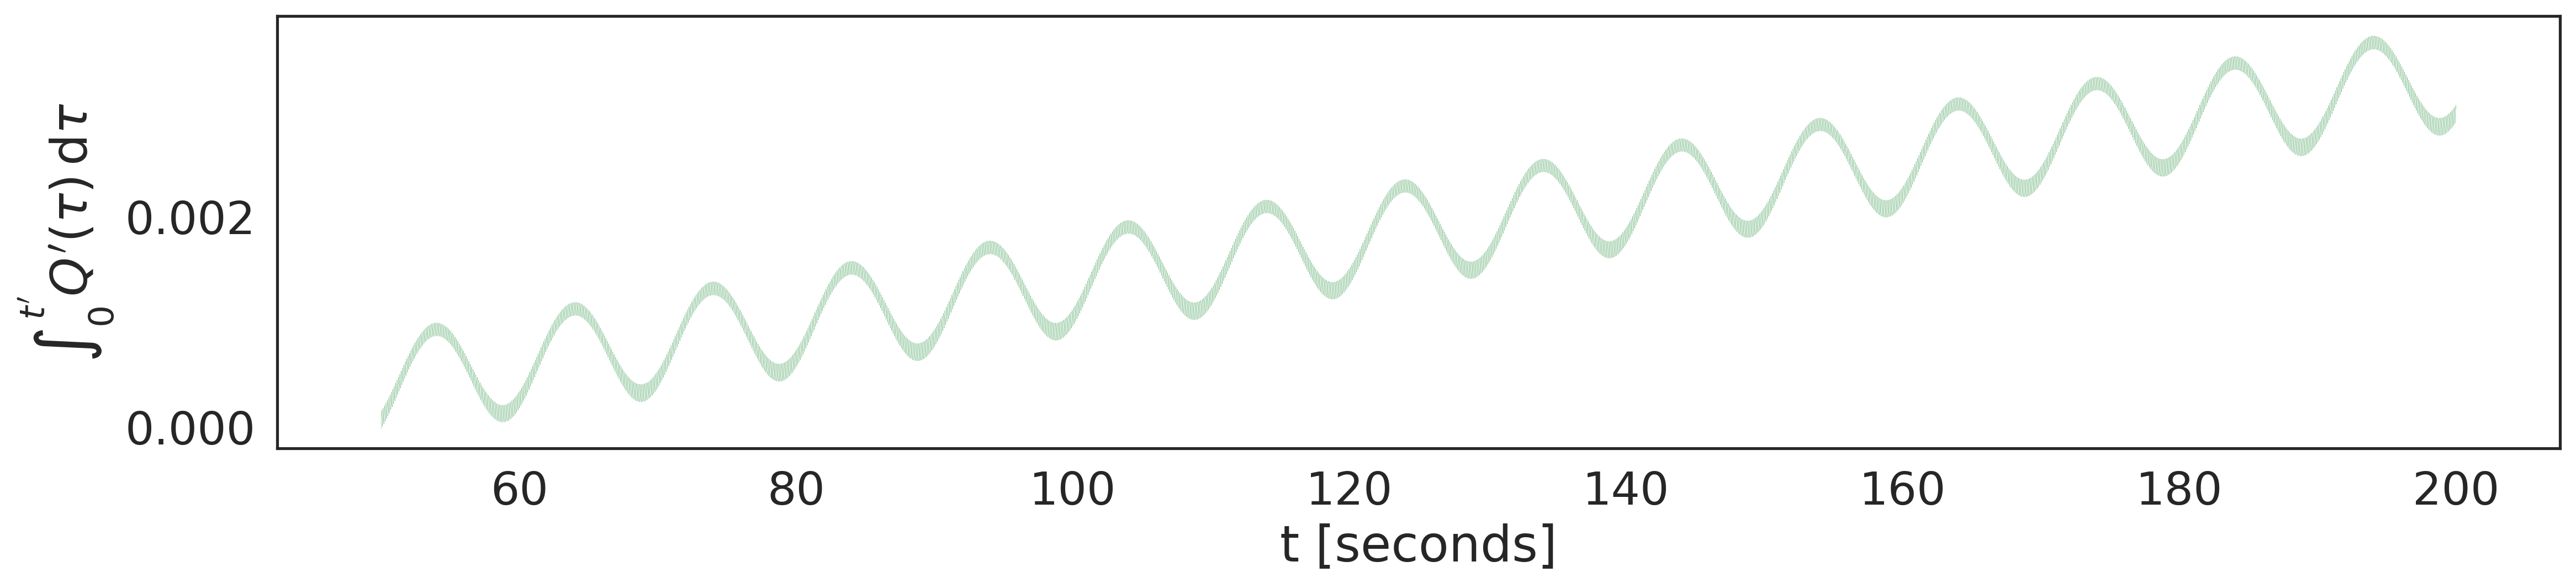

In [73]:
import matplotlib.pyplot as plt
sns.set(font_scale=1.8, style='white')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


T = n_cycles/min(freqs) # total simulation time
time_steps = len(qps)
dt = T/time_steps
outflowss = [[q(pos) for q in qs] for pos in poss]

ts = np.linspace(0, T, time_steps)[5*tsteps_per_cycle:]

plt.figure(figsize=(16,4))

ix = 2
outflows = outflowss[ix]
ys = np.cumsum(outflows[5*tsteps_per_cycle:])*dt    
plt.plot(ts, ys, linewidth=0.1, color=colors[ix])
plt.xlabel('t [seconds]')
plt.ylabel('$\int_{0}^{t\'} Q\'(\\tau)\,\mathrm{d}\\tau$')
plt.tight_layout()
plt.savefig(f'netflow_{ix}.png')

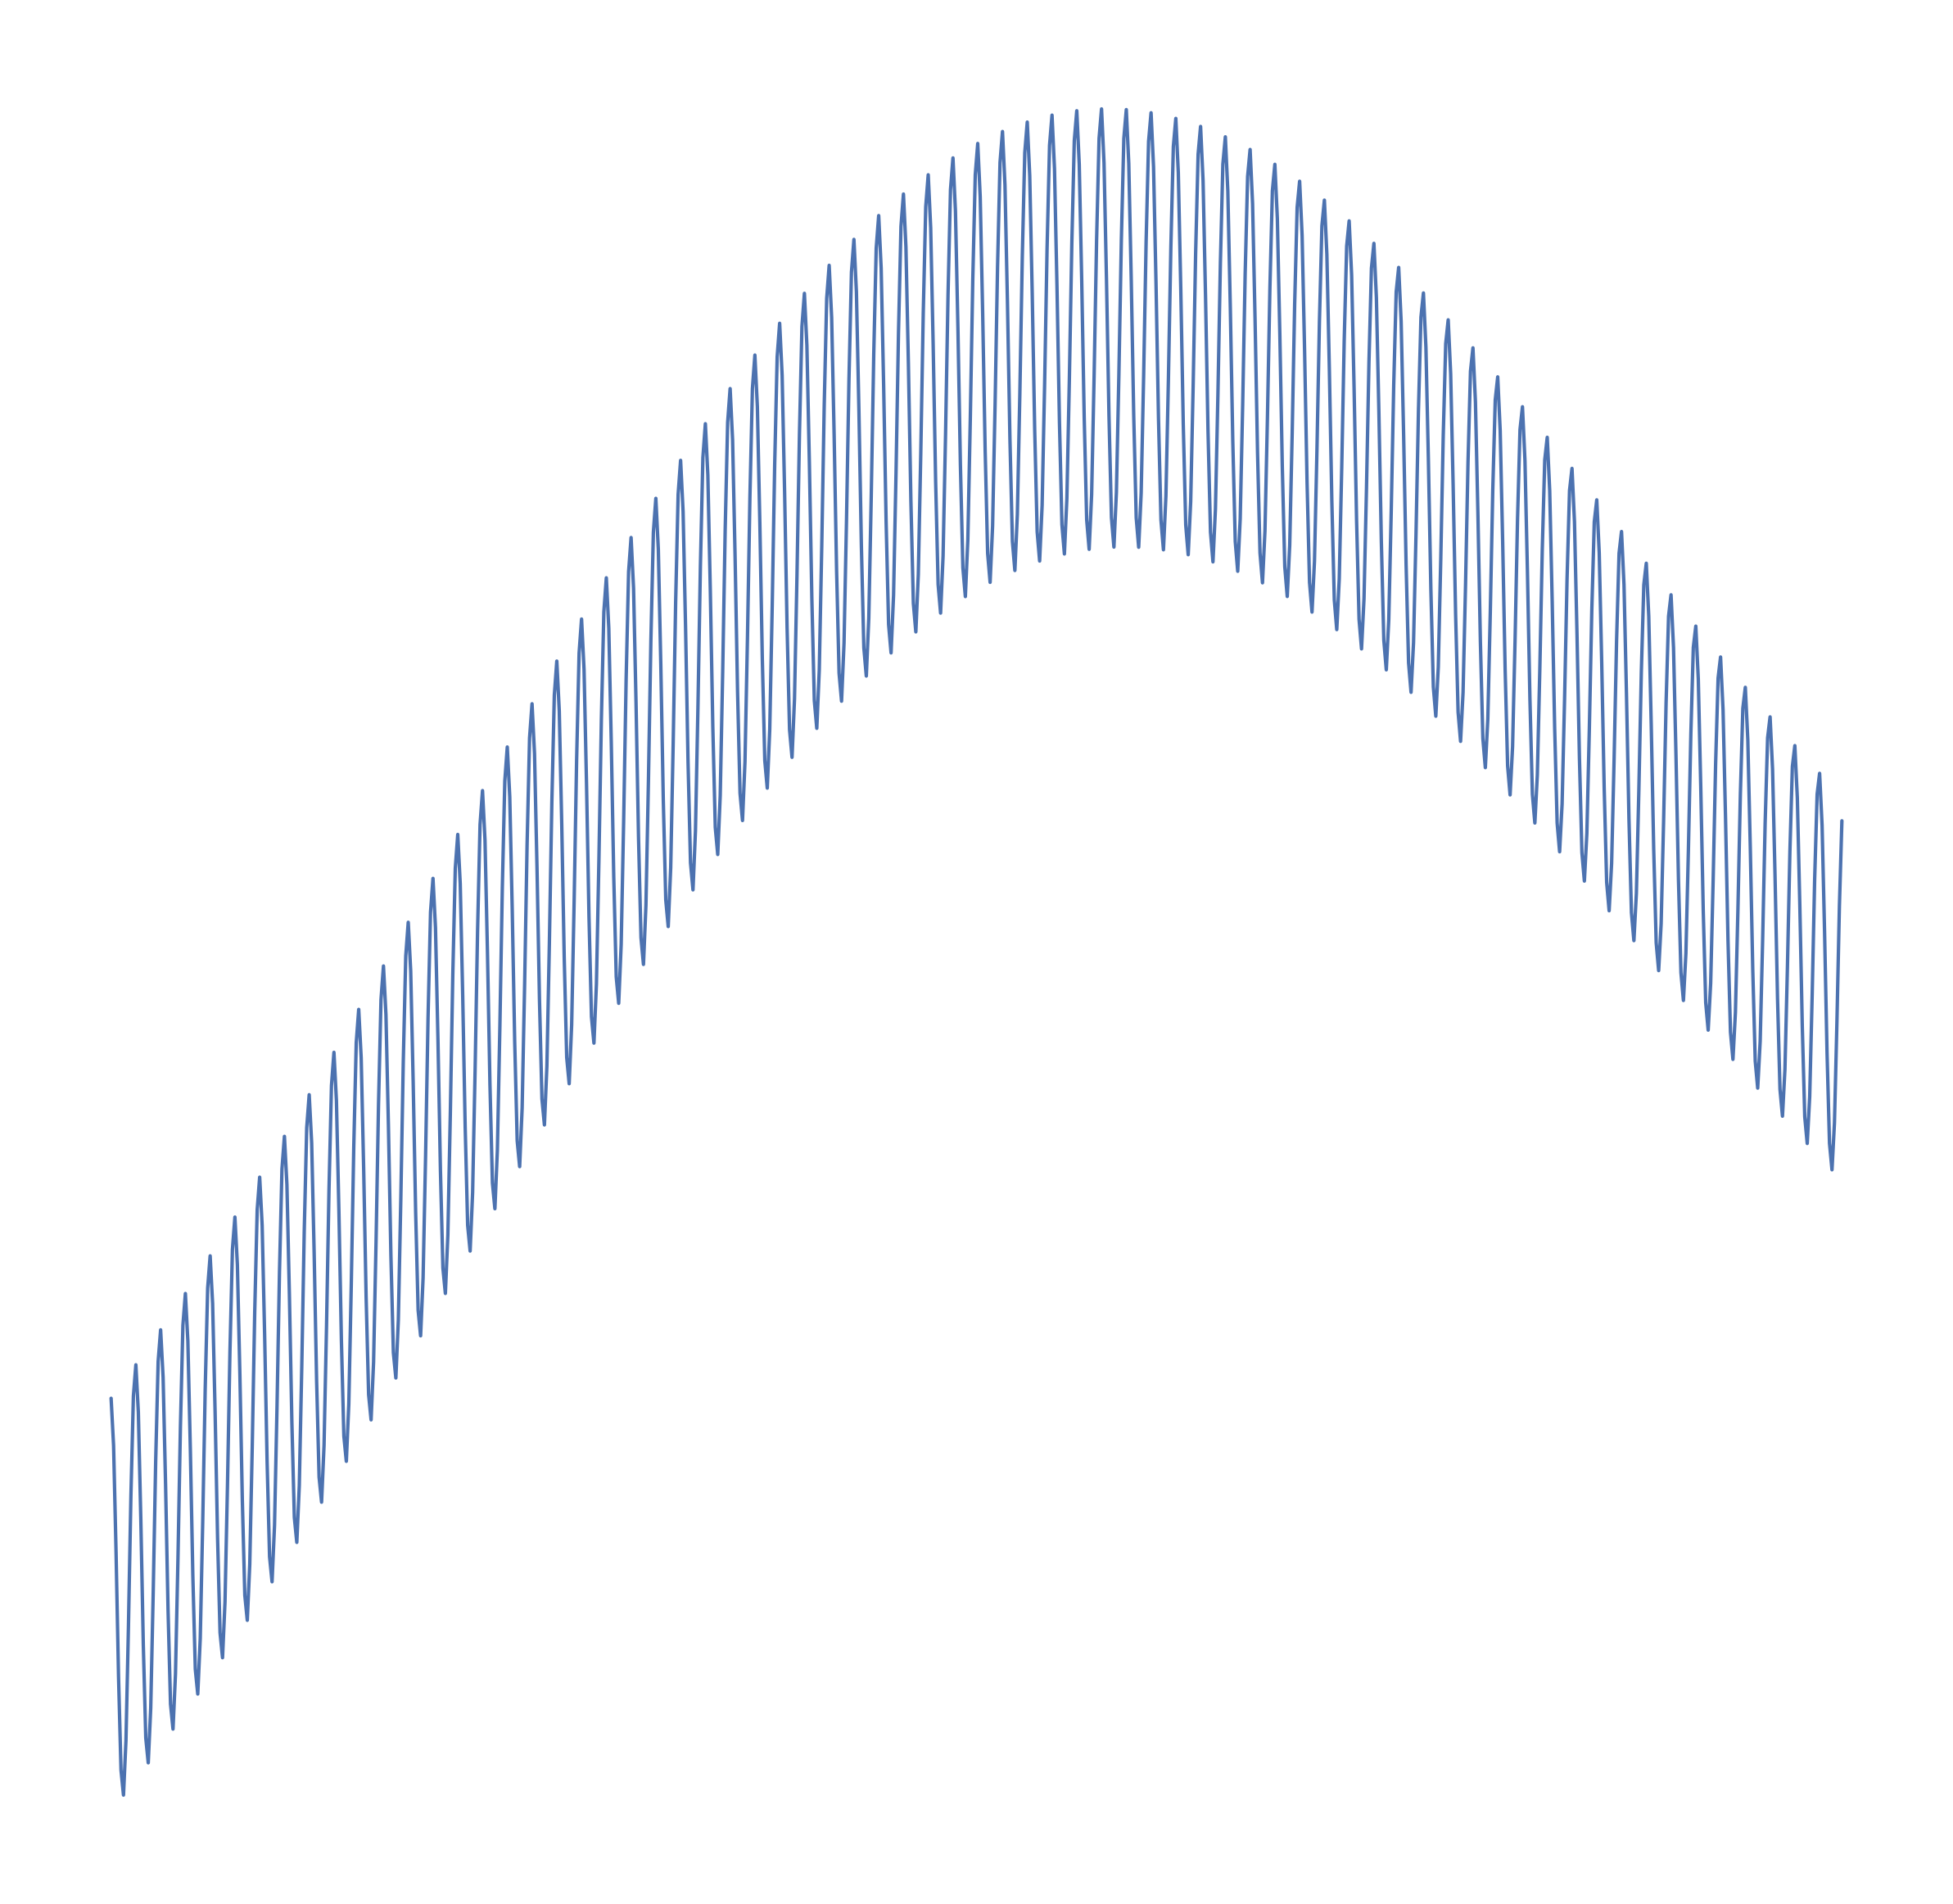

In [61]:
plt.figure(figsize=(10,10))
time_steps_per_cycles=1000
plt.plot(ts[1200:1900], ys[1200:1900], linewidth=1, color='b')
plt.axis('off')
plt.savefig('netflow_closeup')

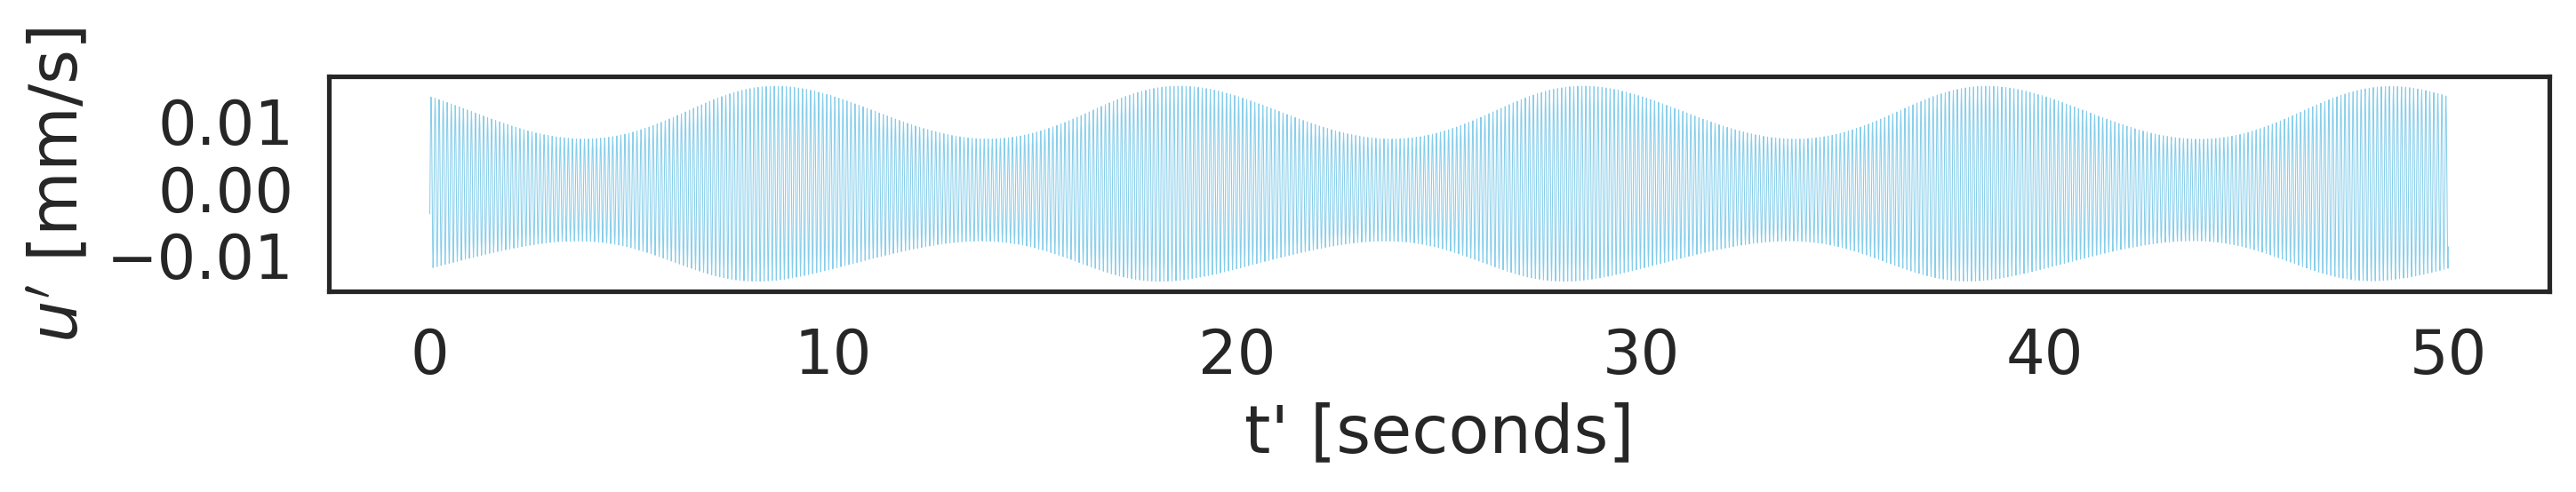

In [171]:
area_dict = nx.get_edge_attributes(G, 'area')
mesh0, foo = G.get_mesh(0)
DG = FunctionSpace(mesh0, 'DG', 0)
area = Function(DG)
area.vector()[:] = list(area_dict.values())
area.set_allow_extrapolation(True)


# Compute net flow from simulation
node = list(G.nodes())[inner_v]
pos = G.nodes()[node]['pos']
outflows = [sol[0](pos) for sol in qps]

sns.set(font_scale=1.5, style='white')

plt.figure(figsize=(10,2))
plt.plot(ts[:5000], outflows[1000:6000]/area(0,0,0), linewidth=0.25, color='skyblue')
plt.xlabel('t\' [seconds]')
plt.ylabel('$u\'$ [mm/s]')
plt.tight_layout()
plt.savefig('outflow_interior_node.png')

In [138]:
radius

array([0.1       , 0.06970106, 0.08712633, 0.04858238, 0.06072797,
       0.06072797, 0.07590997, 0.03386243, 0.04232804, 0.04232804,
       0.05291005, 0.04232804, 0.05291005, 0.05291005, 0.06613757,
       0.02360248, 0.02950309, 0.02950309, 0.03687887, 0.02950309,
       0.03687887, 0.03687887, 0.04609859, 0.02950309, 0.03687887,
       0.03687887, 0.04609859, 0.03687887, 0.04609859, 0.04609859,
       0.05762323, 0.01645118, 0.02056397, 0.02056397, 0.02570496,
       0.02056397, 0.02570496, 0.02570496, 0.0321312 , 0.02056397,
       0.02570496, 0.02570496, 0.0321312 , 0.02570496, 0.0321312 ,
       0.0321312 , 0.040164  , 0.02056397, 0.02570496, 0.02570496,
       0.0321312 , 0.02570496, 0.0321312 , 0.0321312 , 0.040164  ,
       0.02570496, 0.0321312 , 0.0321312 , 0.040164  , 0.0321312 ,
       0.040164  , 0.040164  , 0.05020501])

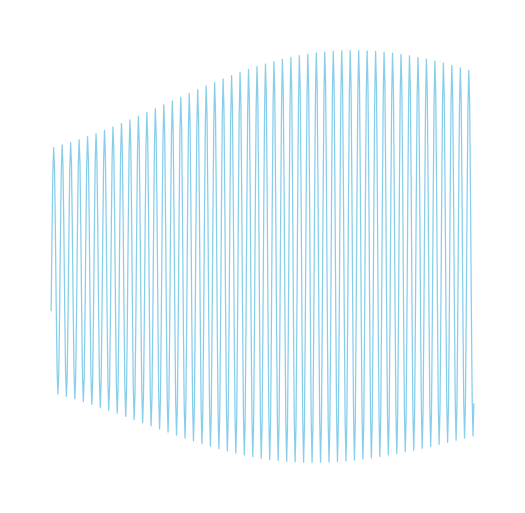

In [168]:


# Compute net flow from simulation
node = list(G.nodes())[inner_v]
pos = G.nodes()[node]['pos']
outflows = [sol[0](pos) for sol in qps]

sns.set(font_scale=1.5, style='white')

plt.figure(figsize=(2,2))
plt.plot(ts[500:1000], outflows[1500:2000], linewidth=0.3, color='skyblue')
plt.axis('off')
plt.savefig('outflow_interior_node_closeup.png')